<a href="https://colab.research.google.com/github/NguyenThiHongLinh/TieuLuan2024/blob/main/Taiwan_NF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kết nối với drive, import thư viện

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Data tiểu luận'
! pip install pypots>=0.4

Mounted at /content/gdrive
/content/gdrive/MyDrive/Data tiểu luận


In [ ]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from prettytable import PrettyTable
from numpy import mean
from numpy import std
# import miceforest as mf
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
# from pypots.data import load_specific_dataset, mcar, masked_fill
import torch
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.optim import Adam
from pypots.imputation import MRNN
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_mse
from pypots.utils.metrics import calc_rmse

In [ ]:
dtype = {
    "station": str,
    "AMB_TEMP": int,
    "CH4": int,
    "CO": float,
    "NMHC": float,
    "NO": float,
    "NO2": int,
    "NOx": int,
    "O3": int,
    "PH_RAIN": str,
    "PM10": int,
    "PM2.5": int,
    "RAINFALL": str,
    "RAIN_COND": str,
    "RH": str,
    "SO2": int,
    "THC": float,
    "UVB": int,
    "WD_HR": int,
    "WIND_DIREC": int,
    "WIND_SPEED": float,
    "WS_HR": float
}


def clean_data(elem):
    elem = str(elem)
    if elem == None or elem == ''or elem in 'NA':
        return np.NaN
    if any(x in elem for x in ["#", "*", "x"]):
        return np.NaN
    if any(x in elem for x in [".", "e"]):
        return float(elem)
    if elem in 'NR':
        return -1
    return int(elem)

converters = {
    "AMB_TEMP": clean_data,
    "CH4": clean_data,
    "CO": clean_data,
    "NMHC": clean_data,
    "NO": clean_data,
    "NO2": clean_data,
    "NOx": clean_data,
    "O3": clean_data,
    "PH_RAIN": clean_data,
    "PM10": clean_data,
    "PM2.5": clean_data,
    "RAINFALL": clean_data,
    "RAIN_COND": clean_data,
    "RH": clean_data,
    "SO2": clean_data,
    "THC": clean_data,
    "UVB": clean_data,
    "WD_HR": clean_data,
    "WIND_DIREC": clean_data,
    "WIND_SPEED": clean_data,
    "WS_HR": clean_data
}

## Load dataset, tính toán và biểu diễn dữ liệu bị thiếu

In [ ]:
def load_taiwan2015():
  dataset = pd.read_csv('taiwan.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
  dataset['time'] = pd.to_datetime(dataset['time'])
  return dataset

In [ ]:
# Compute % missing rate of a given dataset (as a DataFrame)
def missing_rate(dataset):
  total_missing = dataset.isnull().sum().sum()
  percent_missing = (total_missing / dataset.size) * 100
  return round(percent_missing,2)

In [ ]:
def display_missing_percent(dataset):
  total = dataset.isnull().sum().sort_values(ascending=False)
  percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  # plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of missing values', fontsize=15)
  plt.title('Percent missing data by feature', fontsize=15)
  missing_data.head

## Tìm các giờ bị thiếu

In [ ]:
def find_missing_hours_per_station(data):
    # data['time'] = pd.to_datetime(data['time'], errors='coerce')

    if data['time'].isnull().any():
        print("Có các giá trị không thể chuyển đổi sang datetime:")
        print(data[data['time'].isnull()])
        return

    # Tính chu kỳ giữa các bản ghi
    column_datetime1 = data['time']
    time_diffs = column_datetime1.diff().dt.total_seconds().dropna()
    cycle_seconds = time_diffs.mode().iloc[0]
    print("The cycle duration appears to be approximately", cycle_seconds, "seconds.")

    # Xác định xem thời gian được ghi lại trong 24 giờ hay 12 giờ
    time_difference = (column_datetime1.iloc[-1] - column_datetime1.iloc[0]).total_seconds()
    if time_difference > 12 * 3600:  # 12 hours * 3600 seconds/hour
        print("The time cycle appears to be 24 hours.")
    else:
        print("The time cycle appears to be 12 hours.")

    # Tìm giờ bị thiếu của từng station nếu có
    all_hours = set(range(24))
    data['date'] = data['time'].dt.date
    data['hour'] = data['time'].dt.hour

    stations = data['station'].unique()
    full_date_range = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')

    for station in stations:
        station_data = data[data['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        missing_data = []
        for missing_date in missing_dates:
            missing_data.append((station, missing_date, list(all_hours)))

        for date, group in station_data.groupby('date'):
            hours_in_day = set(group['hour'])
            missing_hours = all_hours - hours_in_day
            if missing_hours:
                missing_data.append((station, date, sorted(missing_hours)))

        if missing_data:
            print(f"Station {station} is missing the following hours:")
            for station, date, missing_hours in missing_data:
                formatted_date = pd.Timestamp(date).strftime('%Y-%m-%d')
                formatted_hours = [f"{hour:02d}:00" for hour in missing_hours]
                print(f"Date {formatted_date} is missing hours: {formatted_hours}")
        else:
            print(f"Station {station} has no missing hours.")

In [ ]:
def timeGraph(dataset):

# Khởi tạo figure
  plt.figure(figsize=(10, 6))

  # Lặp qua từng bộ dữ liệu và tên
  for dataset, time_column in dataset:
      # Chuyển đổi cột thời gian sang định dạng datetime
      time_data = pd.to_datetime(dataset[time_column])
      # Trích xuất giờ từ các đối tượng datetime
      hours = [time.hour for time in time_data]
      # Vẽ biểu đồ histogram
      plt.hist(hours, bins=24, edgecolor='black', alpha=0.5, label=time_column)

  # Thiết lập tiêu đề và nhãn trục
  plt.xlabel('Giờ')
  plt.ylabel('Số lượng')
  plt.title('Phân phối tần suất của dữ liệu thời gian')
  plt.xticks(range(0, 24))
  plt.grid(True)
  plt.legend()  # Hiển thị chú thích về tên của mỗi bộ dữ liệu
  plt.show()

## Tiền xử lý dữ liệu

In [ ]:
def preprocess_taiwan2015(dataset):
    """The preprocessing function for dataset Air Quality Taiwan.
    Parameters
    ----------
    dataset : raw dataset loaded from csv file.
    Returns
    -------
    dataset : pandas.DataFrame,
                A dataframe contains all time series vectors, distinguished by column 'station'.
    """
    print('Columns:', dataset.columns)

    # Giả sử dữ liệu ngày tháng nằm trong cột 'time', tách ngày và giờ
    if 'time' in dataset.columns:
        dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        dataset['hour'] = pd.to_datetime(dataset['time']).dt.hour
    else:
        raise KeyError("'time' column not found in dataset")

    # Kiểm tra và bổ sung các ngày thiếu
    stations = dataset['station'].unique()
    full_date_range = pd.date_range(start=dataset['date'].min(), end=dataset['date'].max(), freq='D')

    df_list = []
    for station in stations:
        station_data = dataset[dataset['station'] == station]
        station_dates = station_data['date'].unique()
        missing_dates = set(full_date_range.date).difference(station_dates)

        for missing_date in missing_dates:
            missing_date_data = pd.DataFrame({
                'time': [pd.Timestamp(missing_date) + pd.Timedelta(hours=h) for h in range(24)],
                'station': station,
                'date': [missing_date] * 24,
                'hour': range(24)
            })
            station_data = pd.concat([station_data, missing_date_data], ignore_index=True)

        df_list.append(station_data)

    dataset = pd.concat(df_list, ignore_index=True)

    X = dataset
    print('X shape: ', X.shape)

    def apply_func(df_temp):  # pad and truncate to set the max length of samples as 24
        missing = list(set(range(0, 24)).difference(set(df_temp['hour'])))
        missing_part = pd.DataFrame({
            'time': [df_temp['time'].iloc[0].replace(hour=h) for h in missing],
            'hour': missing
        })
        df_temp = pd.concat(
            [df_temp, missing_part], ignore_index=False, sort=False
        )  # pad the sample's length to 24 if it doesn't have enough time steps
        df_temp = df_temp.set_index('time').sort_index().reset_index()
        df_temp = df_temp.iloc[:24]  # truncate
        return df_temp

    X = X.groupby(['station', 'date']).apply(apply_func)
    X = X.drop('hour', axis=1)
    X = X.drop('station', axis=1)
    X = X.drop('date', axis=1)
    X = X.reset_index()
    X = X.drop(["level_2"], axis=1)

    return X


## Lọc và sắp xếp các bản ghi theo từng khu vực

In [ ]:
def get_stat_by_station(dataset):
  myTable = PrettyTable(["No.","station","#Records","From date","To date"])
  # Split dataframe by RecordID
  j = 1
  classification=list(dataset['station'].unique())
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    myTable.add_row([j,
                     i,
                    format(pm1.shape[0], ','),
                    pm1['time'].values[0],
                    pm1['time'].values[pm1.shape[0]-1]])
  j+=1
  return myTable

## Tính trend, cycle của dữ liệu

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Tính trend của tập dữ liệu khi loại bỏ các giá trị bị thiếu
def calculate_trend(data):
    # Xử lý giá trị NaN: Loại bỏ các dòng chứa giá trị NaN
    data_cleaned = data.dropna()

    # Loại bỏ các cột không cần thiết nếu tồn tại
    for col in ['time', 'station', 'date']:
        if col in data_cleaned.columns:
            data_cleaned = data_cleaned.drop([col], axis=1)

    column_names = list(data_cleaned.columns)
    num_subplots = len(column_names)  # Số lượng subplot bằng số cột dữ liệu

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 6*num_subplots))

    # Vẽ biểu đồ dữ liệu và đường trend cho từng thuộc tính
    for idx, col in enumerate(column_names):
        X = np.array(range(len(data_cleaned))).reshape(-1, 1)
        y = data_cleaned[col].values.reshape(-1, 1)

        # Khởi tạo và fit mô hình hồi quy tuyến tính
        model = LinearRegression()
        model.fit(X, y)

        # Vẽ dữ liệu
        axes[idx].plot(data_cleaned[col], label=col)
        # Vẽ trend line
        axes[idx].plot(model.predict(X), label=f'Trend of {col}', linestyle='--')

        axes[idx].set_xlabel('Index')
        axes[idx].set_ylabel('Value')
        axes[idx].set_title(f'Trend of {col}')
        axes[idx].legend(loc="best")

    plt.tight_layout()  # Đảm bảo không gian giữa các subplot
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

def find_cycle(data, column, lags=50):
    """
    Hàm tính chu kỳ của dữ liệu chuỗi thời gian dựa trên hàm tự tương quan (ACF).

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    column : str
        Tên cột chứa dữ liệu chuỗi thời gian cần tính chu kỳ.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycle : int
        Chu kỳ của dữ liệu chuỗi thời gian.
    """
    # Xóa các giá trị thiếu
    data_cleaned = data.dropna(subset=[column])

    # Tính toán ACF
    acf_values = acf(data_cleaned[column], nlags=lags)

    # Tìm độ trễ (lag) tại đó ACF đạt cực đại (bỏ qua độ trễ 0)
    cycle = np.argmax(acf_values[1:]) + 1

    # Vẽ biểu đồ ACF để trực quan hóa
    plot_acf(data_cleaned[column], lags=lags)
    plt.title(f'Autocorrelation Function for {column}')
    plt.show()

    return cycle

def find_cycles_for_all_columns(data, lags=50):
    """
    Hàm tính chu kỳ cho tất cả các cột trong DataFrame.

    Parameters:
    ----------
    data : pandas.DataFrame
        DataFrame chứa dữ liệu chuỗi thời gian.
    lags : int, optional
        Số lượng độ trễ (lags) để tính toán ACF. Mặc định là 50.

    Returns:
    -------
    cycles : dict
        Từ điển chứa chu kỳ của mỗi cột trong DataFrame.
    """
    cycles = {}
    for column in data.columns:
        if column == 'station' or not np.issubdtype(data[column].dtype, np.number):
            continue
        cycle = find_cycle(data, column, lags)
        cycles[column] = cycle
    return cycles

## Chuẩn bị dữ liệu bị thiếu nhân tạo

In [ ]:
from pygrinder import mcar, masked_fill
def generate_artifical_missing(data, missing_rate):
    X_intact = data.copy()
    missing_mask = np.random.rand(*data.shape) < missing_rate
    indicating_mask = np.random.rand(*data.shape) < missing_rate
    data[missing_mask] = np.nan
    return X_intact, data, missing_mask, indicating_mask

In [ ]:
def prepare_train_val_test(train_data, val_data, test_data, missing_rate, n_steps):
    # Ensure 'date' column exists
    if 'date' not in train_data.columns:
        if 'time' in train_data.columns:
            train_data['date'] = pd.to_datetime(train_data['time']).dt.date
            val_data['date'] = pd.to_datetime(val_data['time']).dt.date
            test_data['date'] = pd.to_datetime(test_data['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the data.")

    # Drop 'date', 'station' and 'time' columns
    train_X = train_data.drop(['date', 'station', 'time'], axis=1)
    val_X = val_data.drop(['date', 'station', 'time'], axis=1)
    test_X = test_data.drop(['date', 'station', 'time'], axis=1)

    # Check for NaN values and remove rows with NaNs
    train_X = train_X.dropna()
    val_X = val_X.dropna()
    test_X = test_X.dropna()

    train_X, val_X, test_X = (
        train_X.to_numpy(),
        val_X.to_numpy(),
        test_X.to_numpy(),
    )

    # Normalize the data
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.transform(val_X)
    test_X = scaler.transform(test_X)

    # Calculate the number of samples
    num_samples_train = train_X.shape[0] // n_steps
    num_samples_val = val_X.shape[0] // n_steps
    num_samples_test = test_X.shape[0] // n_steps

    # Reshape the arrays
    train_X = train_X[:num_samples_train * n_steps].reshape(num_samples_train, n_steps, -1)
    val_X = val_X[:num_samples_val * n_steps].reshape(num_samples_val, n_steps, -1)
    test_X = test_X[:num_samples_test * n_steps].reshape(num_samples_test, n_steps, -1)

    # Generate artificial missing data
    val_X_intact, val_X, val_missing_mask, val_X_indicating_mask = generate_artifical_missing(val_X, missing_rate=missing_rate)
    test_X_intact, test_X, test_missing_mask, test_X_indicating_mask = generate_artifical_missing(test_X, missing_rate=missing_rate)

    data = {
        "n_steps": n_steps,
        "n_features": train_X.shape[-1],
        "train_X": train_X,
        "val_X": val_X,
        "test_X": test_X,
        "scaler": scaler,
        "val_X_intact": val_X_intact,
        "val_X_indicating_mask": val_X_indicating_mask,
        "test_X_intact": test_X_intact,
        "test_X_indicating_mask": test_X_indicating_mask,
    }

    return data

## Chia dữ liệu thành tập train, val, test

In [ ]:
def split_train_test_taiwan2015(dataset):
  date_format = '%Y-%m-%d %H:%M:%S'

  # tỉ lệ 60/20/20
  train_end = datetime.strptime('2015-8-7 23:00:00', date_format)
  val_end = datetime.strptime('2015-10-19 23:00:00', date_format)

  # test_end = datetime.strptime('2015-12-31 23:00:00', date_format)

# group by station
  classification=list(dataset['station'].unique())
  train_data = pd.DataFrame()
  val_data = pd.DataFrame()
  test_data = pd.DataFrame()
  for i in classification:
    pm1=dataset[dataset['station'].isin([i])]
    # Split the data into training, validation, and test sets
    train_data = pd.concat([train_data, pm1[pm1.time <= train_end]])
    val_data = pd.concat([val_data, pm1[(train_end < pm1.time) & (pm1.time <= val_end)]])
    test_data = pd.concat([test_data, pm1[pm1.time > val_end]])
  train_data.sort_values(['station', 'time'])
  val_data.sort_values(['station', 'time'])
  test_data.sort_values(['station', 'time'])
  return train_data, val_data, test_data

## Chia tập trai, test, val cho các phương thức sử dụng PyPots

In [ ]:
def get_train_val_test_pypots(data):
  dataset_for_training = {
    "X": data['train_X'],
  }

  dataset_for_validating = {
    "X": data['val_X'],
    "X_ori": data['val_X_intact'],
    "indicating_mask": data['val_X_indicating_mask'],
  }

  dataset_for_testing = {
    "X": data['test_X'],
  }
  return dataset_for_training, dataset_for_validating, dataset_for_testing


# Phương pháp truyền thống

##Phương pháp Median

In [ ]:
def imputeByMedian(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmedian(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp Mean

In [ ]:
def imputeByMean(data):
  X = data['test_X']
  X = X.reshape(X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  X[np.isnan(X)] = np.nanmean(X)
  running_time = (time.time()*1000 - start)
  X = X.reshape(X.shape[0], data['n_steps'], -1)
  return X, running_time

## Phương pháp kNN

In [ ]:
def imputeByKNN(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  knn_imputer = KNNImputer(n_neighbors=3, weights="uniform")
  knn_imputer.fit(train_X)
  X_imputed = knn_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

## Phương pháp MICE

In [ ]:
def imputeByMICE(data):
  train_X = data['train_X']
  train_X = train_X.reshape(train_X.shape[0], -1)
  test_X = data['test_X']
  test_X = test_X.reshape(test_X.shape[0], -1)
  start = time.time()*1000 #in milliseconds
  mice_imputer = IterativeImputer(max_iter=5, tol=1e-3, verbose=1)
  mice_imputer.fit(train_X)
  X_imputed = mice_imputer.transform(test_X)
  running_time = (time.time()*1000 - start)
  X_imputed = X_imputed.reshape(X_imputed.shape[0], data['n_steps'], -1)
  return X_imputed, running_time

# Phương pháp dựa trên mạng neural

## Phương pháp SAITS

In [ ]:
def apply_saits(data): #data: dict generated from prepare_train_val_test
  saits = SAITS(n_steps=data['n_steps'], n_features=data['n_features'], n_layers=2, d_model=256,d_ffn=128,
                 n_heads=4, d_k=64, d_v=64, dropout=0.1, batch_size=256, epochs=15, patience=3, device='cpu', saving_path="data_taiwan/saits")

  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  saits.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = saits.impute(dataset_for_testing)
  running_time = (time.time()*1000 - start)
  return imputation, running_time


## Phương pháp MRNN

In [ ]:
def apply_mrnn(data): #data: dict generated from prepare_train_val_test
  mrnn = MRNN(n_steps=data['n_steps'], n_features=data['n_features'], rnn_hidden_size=128,
    batch_size=256, epochs=15, patience=3, optimizer=Adam(lr=1e-3),
    num_workers=0, device='cpu', saving_path="data_taiwan/mrnn"
  )
  dataset_for_training, dataset_for_validating, dataset_for_testing = get_train_val_test_pypots(data)

  start = time.time()*1000 #in milliseconds
  mrnn.fit(train_set=dataset_for_training, val_set=dataset_for_validating)
  imputation = mrnn.impute(dataset_for_testing)
  running_time = (time.time()*1000 - start)
  return imputation, running_time

# Tổng hợp các phương pháp

In [ ]:
def export_metrics(imputation, X_intact, indicating_mask):
  mae = calc_mae(imputation, X_intact, indicating_mask)
  # mse = calc_mse(imputation, X_intact, indicating_mask)
  rmse = calc_rmse(imputation, X_intact, indicating_mask)
  return mae, rmse

In [ ]:
def impute_missing(train_data, val_data, test_data, method, rate, n_steps, compute_metrics=True):
    data = prepare_train_val_test(train_data, val_data, test_data, missing_rate=rate, n_steps=n_steps)
    if method == 'mean':
        imputation, running_time = imputeByMean(data)
    elif method == 'median':
        imputation, running_time = imputeByMedian(data)
    elif method == 'knn':
        imputation, running_time  = imputeByKNN(data)
    elif method == 'mice':
        imputation, running_time = imputeByMICE(data)
    elif method == 'mrnn':
        imputation, running_time = apply_mrnn(data)
    elif method == 'saits':
        imputation, running_time = apply_saits(data)
    else:
        raise Exception("Sorry, method is unsupported!")
    result = {
        "imputation": imputation,
        "running_time": running_time,
        "scaler": data['scaler'],
    }
    if compute_metrics:
        mae, rmse = export_metrics(imputation, data['test_X_intact'], data['test_X_indicating_mask'])
        result["mae"] = mae
        # result["mse"] = mse
        result["rmse"] = rmse
    return result

In [ ]:
import os

def run_experiment(dataset, missing_rates, methods, n_steps=24, N=10):
    # Generate dataframe columns
    COLUMN_NAMES = ["Artificial missing rate"]
    for method in methods:
        COLUMN_NAMES.extend([method, method+'_STD'])

    df_mae = pd.DataFrame(columns=COLUMN_NAMES)
    # df_mse = pd.DataFrame(columns=COLUMN_NAMES)
    df_rmse = pd.DataFrame(columns=COLUMN_NAMES)
    df_running_time = pd.DataFrame(columns=COLUMN_NAMES)

    # Ensure 'date' column exists
    if 'date' not in dataset.columns:
        if 'time' in dataset.columns:
            dataset['date'] = pd.to_datetime(dataset['time']).dt.date
        else:
            raise KeyError("Neither 'date' nor 'time' column exists in the dataset.")

    train_data, val_data, test_data = split_train_test_taiwan2015(dataset)

    for rate in missing_rates:
        list_rate_mae = [rate]
        # list_rate_mse = [rate]
        list_rate_rmse = [rate]
        list_rate_running_time = [rate]

        for method in methods:
            running_time_avg = []
            mae_avg = []
            # mse_avg = []
            rmse_avg = []

            for i in range(N):
                print('Rate:', rate, 'Method:', method, 'N:', i)
                result = impute_missing(train_data, val_data, test_data, method, rate, n_steps)
                mae_avg.append(result['mae'])
                # mse_avg.append(result['mse'])
                rmse_avg.append(result['rmse'])
                running_time_avg.append(result['running_time'])

            list_rate_mae.extend([round(np.mean(mae_avg), 4), round(np.std(mae_avg), 4)])
            # list_rate_mse.extend([round(np.mean(mse_avg), 4), round(np.std(mse_avg), 4)])
            list_rate_rmse.extend([round(np.mean(rmse_avg), 4), round(np.std(rmse_avg), 4)])
            list_rate_running_time.extend([round(np.mean(running_time_avg), 4), round(np.std(running_time_avg), 4)])

        df_mae.loc[len(df_mae.index)] = list_rate_mae
        # df_mse.loc[len(df_mse.index)] = list_rate_mse
        df_rmse.loc[len(df_rmse.index)] = list_rate_rmse
        df_running_time.loc[len(df_running_time.index)] = list_rate_running_time

    os.makedirs('data_excel', exist_ok=True)

    df_mae.to_excel('data_excel/MAE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    # df_mse.to_excel('data_excel/MSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_rmse.to_excel('data_excel/RMSE_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')
    df_running_time.to_excel('data_excel/RunningTime_IF_Taiwan2015_'+str(missing_rates[0])+'_'+str(missing_rates[-1])+str(datetime.now())+'.xlsx')

    return df_mae, df_rmse, df_running_time

# Test các phương pháp truyền thống

## Load và tiền xử lý dữ liệu

In [ ]:
dataset=load_taiwan2015()
print(dataset)

<ipython-input-5-7b19fae4b7be>:2: ParserWarning: Both a converter and dtype were specified for column AMB_TEMP - only the converter will be used.
  dataset = pd.read_csv('taiwan.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-5-7b19fae4b7be>:2: ParserWarning: Both a converter and dtype were specified for column CH4 - only the converter will be used.
  dataset = pd.read_csv('taiwan.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-5-7b19fae4b7be>:2: ParserWarning: Both a converter and dtype were specified for column CO - only the converter will be used.
  dataset = pd.read_csv('taiwan.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-5-7b19fae4b7be>:2: ParserWarning: Both a converter and dtype were specified for column NMHC - only the converter will be used.
  dataset = pd.read_csv('taiwan.csv', dtype = dtype, converters = converters, parse_dates = ['time'])
<ipython-input-5-7b19fa

                      time    station  AMB_TEMP  CH4    CO  NMHC   NO   NO2  \
0      2015-01-01 00:00:00    Banqiao      16.0  2.1  0.79  0.14  1.2  16.0   
1      2015-01-01 01:00:00    Banqiao      16.0  2.1  0.80  0.15  1.3  16.0   
2      2015-01-01 02:00:00    Banqiao      16.0  2.1  0.71  0.13  1.0  13.0   
3      2015-01-01 03:00:00    Banqiao      15.0  2.0  0.66  0.12  0.8  11.0   
4      2015-01-01 04:00:00    Banqiao      15.0  2.0  0.53  0.11  0.6  10.0   
...                    ...        ...       ...  ...   ...   ...  ...   ...   
218635 2015-12-31 19:00:00  Zhongshan      18.0  1.9  1.05  0.25  6.1  39.0   
218636 2015-12-31 20:00:00  Zhongshan      18.0  1.9  0.96  0.22  5.3  37.0   
218637 2015-12-31 21:00:00  Zhongshan      18.0  1.9  0.82  0.19  4.0  28.0   
218638 2015-12-31 22:00:00  Zhongshan      18.0  1.9  0.88  0.21  4.5  32.0   
218639 2015-12-31 23:00:00  Zhongshan      18.0  1.9  0.84  0.19  4.7  29.0   

         NOx    O3  ...  RAINFALL  RAIN_COND    RH 

## Tìm giờ bị thiếu

In [ ]:
find_missing_hours_per_station(dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Banqiao has no missing hours.
Station Cailiao is missing the following hours:
Date 2015-05-03 is missing hours: ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
Station Datong has no missing hours.
Station Dayuan has no missing hours.
Station Guanyin has no missing hours.
Station Guting has no missing hours.
Station Keelung has no missing hours.
Station Linkou is missing the following hours:
Date 2015-05-17 is missing hours: ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
Date 2015-05-16 is missing hours: ['00:00', '01:00', '02:00', '03:00', '04:0

In [ ]:
pre_dataset=preprocess_taiwan2015(dataset)
print(pre_dataset)

Columns: Index(['time', 'station', 'AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx',
       'O3', 'PH_RAIN', 'PM10', 'PM2.5', 'RAINFALL', 'RAIN_COND', 'RH', 'SO2',
       'THC', 'UVB', 'WD_HR', 'WIND_DIREC', 'WIND_SPEED', 'WS_HR', 'date',
       'hour'],
      dtype='object')
X shape:  (219000, 25)
          station        date                time  AMB_TEMP  CH4    CO  NMHC  \
0         Banqiao  2015-01-01 2015-01-01 00:00:00      16.0  2.1  0.79  0.14   
1         Banqiao  2015-01-01 2015-01-01 01:00:00      16.0  2.1  0.80  0.15   
2         Banqiao  2015-01-01 2015-01-01 02:00:00      16.0  2.1  0.71  0.13   
3         Banqiao  2015-01-01 2015-01-01 03:00:00      15.0  2.0  0.66  0.12   
4         Banqiao  2015-01-01 2015-01-01 04:00:00      15.0  2.0  0.53  0.11   
...           ...         ...                 ...       ...  ...   ...   ...   
218995  Zhongshan  2015-12-31 2015-12-31 19:00:00      18.0  1.9  1.05  0.25   
218996  Zhongshan  2015-12-31 2015-12-31 20:00:00      18

## Gom cụm theo từng khu vực

In [ ]:
print(get_stat_by_station(pre_dataset))

+-----+-----------+----------+-------------------------------+-------------------------------+
| No. |  station  | #Records |           From date           |            To date            |
+-----+-----------+----------+-------------------------------+-------------------------------+
|  1  |  Banqiao  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Cailiao  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Datong  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Dayuan  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Guanyin  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Guting  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |  Keelung  |  8,760   | 2015-01-01T00:00:00.000000000 | 2015-12-31T23:00:00.000000000 |
|  1  |   Linkou  |  8,760   | 2015-01-01T00:00:00

Tỷ lệ dữ liệu bị khuyết trong tập dataset sau khi tiền xử lý là:  22.85 %


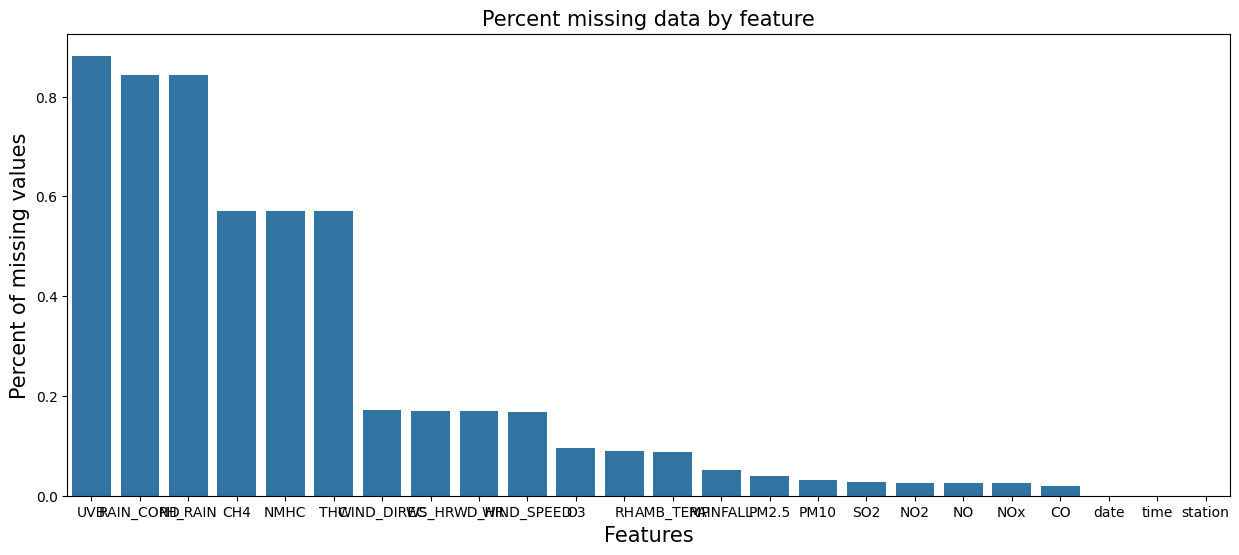

In [ ]:
print("Tỷ lệ dữ liệu bị khuyết trong tập dataset sau khi tiền xử lý là: ",missing_rate(pre_dataset),"%")
display_missing_percent(pre_dataset)

In [ ]:
find_missing_hours_per_station(pre_dataset)

The cycle duration appears to be approximately 3600.0 seconds.
The time cycle appears to be 24 hours.
Station Banqiao has no missing hours.
Station Cailiao has no missing hours.
Station Datong has no missing hours.
Station Dayuan has no missing hours.
Station Guanyin has no missing hours.
Station Guting has no missing hours.
Station Keelung has no missing hours.
Station Linkou has no missing hours.
Station Longtan has no missing hours.
Station Pingzhen has no missing hours.
Station Sanchong has no missing hours.
Station Shilin has no missing hours.
Station Songshan has no missing hours.
Station Tamsui has no missing hours.
Station Taoyuan has no missing hours.
Station Tucheng has no missing hours.
Station Wanhua has no missing hours.
Station Wanli has no missing hours.
Station Xindian has no missing hours.
Station Xinzhuang has no missing hours.
Station Xizhi has no missing hours.
Station Yangming has no missing hours.
Station Yonghe has no missing hours.
Station Zhongli has no missing

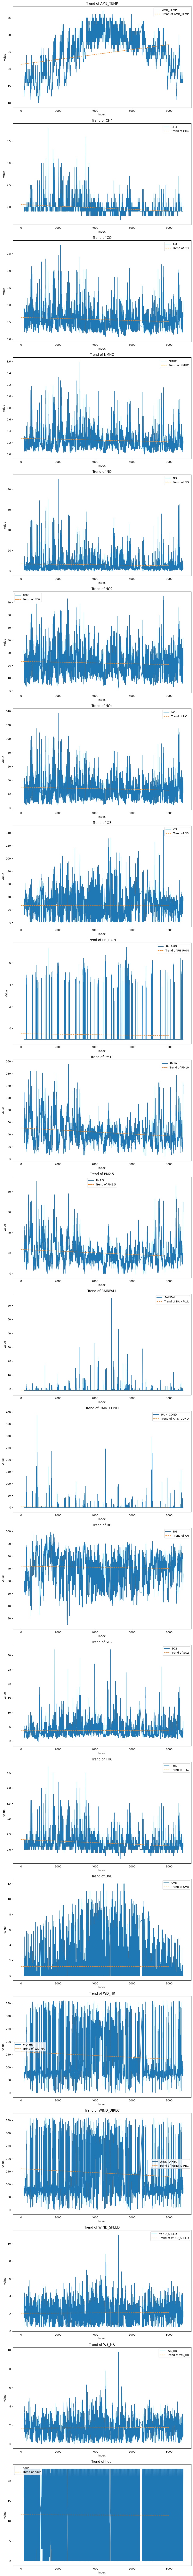

None


In [ ]:
trend=calculate_trend(pre_dataset)
print(trend)

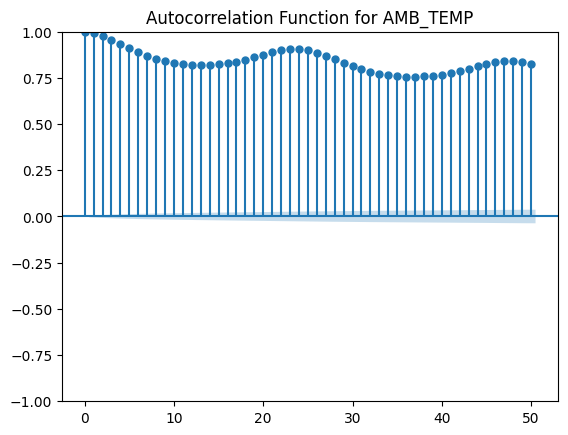

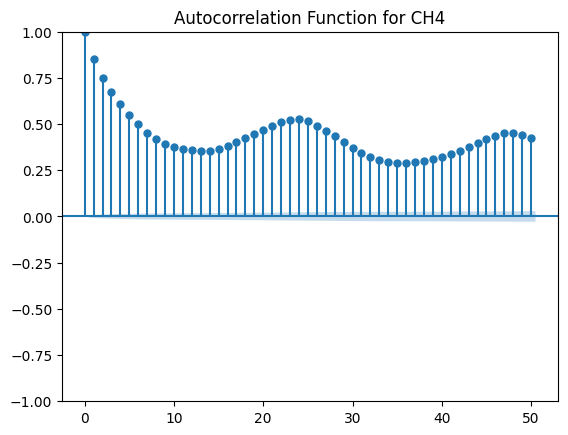

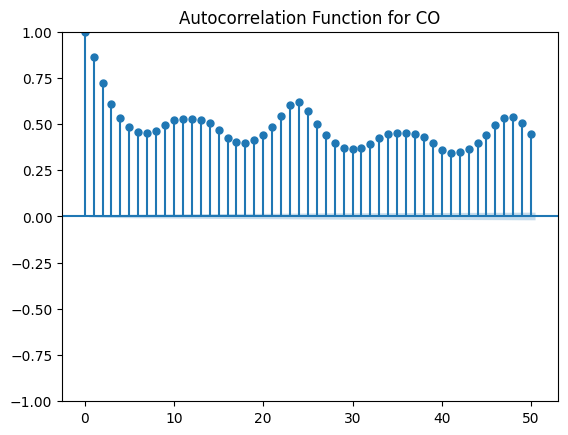

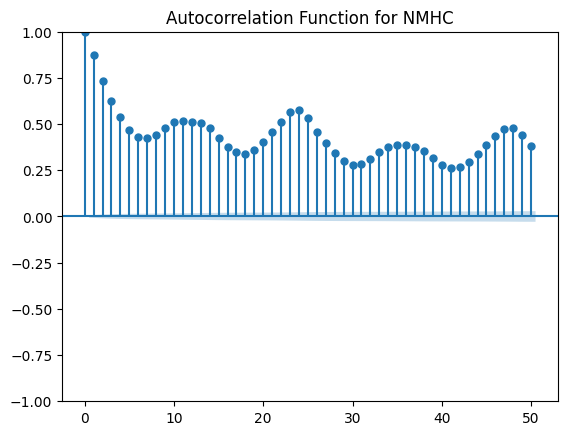

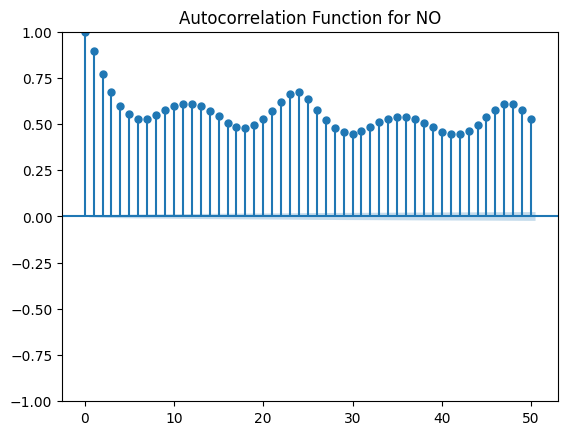

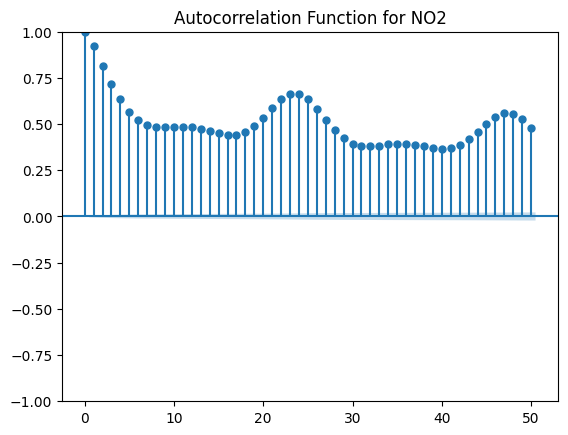

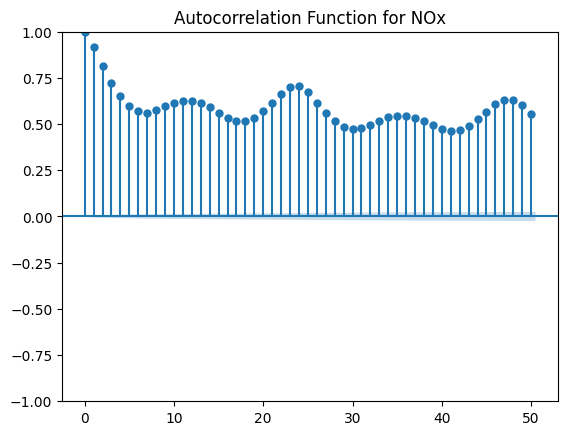

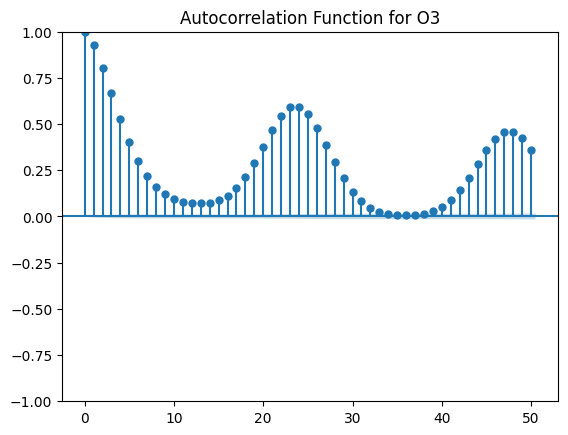

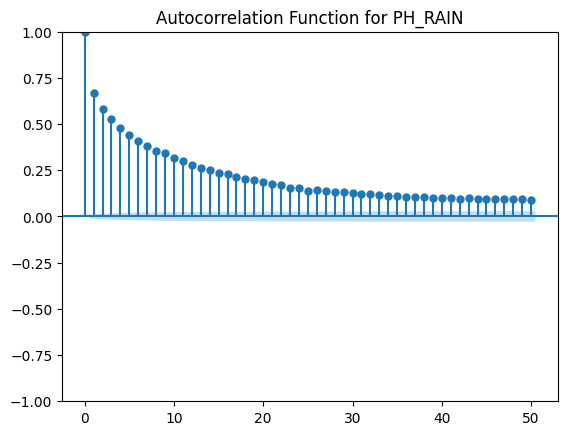

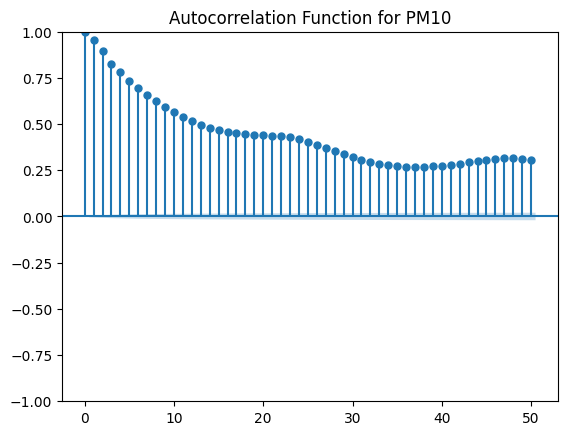

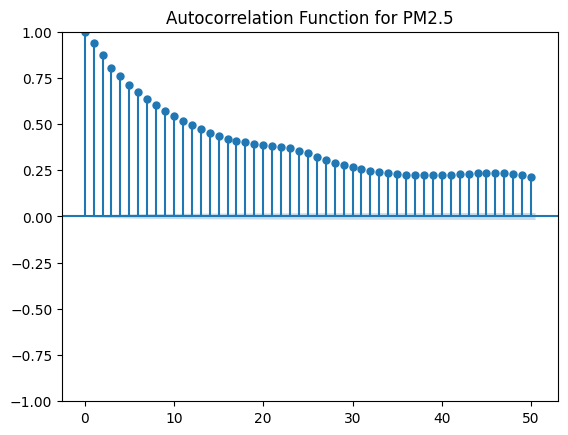

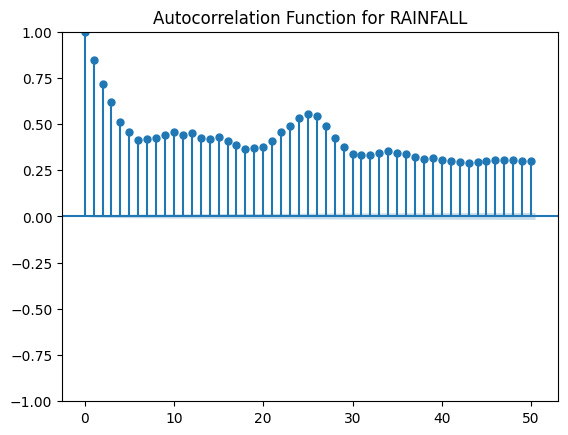

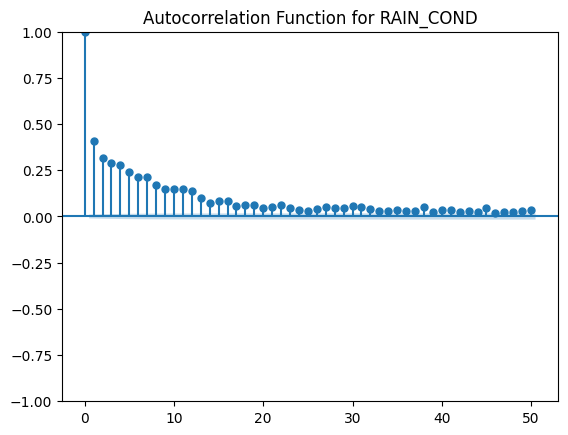

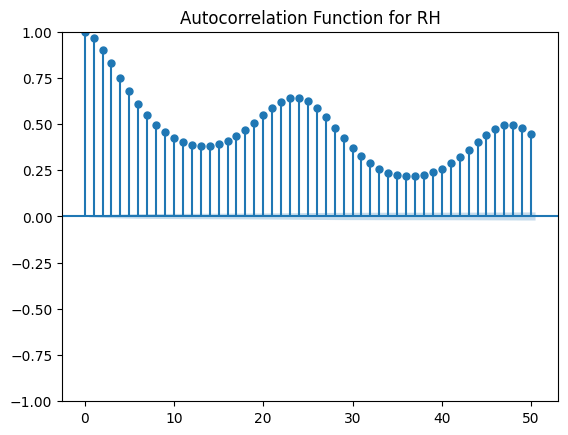

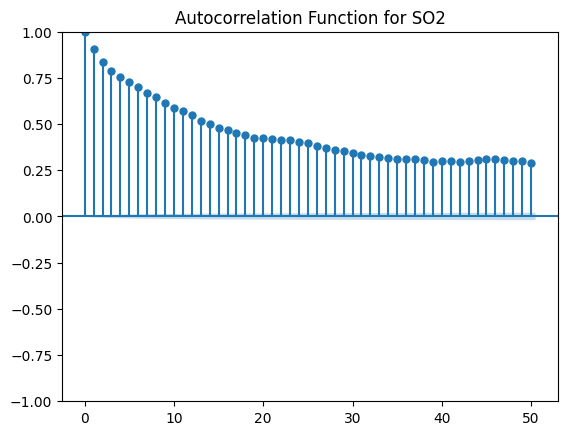

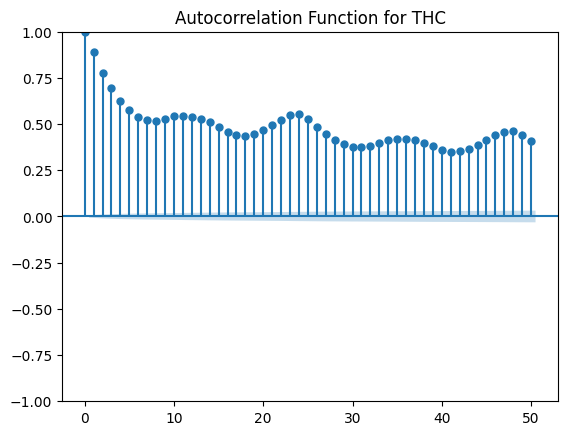

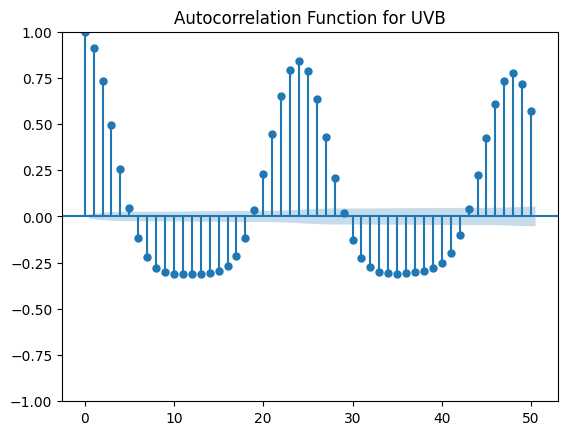

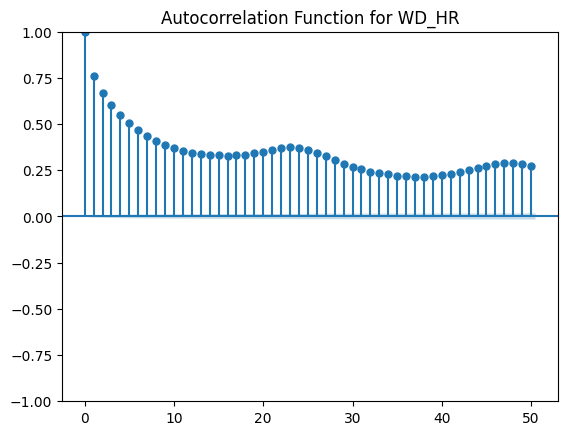

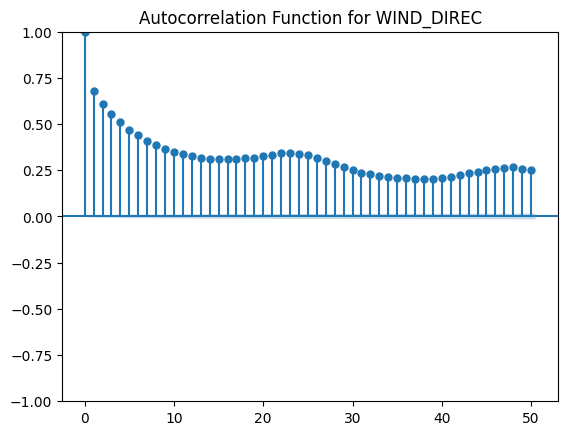

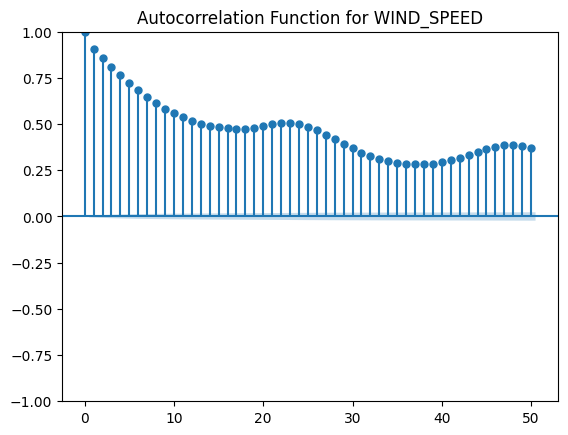

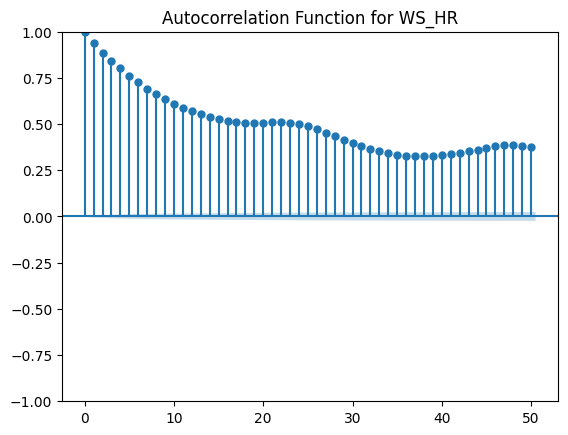

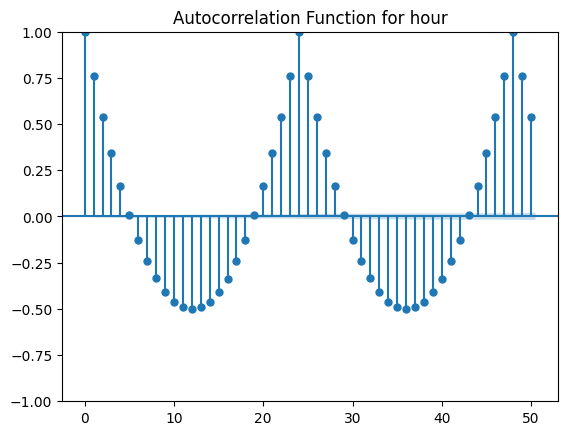

{'AMB_TEMP': 1,
 'CH4': 1,
 'CO': 1,
 'NMHC': 1,
 'NO': 1,
 'NO2': 1,
 'NOx': 1,
 'O3': 1,
 'PH_RAIN': 1,
 'PM10': 1,
 'PM2.5': 1,
 'RAINFALL': 1,
 'RAIN_COND': 1,
 'RH': 1,
 'SO2': 1,
 'THC': 1,
 'UVB': 1,
 'WD_HR': 1,
 'WIND_DIREC': 1,
 'WIND_SPEED': 1,
 'WS_HR': 1,
 'hour': 24}

In [ ]:
find_cycles_for_all_columns(pre_dataset)
# kết quả trả về cho thấy dữ liệu không có chu kỳ dài hạn rõ ràng trong phạm vi độ trễ được xem xét (ở đây là 50)

## Chạy các phương thức

In [ ]:
n_steps = 24
missing_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
methods = ['median','mean','knn', 'mice' ]



In [ ]:
df_mae, df_rmse, df_running_time = run_experiment(pre_dataset, missing_rates, methods)

Rate: 0.1 Method: median N: 0
Rate: 0.1 Method: median N: 1
Rate: 0.1 Method: median N: 2
Rate: 0.1 Method: median N: 3
Rate: 0.1 Method: median N: 4
Rate: 0.1 Method: median N: 5
Rate: 0.1 Method: median N: 6
Rate: 0.1 Method: median N: 7
Rate: 0.1 Method: median N: 8
Rate: 0.1 Method: median N: 9
Rate: 0.1 Method: mean N: 0
Rate: 0.1 Method: mean N: 1
Rate: 0.1 Method: mean N: 2
Rate: 0.1 Method: mean N: 3
Rate: 0.1 Method: mean N: 4
Rate: 0.1 Method: mean N: 5
Rate: 0.1 Method: mean N: 6
Rate: 0.1 Method: mean N: 7
Rate: 0.1 Method: mean N: 8
Rate: 0.1 Method: mean N: 9
Rate: 0.1 Method: knn N: 0
Rate: 0.1 Method: knn N: 1
Rate: 0.1 Method: knn N: 2
Rate: 0.1 Method: knn N: 3
Rate: 0.1 Method: knn N: 4
Rate: 0.1 Method: knn N: 5
Rate: 0.1 Method: knn N: 6
Rate: 0.1 Method: knn N: 7
Rate: 0.1 Method: knn N: 8
Rate: 0.1 Method: knn N: 9
Rate: 0.1 Method: mice N: 0
[IterativeImputer] Completing matrix with shape (197, 528)
[IterativeImputer] Change: 0.0, scaled tolerance: 0.03686259208

In [ ]:
print(df_mae)
print( df_rmse)
print( df_running_time)

   Artificial missing rate  median  median_STD    mean  mean_STD     knn  \
0                      0.1  0.0588      0.0019  0.0593    0.0045  0.0439   
1                      0.2  0.1193      0.0026  0.1230    0.0028  0.0857   
2                      0.3  0.1774      0.0051  0.1802    0.0034  0.1289   
3                      0.4  0.2341      0.0032  0.2430    0.0035  0.1752   
4                      0.5  0.2939      0.0036  0.2998    0.0028  0.2189   
5                      0.6  0.3517      0.0043  0.3615    0.0031  0.2648   
6                      0.7  0.4126      0.0033  0.4223    0.0026  0.3092   
7                      0.8  0.4700      0.0019  0.4814    0.0027  0.3614   

   knn_STD    mice  mice_STD  
0   0.0031  0.0297    0.0023  
1   0.0037  0.0626    0.0021  
2   0.0031  0.0992    0.0021  
3   0.0022  0.1422    0.0020  
4   0.0027  0.1942    0.0015  
5   0.0025  0.2562    0.0030  
6   0.0055  0.3287    0.0035  
7   0.0037  0.4190    0.0023  
   Artificial missing rate  median  

In [ ]:
# chia ra chạy vì thời gian khá lâu
missing_rates2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
methods2=['saits','mrnn']

In [ ]:
mae_df, rmse_df, running_time_df = run_experiment(pre_dataset, missing_rates2, methods2)

2024-06-18 04:30:30 [INFO]: Using the given device: cpu
2024-06-18 04:30:30 [INFO]: Model files will be saved to data_taiwan/saits/20240618_T043030
2024-06-18 04:30:30 [INFO]: Tensorboard file will be saved to data_taiwan/saits/20240618_T043030/tensorboard


Rate: 0.1 Method: saits N: 0


2024-06-18 04:30:30 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,352,240
2024-06-18 04:30:34 [INFO]: Epoch 001 - training loss: 1.5591, validation loss: 0.9049
2024-06-18 04:30:35 [INFO]: Epoch 002 - training loss: 1.4846, validation loss: 0.8164
2024-06-18 04:30:36 [INFO]: Epoch 003 - training loss: 1.3998, validation loss: 0.7344
2024-06-18 04:30:37 [INFO]: Epoch 004 - training loss: 1.3070, validation loss: 0.6959
2024-06-18 04:30:38 [INFO]: Epoch 005 - training loss: 1.2488, validation loss: 0.6725
2024-06-18 04:30:39 [INFO]: Epoch 006 - training loss: 1.2055, validation loss: 0.6584
2024-06-18 04:30:40 [INFO]: Epoch 007 - training loss: 1.1646, validation loss: 0.6424
2024-06-18 04:30:41 [INFO]: Epoch 008 - training loss: 1.1227, validation loss: 0.6153
2024-06-18 04:30:42 [INFO]: Epoch 009 - training loss: 1.0883, validation loss: 0.5790
2024-06-18 04:30:43 [INFO]: Epoch 010 - training loss: 1.0570, validation loss: 0.5644
2024-0

Rate: 0.1 Method: saits N: 1


2024-06-18 04:30:51 [INFO]: Epoch 001 - training loss: 1.5336, validation loss: 0.9527
2024-06-18 04:30:52 [INFO]: Epoch 002 - training loss: 1.5121, validation loss: 0.8291
2024-06-18 04:30:53 [INFO]: Epoch 003 - training loss: 1.3891, validation loss: 0.7500
2024-06-18 04:30:54 [INFO]: Epoch 004 - training loss: 1.3134, validation loss: 0.7073
2024-06-18 04:30:55 [INFO]: Epoch 005 - training loss: 1.2573, validation loss: 0.7031
2024-06-18 04:30:56 [INFO]: Epoch 006 - training loss: 1.2013, validation loss: 0.7021
2024-06-18 04:30:57 [INFO]: Epoch 007 - training loss: 1.1730, validation loss: 0.6771
2024-06-18 04:30:58 [INFO]: Epoch 008 - training loss: 1.1365, validation loss: 0.6418
2024-06-18 04:30:59 [INFO]: Epoch 009 - training loss: 1.1010, validation loss: 0.6172
2024-06-18 04:31:00 [INFO]: Epoch 010 - training loss: 1.0782, validation loss: 0.5865
2024-06-18 04:31:02 [INFO]: Epoch 011 - training loss: 1.0518, validation loss: 0.5660
2024-06-18 04:31:03 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 2


2024-06-18 04:31:08 [INFO]: Epoch 001 - training loss: 1.5600, validation loss: 0.9975
2024-06-18 04:31:09 [INFO]: Epoch 002 - training loss: 1.5220, validation loss: 0.9145
2024-06-18 04:31:10 [INFO]: Epoch 003 - training loss: 1.4166, validation loss: 0.8084
2024-06-18 04:31:11 [INFO]: Epoch 004 - training loss: 1.3052, validation loss: 0.7535
2024-06-18 04:31:12 [INFO]: Epoch 005 - training loss: 1.2685, validation loss: 0.7208
2024-06-18 04:31:13 [INFO]: Epoch 006 - training loss: 1.2368, validation loss: 0.6795
2024-06-18 04:31:14 [INFO]: Epoch 007 - training loss: 1.1933, validation loss: 0.6563
2024-06-18 04:31:15 [INFO]: Epoch 008 - training loss: 1.1611, validation loss: 0.6425
2024-06-18 04:31:17 [INFO]: Epoch 009 - training loss: 1.1294, validation loss: 0.6237
2024-06-18 04:31:18 [INFO]: Epoch 010 - training loss: 1.0945, validation loss: 0.6111
2024-06-18 04:31:20 [INFO]: Epoch 011 - training loss: 1.0818, validation loss: 0.6052
2024-06-18 04:31:22 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 3


2024-06-18 04:31:26 [INFO]: Epoch 001 - training loss: 1.5236, validation loss: 1.0433
2024-06-18 04:31:27 [INFO]: Epoch 002 - training loss: 1.4995, validation loss: 0.8741
2024-06-18 04:31:28 [INFO]: Epoch 003 - training loss: 1.3646, validation loss: 0.8110
2024-06-18 04:31:29 [INFO]: Epoch 004 - training loss: 1.2990, validation loss: 0.7646
2024-06-18 04:31:30 [INFO]: Epoch 005 - training loss: 1.2450, validation loss: 0.7385
2024-06-18 04:31:31 [INFO]: Epoch 006 - training loss: 1.1919, validation loss: 0.7180
2024-06-18 04:31:32 [INFO]: Epoch 007 - training loss: 1.1506, validation loss: 0.6998
2024-06-18 04:31:34 [INFO]: Epoch 008 - training loss: 1.1146, validation loss: 0.6844
2024-06-18 04:31:35 [INFO]: Epoch 009 - training loss: 1.0841, validation loss: 0.6613
2024-06-18 04:31:37 [INFO]: Epoch 010 - training loss: 1.0475, validation loss: 0.6412
2024-06-18 04:31:38 [INFO]: Epoch 011 - training loss: 1.0209, validation loss: 0.6313
2024-06-18 04:31:39 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 4


2024-06-18 04:31:44 [INFO]: Epoch 001 - training loss: 1.5433, validation loss: 0.7717
2024-06-18 04:31:45 [INFO]: Epoch 002 - training loss: 1.5068, validation loss: 0.6723
2024-06-18 04:31:46 [INFO]: Epoch 003 - training loss: 1.3785, validation loss: 0.6031
2024-06-18 04:31:47 [INFO]: Epoch 004 - training loss: 1.3098, validation loss: 0.5623
2024-06-18 04:31:49 [INFO]: Epoch 005 - training loss: 1.2533, validation loss: 0.5310
2024-06-18 04:31:50 [INFO]: Epoch 006 - training loss: 1.1954, validation loss: 0.5039
2024-06-18 04:31:52 [INFO]: Epoch 007 - training loss: 1.1553, validation loss: 0.4878
2024-06-18 04:31:53 [INFO]: Epoch 008 - training loss: 1.1246, validation loss: 0.4680
2024-06-18 04:31:54 [INFO]: Epoch 009 - training loss: 1.0903, validation loss: 0.4515
2024-06-18 04:31:55 [INFO]: Epoch 010 - training loss: 1.0554, validation loss: 0.4406
2024-06-18 04:31:56 [INFO]: Epoch 011 - training loss: 1.0238, validation loss: 0.4261
2024-06-18 04:31:57 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 5


2024-06-18 04:32:02 [INFO]: Epoch 001 - training loss: 1.5030, validation loss: 1.0521
2024-06-18 04:32:03 [INFO]: Epoch 002 - training loss: 1.4785, validation loss: 0.8965
2024-06-18 04:32:04 [INFO]: Epoch 003 - training loss: 1.3813, validation loss: 0.8310
2024-06-18 04:32:05 [INFO]: Epoch 004 - training loss: 1.3100, validation loss: 0.7828
2024-06-18 04:32:07 [INFO]: Epoch 005 - training loss: 1.2441, validation loss: 0.7816
2024-06-18 04:32:09 [INFO]: Epoch 006 - training loss: 1.2085, validation loss: 0.7731
2024-06-18 04:32:10 [INFO]: Epoch 007 - training loss: 1.1850, validation loss: 0.7333
2024-06-18 04:32:11 [INFO]: Epoch 008 - training loss: 1.1465, validation loss: 0.7049
2024-06-18 04:32:12 [INFO]: Epoch 009 - training loss: 1.1213, validation loss: 0.6892
2024-06-18 04:32:13 [INFO]: Epoch 010 - training loss: 1.0880, validation loss: 0.6761
2024-06-18 04:32:14 [INFO]: Epoch 011 - training loss: 1.0588, validation loss: 0.6615
2024-06-18 04:32:15 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 6


2024-06-18 04:32:22 [INFO]: Epoch 001 - training loss: 1.5525, validation loss: 0.8266
2024-06-18 04:32:24 [INFO]: Epoch 002 - training loss: 1.5266, validation loss: 0.7267
2024-06-18 04:32:25 [INFO]: Epoch 003 - training loss: 1.4182, validation loss: 0.6661
2024-06-18 04:32:27 [INFO]: Epoch 004 - training loss: 1.3415, validation loss: 0.5989
2024-06-18 04:32:29 [INFO]: Epoch 005 - training loss: 1.2619, validation loss: 0.5642
2024-06-18 04:32:30 [INFO]: Epoch 006 - training loss: 1.2125, validation loss: 0.5523
2024-06-18 04:32:31 [INFO]: Epoch 007 - training loss: 1.1820, validation loss: 0.5446
2024-06-18 04:32:32 [INFO]: Epoch 008 - training loss: 1.1400, validation loss: 0.5279
2024-06-18 04:32:33 [INFO]: Epoch 009 - training loss: 1.1028, validation loss: 0.5016
2024-06-18 04:32:34 [INFO]: Epoch 010 - training loss: 1.0719, validation loss: 0.4768
2024-06-18 04:32:35 [INFO]: Epoch 011 - training loss: 1.0462, validation loss: 0.4660
2024-06-18 04:32:36 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 7


2024-06-18 04:32:41 [INFO]: Epoch 001 - training loss: 1.5751, validation loss: 0.9237
2024-06-18 04:32:42 [INFO]: Epoch 002 - training loss: 1.4917, validation loss: 0.8158
2024-06-18 04:32:44 [INFO]: Epoch 003 - training loss: 1.4174, validation loss: 0.7622
2024-06-18 04:32:45 [INFO]: Epoch 004 - training loss: 1.3484, validation loss: 0.7243
2024-06-18 04:32:46 [INFO]: Epoch 005 - training loss: 1.2953, validation loss: 0.6913
2024-06-18 04:32:47 [INFO]: Epoch 006 - training loss: 1.2437, validation loss: 0.6591
2024-06-18 04:32:48 [INFO]: Epoch 007 - training loss: 1.1938, validation loss: 0.6238
2024-06-18 04:32:49 [INFO]: Epoch 008 - training loss: 1.1533, validation loss: 0.5938
2024-06-18 04:32:50 [INFO]: Epoch 009 - training loss: 1.1190, validation loss: 0.5679
2024-06-18 04:32:51 [INFO]: Epoch 010 - training loss: 1.1040, validation loss: 0.5469
2024-06-18 04:32:52 [INFO]: Epoch 011 - training loss: 1.0714, validation loss: 0.5311
2024-06-18 04:32:53 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 8


2024-06-18 04:32:59 [INFO]: Epoch 001 - training loss: 1.5284, validation loss: 1.1001
2024-06-18 04:33:01 [INFO]: Epoch 002 - training loss: 1.5497, validation loss: 1.0030
2024-06-18 04:33:02 [INFO]: Epoch 003 - training loss: 1.4105, validation loss: 0.9271
2024-06-18 04:33:03 [INFO]: Epoch 004 - training loss: 1.3430, validation loss: 0.8759
2024-06-18 04:33:04 [INFO]: Epoch 005 - training loss: 1.2911, validation loss: 0.8460
2024-06-18 04:33:05 [INFO]: Epoch 006 - training loss: 1.2358, validation loss: 0.7933
2024-06-18 04:33:06 [INFO]: Epoch 007 - training loss: 1.1835, validation loss: 0.7599
2024-06-18 04:33:07 [INFO]: Epoch 008 - training loss: 1.1548, validation loss: 0.7428
2024-06-18 04:33:08 [INFO]: Epoch 009 - training loss: 1.1273, validation loss: 0.7352
2024-06-18 04:33:09 [INFO]: Epoch 010 - training loss: 1.1063, validation loss: 0.7289
2024-06-18 04:33:10 [INFO]: Epoch 011 - training loss: 1.0887, validation loss: 0.7082
2024-06-18 04:33:11 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: saits N: 9


2024-06-18 04:33:17 [INFO]: Epoch 001 - training loss: 1.5565, validation loss: 1.1224
2024-06-18 04:33:18 [INFO]: Epoch 002 - training loss: 1.4764, validation loss: 1.0563
2024-06-18 04:33:19 [INFO]: Epoch 003 - training loss: 1.4002, validation loss: 0.9974
2024-06-18 04:33:20 [INFO]: Epoch 004 - training loss: 1.2951, validation loss: 0.9583
2024-06-18 04:33:21 [INFO]: Epoch 005 - training loss: 1.2392, validation loss: 0.9199
2024-06-18 04:33:22 [INFO]: Epoch 006 - training loss: 1.2049, validation loss: 0.8852
2024-06-18 04:33:23 [INFO]: Epoch 007 - training loss: 1.1563, validation loss: 0.8601
2024-06-18 04:33:24 [INFO]: Epoch 008 - training loss: 1.1111, validation loss: 0.8394
2024-06-18 04:33:25 [INFO]: Epoch 009 - training loss: 1.0863, validation loss: 0.8266
2024-06-18 04:33:27 [INFO]: Epoch 010 - training loss: 1.0596, validation loss: 0.8162
2024-06-18 04:33:28 [INFO]: Epoch 011 - training loss: 1.0404, validation loss: 0.8028
2024-06-18 04:33:30 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 0


2024-06-18 04:33:37 [INFO]: Epoch 001 - training loss: 2.1390, validation loss: 1.3520
2024-06-18 04:33:40 [INFO]: Epoch 002 - training loss: 2.1074, validation loss: 1.3474
2024-06-18 04:33:43 [INFO]: Epoch 003 - training loss: 2.0761, validation loss: 1.3428
2024-06-18 04:33:47 [INFO]: Epoch 004 - training loss: 2.0448, validation loss: 1.3382
2024-06-18 04:33:50 [INFO]: Epoch 005 - training loss: 2.0134, validation loss: 1.3337
2024-06-18 04:33:53 [INFO]: Epoch 006 - training loss: 1.9817, validation loss: 1.3291
2024-06-18 04:33:55 [INFO]: Epoch 007 - training loss: 1.9495, validation loss: 1.3246
2024-06-18 04:33:59 [INFO]: Epoch 008 - training loss: 1.9168, validation loss: 1.3202
2024-06-18 04:34:03 [INFO]: Epoch 009 - training loss: 1.8834, validation loss: 1.3158
2024-06-18 04:34:06 [INFO]: Epoch 010 - training loss: 1.8491, validation loss: 1.3114
2024-06-18 04:34:08 [INFO]: Epoch 011 - training loss: 1.8141, validation loss: 1.3070
2024-06-18 04:34:11 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 1


2024-06-18 04:34:25 [INFO]: Epoch 001 - training loss: 2.1206, validation loss: 1.4765
2024-06-18 04:34:28 [INFO]: Epoch 002 - training loss: 2.0856, validation loss: 1.4719
2024-06-18 04:34:31 [INFO]: Epoch 003 - training loss: 2.0511, validation loss: 1.4674
2024-06-18 04:34:35 [INFO]: Epoch 004 - training loss: 2.0168, validation loss: 1.4629
2024-06-18 04:34:38 [INFO]: Epoch 005 - training loss: 1.9828, validation loss: 1.4584
2024-06-18 04:34:40 [INFO]: Epoch 006 - training loss: 1.9487, validation loss: 1.4539
2024-06-18 04:34:43 [INFO]: Epoch 007 - training loss: 1.9145, validation loss: 1.4495
2024-06-18 04:34:47 [INFO]: Epoch 008 - training loss: 1.8801, validation loss: 1.4450
2024-06-18 04:34:51 [INFO]: Epoch 009 - training loss: 1.8454, validation loss: 1.4406
2024-06-18 04:34:53 [INFO]: Epoch 010 - training loss: 1.8104, validation loss: 1.4362
2024-06-18 04:34:56 [INFO]: Epoch 011 - training loss: 1.7750, validation loss: 1.4318
2024-06-18 04:34:59 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 2


2024-06-18 04:35:13 [INFO]: Epoch 001 - training loss: 2.1439, validation loss: 1.1368
2024-06-18 04:35:16 [INFO]: Epoch 002 - training loss: 2.1137, validation loss: 1.1322
2024-06-18 04:35:21 [INFO]: Epoch 003 - training loss: 2.0847, validation loss: 1.1277
2024-06-18 04:35:24 [INFO]: Epoch 004 - training loss: 2.0562, validation loss: 1.1232
2024-06-18 04:35:28 [INFO]: Epoch 005 - training loss: 2.0277, validation loss: 1.1187
2024-06-18 04:35:31 [INFO]: Epoch 006 - training loss: 1.9986, validation loss: 1.1143
2024-06-18 04:35:35 [INFO]: Epoch 007 - training loss: 1.9690, validation loss: 1.1098
2024-06-18 04:35:39 [INFO]: Epoch 008 - training loss: 1.9389, validation loss: 1.1054
2024-06-18 04:35:41 [INFO]: Epoch 009 - training loss: 1.9082, validation loss: 1.1010
2024-06-18 04:35:44 [INFO]: Epoch 010 - training loss: 1.8768, validation loss: 1.0966
2024-06-18 04:35:47 [INFO]: Epoch 011 - training loss: 1.8443, validation loss: 1.0921
2024-06-18 04:35:52 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 3


2024-06-18 04:36:05 [INFO]: Epoch 001 - training loss: 2.0847, validation loss: 1.2404
2024-06-18 04:36:09 [INFO]: Epoch 002 - training loss: 2.0526, validation loss: 1.2359
2024-06-18 04:36:12 [INFO]: Epoch 003 - training loss: 2.0213, validation loss: 1.2315
2024-06-18 04:36:15 [INFO]: Epoch 004 - training loss: 1.9908, validation loss: 1.2270
2024-06-18 04:36:17 [INFO]: Epoch 005 - training loss: 1.9601, validation loss: 1.2226
2024-06-18 04:36:21 [INFO]: Epoch 006 - training loss: 1.9285, validation loss: 1.2182
2024-06-18 04:36:25 [INFO]: Epoch 007 - training loss: 1.8957, validation loss: 1.2138
2024-06-18 04:36:28 [INFO]: Epoch 008 - training loss: 1.8618, validation loss: 1.2095
2024-06-18 04:36:31 [INFO]: Epoch 009 - training loss: 1.8271, validation loss: 1.2052
2024-06-18 04:36:34 [INFO]: Epoch 010 - training loss: 1.7921, validation loss: 1.2008
2024-06-18 04:36:38 [INFO]: Epoch 011 - training loss: 1.7569, validation loss: 1.1965
2024-06-18 04:36:41 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 4


2024-06-18 04:36:55 [INFO]: Epoch 001 - training loss: 2.1125, validation loss: 1.3361
2024-06-18 04:36:58 [INFO]: Epoch 002 - training loss: 2.0808, validation loss: 1.3317
2024-06-18 04:37:01 [INFO]: Epoch 003 - training loss: 2.0505, validation loss: 1.3273
2024-06-18 04:37:04 [INFO]: Epoch 004 - training loss: 2.0208, validation loss: 1.3228
2024-06-18 04:37:07 [INFO]: Epoch 005 - training loss: 1.9909, validation loss: 1.3184
2024-06-18 04:37:11 [INFO]: Epoch 006 - training loss: 1.9605, validation loss: 1.3140
2024-06-18 04:37:14 [INFO]: Epoch 007 - training loss: 1.9295, validation loss: 1.3095
2024-06-18 04:37:17 [INFO]: Epoch 008 - training loss: 1.8982, validation loss: 1.3051
2024-06-18 04:37:20 [INFO]: Epoch 009 - training loss: 1.8663, validation loss: 1.3006
2024-06-18 04:37:24 [INFO]: Epoch 010 - training loss: 1.8338, validation loss: 1.2961
2024-06-18 04:37:27 [INFO]: Epoch 011 - training loss: 1.8002, validation loss: 1.2916
2024-06-18 04:37:30 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 5


2024-06-18 04:37:44 [INFO]: Epoch 001 - training loss: 2.1540, validation loss: 1.2043
2024-06-18 04:37:47 [INFO]: Epoch 002 - training loss: 2.1233, validation loss: 1.1992
2024-06-18 04:37:50 [INFO]: Epoch 003 - training loss: 2.0937, validation loss: 1.1942
2024-06-18 04:37:53 [INFO]: Epoch 004 - training loss: 2.0645, validation loss: 1.1892
2024-06-18 04:37:57 [INFO]: Epoch 005 - training loss: 2.0353, validation loss: 1.1843
2024-06-18 04:38:00 [INFO]: Epoch 006 - training loss: 2.0055, validation loss: 1.1794
2024-06-18 04:38:03 [INFO]: Epoch 007 - training loss: 1.9751, validation loss: 1.1745
2024-06-18 04:38:06 [INFO]: Epoch 008 - training loss: 1.9441, validation loss: 1.1698
2024-06-18 04:38:09 [INFO]: Epoch 009 - training loss: 1.9125, validation loss: 1.1650
2024-06-18 04:38:14 [INFO]: Epoch 010 - training loss: 1.8801, validation loss: 1.1602
2024-06-18 04:38:17 [INFO]: Epoch 011 - training loss: 1.8467, validation loss: 1.1555
2024-06-18 04:38:20 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 6


2024-06-18 04:38:36 [INFO]: Epoch 001 - training loss: 2.1850, validation loss: 1.3620
2024-06-18 04:38:39 [INFO]: Epoch 002 - training loss: 2.1531, validation loss: 1.3575
2024-06-18 04:38:41 [INFO]: Epoch 003 - training loss: 2.1224, validation loss: 1.3530
2024-06-18 04:38:45 [INFO]: Epoch 004 - training loss: 2.0922, validation loss: 1.3484
2024-06-18 04:38:49 [INFO]: Epoch 005 - training loss: 2.0620, validation loss: 1.3439
2024-06-18 04:38:52 [INFO]: Epoch 006 - training loss: 2.0315, validation loss: 1.3394
2024-06-18 04:38:55 [INFO]: Epoch 007 - training loss: 2.0007, validation loss: 1.3350
2024-06-18 04:38:57 [INFO]: Epoch 008 - training loss: 1.9695, validation loss: 1.3305
2024-06-18 04:39:01 [INFO]: Epoch 009 - training loss: 1.9379, validation loss: 1.3261
2024-06-18 04:39:05 [INFO]: Epoch 010 - training loss: 1.9055, validation loss: 1.3217
2024-06-18 04:39:08 [INFO]: Epoch 011 - training loss: 1.8722, validation loss: 1.3173
2024-06-18 04:39:11 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 7


2024-06-18 04:39:25 [INFO]: Epoch 001 - training loss: 2.1070, validation loss: 1.3928
2024-06-18 04:39:28 [INFO]: Epoch 002 - training loss: 2.0723, validation loss: 1.3883
2024-06-18 04:39:31 [INFO]: Epoch 003 - training loss: 2.0393, validation loss: 1.3838
2024-06-18 04:39:35 [INFO]: Epoch 004 - training loss: 2.0077, validation loss: 1.3793
2024-06-18 04:39:38 [INFO]: Epoch 005 - training loss: 1.9770, validation loss: 1.3749
2024-06-18 04:39:41 [INFO]: Epoch 006 - training loss: 1.9467, validation loss: 1.3705
2024-06-18 04:39:43 [INFO]: Epoch 007 - training loss: 1.9159, validation loss: 1.3661
2024-06-18 04:39:47 [INFO]: Epoch 008 - training loss: 1.8841, validation loss: 1.3618
2024-06-18 04:39:51 [INFO]: Epoch 009 - training loss: 1.8513, validation loss: 1.3574
2024-06-18 04:39:54 [INFO]: Epoch 010 - training loss: 1.8177, validation loss: 1.3531
2024-06-18 04:39:57 [INFO]: Epoch 011 - training loss: 1.7838, validation loss: 1.3488
2024-06-18 04:39:59 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 8


2024-06-18 04:40:14 [INFO]: Epoch 001 - training loss: 2.0901, validation loss: 1.2277
2024-06-18 04:40:17 [INFO]: Epoch 002 - training loss: 2.0591, validation loss: 1.2231
2024-06-18 04:40:21 [INFO]: Epoch 003 - training loss: 2.0288, validation loss: 1.2185
2024-06-18 04:40:24 [INFO]: Epoch 004 - training loss: 1.9984, validation loss: 1.2139
2024-06-18 04:40:27 [INFO]: Epoch 005 - training loss: 1.9675, validation loss: 1.2093
2024-06-18 04:40:30 [INFO]: Epoch 006 - training loss: 1.9360, validation loss: 1.2047
2024-06-18 04:40:33 [INFO]: Epoch 007 - training loss: 1.9039, validation loss: 1.2000
2024-06-18 04:40:37 [INFO]: Epoch 008 - training loss: 1.8713, validation loss: 1.1955
2024-06-18 04:40:40 [INFO]: Epoch 009 - training loss: 1.8381, validation loss: 1.1909
2024-06-18 04:40:43 [INFO]: Epoch 010 - training loss: 1.8040, validation loss: 1.1864
2024-06-18 04:40:46 [INFO]: Epoch 011 - training loss: 1.7691, validation loss: 1.1819
2024-06-18 04:40:50 [INFO]: Epoch 012 - tra

Rate: 0.1 Method: mrnn N: 9


2024-06-18 04:41:03 [INFO]: Epoch 001 - training loss: 2.1092, validation loss: 1.1679
2024-06-18 04:41:07 [INFO]: Epoch 002 - training loss: 2.0797, validation loss: 1.1632
2024-06-18 04:41:11 [INFO]: Epoch 003 - training loss: 2.0502, validation loss: 1.1586
2024-06-18 04:41:14 [INFO]: Epoch 004 - training loss: 2.0206, validation loss: 1.1540
2024-06-18 04:41:17 [INFO]: Epoch 005 - training loss: 1.9909, validation loss: 1.1494
2024-06-18 04:41:19 [INFO]: Epoch 006 - training loss: 1.9608, validation loss: 1.1448
2024-06-18 04:41:23 [INFO]: Epoch 007 - training loss: 1.9302, validation loss: 1.1402
2024-06-18 04:41:27 [INFO]: Epoch 008 - training loss: 1.8990, validation loss: 1.1357
2024-06-18 04:41:30 [INFO]: Epoch 009 - training loss: 1.8669, validation loss: 1.1312
2024-06-18 04:41:34 [INFO]: Epoch 010 - training loss: 1.8340, validation loss: 1.1267
2024-06-18 04:41:38 [INFO]: Epoch 011 - training loss: 1.8002, validation loss: 1.1222
2024-06-18 04:41:42 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 0


2024-06-18 04:41:53 [INFO]: Epoch 001 - training loss: 1.5494, validation loss: 0.9545
2024-06-18 04:41:54 [INFO]: Epoch 002 - training loss: 1.5109, validation loss: 0.8479
2024-06-18 04:41:56 [INFO]: Epoch 003 - training loss: 1.3820, validation loss: 0.8520
2024-06-18 04:41:57 [INFO]: Epoch 004 - training loss: 1.3571, validation loss: 0.7969
2024-06-18 04:41:58 [INFO]: Epoch 005 - training loss: 1.2841, validation loss: 0.7542
2024-06-18 04:42:00 [INFO]: Epoch 006 - training loss: 1.2140, validation loss: 0.7262
2024-06-18 04:42:01 [INFO]: Epoch 007 - training loss: 1.1766, validation loss: 0.7126
2024-06-18 04:42:02 [INFO]: Epoch 008 - training loss: 1.1555, validation loss: 0.6883
2024-06-18 04:42:03 [INFO]: Epoch 009 - training loss: 1.1147, validation loss: 0.6585
2024-06-18 04:42:04 [INFO]: Epoch 010 - training loss: 1.0785, validation loss: 0.6417
2024-06-18 04:42:05 [INFO]: Epoch 011 - training loss: 1.0570, validation loss: 0.6275
2024-06-18 04:42:06 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 1


2024-06-18 04:42:11 [INFO]: Epoch 001 - training loss: 1.6457, validation loss: 0.7881
2024-06-18 04:42:13 [INFO]: Epoch 002 - training loss: 1.4967, validation loss: 0.7243
2024-06-18 04:42:14 [INFO]: Epoch 003 - training loss: 1.4190, validation loss: 0.6699
2024-06-18 04:42:15 [INFO]: Epoch 004 - training loss: 1.3418, validation loss: 0.6461
2024-06-18 04:42:16 [INFO]: Epoch 005 - training loss: 1.2981, validation loss: 0.6204
2024-06-18 04:42:17 [INFO]: Epoch 006 - training loss: 1.2442, validation loss: 0.6063
2024-06-18 04:42:18 [INFO]: Epoch 007 - training loss: 1.2010, validation loss: 0.5690
2024-06-18 04:42:19 [INFO]: Epoch 008 - training loss: 1.1655, validation loss: 0.5369
2024-06-18 04:42:20 [INFO]: Epoch 009 - training loss: 1.1293, validation loss: 0.5241
2024-06-18 04:42:21 [INFO]: Epoch 010 - training loss: 1.1049, validation loss: 0.5120
2024-06-18 04:42:22 [INFO]: Epoch 011 - training loss: 1.0668, validation loss: 0.5047
2024-06-18 04:42:24 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 2


2024-06-18 04:42:30 [INFO]: Epoch 001 - training loss: 1.5534, validation loss: 0.8178
2024-06-18 04:42:31 [INFO]: Epoch 002 - training loss: 1.5031, validation loss: 0.7439
2024-06-18 04:42:32 [INFO]: Epoch 003 - training loss: 1.3714, validation loss: 0.7312
2024-06-18 04:42:33 [INFO]: Epoch 004 - training loss: 1.3238, validation loss: 0.6905
2024-06-18 04:42:34 [INFO]: Epoch 005 - training loss: 1.2625, validation loss: 0.6402
2024-06-18 04:42:35 [INFO]: Epoch 006 - training loss: 1.2103, validation loss: 0.6064
2024-06-18 04:42:36 [INFO]: Epoch 007 - training loss: 1.1753, validation loss: 0.5790
2024-06-18 04:42:37 [INFO]: Epoch 008 - training loss: 1.1356, validation loss: 0.5537
2024-06-18 04:42:38 [INFO]: Epoch 009 - training loss: 1.0994, validation loss: 0.5424
2024-06-18 04:42:39 [INFO]: Epoch 010 - training loss: 1.0631, validation loss: 0.5369
2024-06-18 04:42:41 [INFO]: Epoch 011 - training loss: 1.0411, validation loss: 0.5219
2024-06-18 04:42:42 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 3


2024-06-18 04:42:47 [INFO]: Epoch 001 - training loss: 1.5829, validation loss: 0.8978
2024-06-18 04:42:49 [INFO]: Epoch 002 - training loss: 1.5370, validation loss: 0.7434
2024-06-18 04:42:50 [INFO]: Epoch 003 - training loss: 1.3911, validation loss: 0.6909
2024-06-18 04:42:51 [INFO]: Epoch 004 - training loss: 1.3351, validation loss: 0.6568
2024-06-18 04:42:52 [INFO]: Epoch 005 - training loss: 1.2659, validation loss: 0.6353
2024-06-18 04:42:53 [INFO]: Epoch 006 - training loss: 1.2179, validation loss: 0.6050
2024-06-18 04:42:54 [INFO]: Epoch 007 - training loss: 1.1784, validation loss: 0.5737
2024-06-18 04:42:55 [INFO]: Epoch 008 - training loss: 1.1499, validation loss: 0.5584
2024-06-18 04:42:56 [INFO]: Epoch 009 - training loss: 1.1195, validation loss: 0.5547
2024-06-18 04:42:58 [INFO]: Epoch 010 - training loss: 1.0898, validation loss: 0.5346
2024-06-18 04:43:00 [INFO]: Epoch 011 - training loss: 1.0668, validation loss: 0.5113
2024-06-18 04:43:01 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 4


2024-06-18 04:43:05 [INFO]: Epoch 001 - training loss: 1.5218, validation loss: 0.9972
2024-06-18 04:43:06 [INFO]: Epoch 002 - training loss: 1.4941, validation loss: 0.9241
2024-06-18 04:43:07 [INFO]: Epoch 003 - training loss: 1.3727, validation loss: 0.8332
2024-06-18 04:43:08 [INFO]: Epoch 004 - training loss: 1.2903, validation loss: 0.7715
2024-06-18 04:43:09 [INFO]: Epoch 005 - training loss: 1.2220, validation loss: 0.7394
2024-06-18 04:43:10 [INFO]: Epoch 006 - training loss: 1.1880, validation loss: 0.7137
2024-06-18 04:43:12 [INFO]: Epoch 007 - training loss: 1.1391, validation loss: 0.6970
2024-06-18 04:43:13 [INFO]: Epoch 008 - training loss: 1.0987, validation loss: 0.6796
2024-06-18 04:43:15 [INFO]: Epoch 009 - training loss: 1.0596, validation loss: 0.6672
2024-06-18 04:43:16 [INFO]: Epoch 010 - training loss: 1.0426, validation loss: 0.6585
2024-06-18 04:43:17 [INFO]: Epoch 011 - training loss: 1.0244, validation loss: 0.6483
2024-06-18 04:43:18 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 5


2024-06-18 04:43:22 [INFO]: Epoch 001 - training loss: 1.6302, validation loss: 1.0418
2024-06-18 04:43:23 [INFO]: Epoch 002 - training loss: 1.4292, validation loss: 1.0379
2024-06-18 04:43:24 [INFO]: Epoch 003 - training loss: 1.3935, validation loss: 0.9553
2024-06-18 04:43:25 [INFO]: Epoch 004 - training loss: 1.3190, validation loss: 0.8871
2024-06-18 04:43:27 [INFO]: Epoch 005 - training loss: 1.2671, validation loss: 0.8421
2024-06-18 04:43:28 [INFO]: Epoch 006 - training loss: 1.2112, validation loss: 0.8180
2024-06-18 04:43:30 [INFO]: Epoch 007 - training loss: 1.1761, validation loss: 0.7862
2024-06-18 04:43:31 [INFO]: Epoch 008 - training loss: 1.1334, validation loss: 0.7649
2024-06-18 04:43:33 [INFO]: Epoch 009 - training loss: 1.1108, validation loss: 0.7500
2024-06-18 04:43:34 [INFO]: Epoch 010 - training loss: 1.0760, validation loss: 0.7387
2024-06-18 04:43:35 [INFO]: Epoch 011 - training loss: 1.0457, validation loss: 0.7251
2024-06-18 04:43:36 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 6


2024-06-18 04:43:40 [INFO]: Epoch 001 - training loss: 1.5501, validation loss: 0.8367
2024-06-18 04:43:41 [INFO]: Epoch 002 - training loss: 1.4919, validation loss: 0.7529
2024-06-18 04:43:42 [INFO]: Epoch 003 - training loss: 1.3820, validation loss: 0.7137
2024-06-18 04:43:43 [INFO]: Epoch 004 - training loss: 1.3328, validation loss: 0.6757
2024-06-18 04:43:45 [INFO]: Epoch 005 - training loss: 1.2798, validation loss: 0.6401
2024-06-18 04:43:47 [INFO]: Epoch 006 - training loss: 1.2219, validation loss: 0.6139
2024-06-18 04:43:48 [INFO]: Epoch 007 - training loss: 1.1742, validation loss: 0.5996
2024-06-18 04:43:49 [INFO]: Epoch 008 - training loss: 1.1506, validation loss: 0.5768
2024-06-18 04:43:50 [INFO]: Epoch 009 - training loss: 1.1185, validation loss: 0.5565
2024-06-18 04:43:51 [INFO]: Epoch 010 - training loss: 1.0874, validation loss: 0.5364
2024-06-18 04:43:52 [INFO]: Epoch 011 - training loss: 1.0570, validation loss: 0.5174
2024-06-18 04:43:53 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 7


2024-06-18 04:43:57 [INFO]: Epoch 001 - training loss: 1.5788, validation loss: 0.9534
2024-06-18 04:43:59 [INFO]: Epoch 002 - training loss: 1.5597, validation loss: 0.8160
2024-06-18 04:44:00 [INFO]: Epoch 003 - training loss: 1.3998, validation loss: 0.7566
2024-06-18 04:44:02 [INFO]: Epoch 004 - training loss: 1.3484, validation loss: 0.6811
2024-06-18 04:44:03 [INFO]: Epoch 005 - training loss: 1.2718, validation loss: 0.6614
2024-06-18 04:44:04 [INFO]: Epoch 006 - training loss: 1.2295, validation loss: 0.6467
2024-06-18 04:44:05 [INFO]: Epoch 007 - training loss: 1.1846, validation loss: 0.6271
2024-06-18 04:44:06 [INFO]: Epoch 008 - training loss: 1.1357, validation loss: 0.6135
2024-06-18 04:44:07 [INFO]: Epoch 009 - training loss: 1.1139, validation loss: 0.5900
2024-06-18 04:44:08 [INFO]: Epoch 010 - training loss: 1.0938, validation loss: 0.5666
2024-06-18 04:44:09 [INFO]: Epoch 011 - training loss: 1.0716, validation loss: 0.5509
2024-06-18 04:44:10 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 8


2024-06-18 04:44:15 [INFO]: Epoch 001 - training loss: 1.5528, validation loss: 0.9556
2024-06-18 04:44:17 [INFO]: Epoch 002 - training loss: 1.4655, validation loss: 0.8542
2024-06-18 04:44:18 [INFO]: Epoch 003 - training loss: 1.3813, validation loss: 0.7936
2024-06-18 04:44:19 [INFO]: Epoch 004 - training loss: 1.3323, validation loss: 0.7532
2024-06-18 04:44:20 [INFO]: Epoch 005 - training loss: 1.2467, validation loss: 0.7604
2024-06-18 04:44:21 [INFO]: Epoch 006 - training loss: 1.2410, validation loss: 0.7163
2024-06-18 04:44:22 [INFO]: Epoch 007 - training loss: 1.1854, validation loss: 0.6825
2024-06-18 04:44:23 [INFO]: Epoch 008 - training loss: 1.1545, validation loss: 0.6619
2024-06-18 04:44:24 [INFO]: Epoch 009 - training loss: 1.1280, validation loss: 0.6475
2024-06-18 04:44:25 [INFO]: Epoch 010 - training loss: 1.0866, validation loss: 0.6392
2024-06-18 04:44:26 [INFO]: Epoch 011 - training loss: 1.0561, validation loss: 0.6350
2024-06-18 04:44:27 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: saits N: 9


2024-06-18 04:44:33 [INFO]: Epoch 001 - training loss: 1.6090, validation loss: 0.8719
2024-06-18 04:44:35 [INFO]: Epoch 002 - training loss: 1.4898, validation loss: 0.7902
2024-06-18 04:44:36 [INFO]: Epoch 003 - training loss: 1.3782, validation loss: 0.6974
2024-06-18 04:44:37 [INFO]: Epoch 004 - training loss: 1.2840, validation loss: 0.6491
2024-06-18 04:44:38 [INFO]: Epoch 005 - training loss: 1.2446, validation loss: 0.6114
2024-06-18 04:44:39 [INFO]: Epoch 006 - training loss: 1.1900, validation loss: 0.5822
2024-06-18 04:44:41 [INFO]: Epoch 007 - training loss: 1.1466, validation loss: 0.5685
2024-06-18 04:44:43 [INFO]: Epoch 008 - training loss: 1.1060, validation loss: 0.5604
2024-06-18 04:44:44 [INFO]: Epoch 009 - training loss: 1.0738, validation loss: 0.5462
2024-06-18 04:44:45 [INFO]: Epoch 010 - training loss: 1.0434, validation loss: 0.5336
2024-06-18 04:44:47 [INFO]: Epoch 011 - training loss: 1.0205, validation loss: 0.5212
2024-06-18 04:44:48 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 0


2024-06-18 04:44:55 [INFO]: Epoch 001 - training loss: 2.1567, validation loss: 1.1994
2024-06-18 04:44:58 [INFO]: Epoch 002 - training loss: 2.1279, validation loss: 1.1946
2024-06-18 04:45:01 [INFO]: Epoch 003 - training loss: 2.0997, validation loss: 1.1899
2024-06-18 04:45:05 [INFO]: Epoch 004 - training loss: 2.0714, validation loss: 1.1851
2024-06-18 04:45:08 [INFO]: Epoch 005 - training loss: 2.0428, validation loss: 1.1804
2024-06-18 04:45:11 [INFO]: Epoch 006 - training loss: 2.0139, validation loss: 1.1757
2024-06-18 04:45:14 [INFO]: Epoch 007 - training loss: 1.9845, validation loss: 1.1710
2024-06-18 04:45:17 [INFO]: Epoch 008 - training loss: 1.9543, validation loss: 1.1664
2024-06-18 04:45:21 [INFO]: Epoch 009 - training loss: 1.9233, validation loss: 1.1618
2024-06-18 04:45:24 [INFO]: Epoch 010 - training loss: 1.8911, validation loss: 1.1573
2024-06-18 04:45:27 [INFO]: Epoch 011 - training loss: 1.8578, validation loss: 1.1527
2024-06-18 04:45:30 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 1


2024-06-18 04:45:43 [INFO]: Epoch 001 - training loss: 2.0821, validation loss: 1.2246
2024-06-18 04:45:46 [INFO]: Epoch 002 - training loss: 2.0531, validation loss: 1.2197
2024-06-18 04:45:50 [INFO]: Epoch 003 - training loss: 2.0245, validation loss: 1.2149
2024-06-18 04:45:54 [INFO]: Epoch 004 - training loss: 1.9956, validation loss: 1.2101
2024-06-18 04:45:56 [INFO]: Epoch 005 - training loss: 1.9663, validation loss: 1.2053
2024-06-18 04:45:59 [INFO]: Epoch 006 - training loss: 1.9365, validation loss: 1.2006
2024-06-18 04:46:02 [INFO]: Epoch 007 - training loss: 1.9061, validation loss: 1.1959
2024-06-18 04:46:05 [INFO]: Epoch 008 - training loss: 1.8751, validation loss: 1.1913
2024-06-18 04:46:09 [INFO]: Epoch 009 - training loss: 1.8431, validation loss: 1.1868
2024-06-18 04:46:12 [INFO]: Epoch 010 - training loss: 1.8099, validation loss: 1.1823
2024-06-18 04:46:15 [INFO]: Epoch 011 - training loss: 1.7759, validation loss: 1.1778
2024-06-18 04:46:18 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 2


2024-06-18 04:46:31 [INFO]: Epoch 001 - training loss: 2.1302, validation loss: 1.3467
2024-06-18 04:46:34 [INFO]: Epoch 002 - training loss: 2.1010, validation loss: 1.3424
2024-06-18 04:46:38 [INFO]: Epoch 003 - training loss: 2.0719, validation loss: 1.3382
2024-06-18 04:46:42 [INFO]: Epoch 004 - training loss: 2.0428, validation loss: 1.3340
2024-06-18 04:46:44 [INFO]: Epoch 005 - training loss: 2.0135, validation loss: 1.3297
2024-06-18 04:46:47 [INFO]: Epoch 006 - training loss: 1.9838, validation loss: 1.3256
2024-06-18 04:46:50 [INFO]: Epoch 007 - training loss: 1.9536, validation loss: 1.3214
2024-06-18 04:46:54 [INFO]: Epoch 008 - training loss: 1.9226, validation loss: 1.3172
2024-06-18 04:46:57 [INFO]: Epoch 009 - training loss: 1.8908, validation loss: 1.3131
2024-06-18 04:47:00 [INFO]: Epoch 010 - training loss: 1.8581, validation loss: 1.3090
2024-06-18 04:47:03 [INFO]: Epoch 011 - training loss: 1.8245, validation loss: 1.3049
2024-06-18 04:47:06 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 3


2024-06-18 04:47:19 [INFO]: Epoch 001 - training loss: 2.0590, validation loss: 1.2099
2024-06-18 04:47:23 [INFO]: Epoch 002 - training loss: 2.0267, validation loss: 1.2053
2024-06-18 04:47:27 [INFO]: Epoch 003 - training loss: 1.9956, validation loss: 1.2008
2024-06-18 04:47:30 [INFO]: Epoch 004 - training loss: 1.9654, validation loss: 1.1963
2024-06-18 04:47:32 [INFO]: Epoch 005 - training loss: 1.9353, validation loss: 1.1918
2024-06-18 04:47:35 [INFO]: Epoch 006 - training loss: 1.9049, validation loss: 1.1874
2024-06-18 04:47:39 [INFO]: Epoch 007 - training loss: 1.8734, validation loss: 1.1830
2024-06-18 04:47:43 [INFO]: Epoch 008 - training loss: 1.8410, validation loss: 1.1786
2024-06-18 04:47:46 [INFO]: Epoch 009 - training loss: 1.8078, validation loss: 1.1742
2024-06-18 04:47:50 [INFO]: Epoch 010 - training loss: 1.7743, validation loss: 1.1698
2024-06-18 04:47:53 [INFO]: Epoch 011 - training loss: 1.7406, validation loss: 1.1655
2024-06-18 04:47:57 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 4


2024-06-18 04:48:10 [INFO]: Epoch 001 - training loss: 2.1381, validation loss: 1.1080
2024-06-18 04:48:14 [INFO]: Epoch 002 - training loss: 2.1050, validation loss: 1.1038
2024-06-18 04:48:17 [INFO]: Epoch 003 - training loss: 2.0724, validation loss: 1.0996
2024-06-18 04:48:20 [INFO]: Epoch 004 - training loss: 2.0399, validation loss: 1.0954
2024-06-18 04:48:23 [INFO]: Epoch 005 - training loss: 2.0074, validation loss: 1.0912
2024-06-18 04:48:26 [INFO]: Epoch 006 - training loss: 1.9748, validation loss: 1.0870
2024-06-18 04:48:30 [INFO]: Epoch 007 - training loss: 1.9420, validation loss: 1.0829
2024-06-18 04:48:33 [INFO]: Epoch 008 - training loss: 1.9087, validation loss: 1.0788
2024-06-18 04:48:36 [INFO]: Epoch 009 - training loss: 1.8750, validation loss: 1.0747
2024-06-18 04:48:39 [INFO]: Epoch 010 - training loss: 1.8408, validation loss: 1.0706
2024-06-18 04:48:42 [INFO]: Epoch 011 - training loss: 1.8060, validation loss: 1.0665
2024-06-18 04:48:46 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 5


2024-06-18 04:48:59 [INFO]: Epoch 001 - training loss: 2.1083, validation loss: 1.1761
2024-06-18 04:49:03 [INFO]: Epoch 002 - training loss: 2.0761, validation loss: 1.1717
2024-06-18 04:49:05 [INFO]: Epoch 003 - training loss: 2.0447, validation loss: 1.1673
2024-06-18 04:49:08 [INFO]: Epoch 004 - training loss: 2.0134, validation loss: 1.1629
2024-06-18 04:49:11 [INFO]: Epoch 005 - training loss: 1.9818, validation loss: 1.1586
2024-06-18 04:49:15 [INFO]: Epoch 006 - training loss: 1.9499, validation loss: 1.1544
2024-06-18 04:49:18 [INFO]: Epoch 007 - training loss: 1.9176, validation loss: 1.1501
2024-06-18 04:49:21 [INFO]: Epoch 008 - training loss: 1.8850, validation loss: 1.1458
2024-06-18 04:49:24 [INFO]: Epoch 009 - training loss: 1.8518, validation loss: 1.1416
2024-06-18 04:49:26 [INFO]: Epoch 010 - training loss: 1.8179, validation loss: 1.1373
2024-06-18 04:49:30 [INFO]: Epoch 011 - training loss: 1.7834, validation loss: 1.1331
2024-06-18 04:49:34 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 6


2024-06-18 04:49:47 [INFO]: Epoch 001 - training loss: 2.1796, validation loss: 1.1726
2024-06-18 04:49:50 [INFO]: Epoch 002 - training loss: 2.1463, validation loss: 1.1681
2024-06-18 04:49:53 [INFO]: Epoch 003 - training loss: 2.1150, validation loss: 1.1637
2024-06-18 04:49:56 [INFO]: Epoch 004 - training loss: 2.0851, validation loss: 1.1592
2024-06-18 04:49:59 [INFO]: Epoch 005 - training loss: 2.0556, validation loss: 1.1547
2024-06-18 04:50:03 [INFO]: Epoch 006 - training loss: 2.0259, validation loss: 1.1503
2024-06-18 04:50:06 [INFO]: Epoch 007 - training loss: 1.9957, validation loss: 1.1458
2024-06-18 04:50:09 [INFO]: Epoch 008 - training loss: 1.9648, validation loss: 1.1414
2024-06-18 04:50:11 [INFO]: Epoch 009 - training loss: 1.9334, validation loss: 1.1370
2024-06-18 04:50:14 [INFO]: Epoch 010 - training loss: 1.9016, validation loss: 1.1326
2024-06-18 04:50:18 [INFO]: Epoch 011 - training loss: 1.8694, validation loss: 1.1282
2024-06-18 04:50:21 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 7


2024-06-18 04:50:35 [INFO]: Epoch 001 - training loss: 2.1296, validation loss: 1.1324
2024-06-18 04:50:38 [INFO]: Epoch 002 - training loss: 2.0993, validation loss: 1.1280
2024-06-18 04:50:40 [INFO]: Epoch 003 - training loss: 2.0699, validation loss: 1.1235
2024-06-18 04:50:43 [INFO]: Epoch 004 - training loss: 2.0405, validation loss: 1.1192
2024-06-18 04:50:46 [INFO]: Epoch 005 - training loss: 2.0105, validation loss: 1.1148
2024-06-18 04:50:50 [INFO]: Epoch 006 - training loss: 1.9800, validation loss: 1.1105
2024-06-18 04:50:53 [INFO]: Epoch 007 - training loss: 1.9490, validation loss: 1.1062
2024-06-18 04:50:57 [INFO]: Epoch 008 - training loss: 1.9174, validation loss: 1.1019
2024-06-18 04:51:01 [INFO]: Epoch 009 - training loss: 1.8849, validation loss: 1.0976
2024-06-18 04:51:05 [INFO]: Epoch 010 - training loss: 1.8514, validation loss: 1.0934
2024-06-18 04:51:08 [INFO]: Epoch 011 - training loss: 1.8169, validation loss: 1.0891
2024-06-18 04:51:11 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 8


2024-06-18 04:51:24 [INFO]: Epoch 001 - training loss: 2.1168, validation loss: 1.3270
2024-06-18 04:51:27 [INFO]: Epoch 002 - training loss: 2.0868, validation loss: 1.3225
2024-06-18 04:51:30 [INFO]: Epoch 003 - training loss: 2.0575, validation loss: 1.3180
2024-06-18 04:51:33 [INFO]: Epoch 004 - training loss: 2.0282, validation loss: 1.3136
2024-06-18 04:51:37 [INFO]: Epoch 005 - training loss: 1.9987, validation loss: 1.3091
2024-06-18 04:51:40 [INFO]: Epoch 006 - training loss: 1.9689, validation loss: 1.3047
2024-06-18 04:51:43 [INFO]: Epoch 007 - training loss: 1.9387, validation loss: 1.3003
2024-06-18 04:51:45 [INFO]: Epoch 008 - training loss: 1.9080, validation loss: 1.2959
2024-06-18 04:51:48 [INFO]: Epoch 009 - training loss: 1.8764, validation loss: 1.2915
2024-06-18 04:51:53 [INFO]: Epoch 010 - training loss: 1.8439, validation loss: 1.2871
2024-06-18 04:51:55 [INFO]: Epoch 011 - training loss: 1.8106, validation loss: 1.2827
2024-06-18 04:51:58 [INFO]: Epoch 012 - tra

Rate: 0.2 Method: mrnn N: 9


2024-06-18 04:52:12 [INFO]: Epoch 001 - training loss: 2.1073, validation loss: 1.2615
2024-06-18 04:52:15 [INFO]: Epoch 002 - training loss: 2.0738, validation loss: 1.2571
2024-06-18 04:52:17 [INFO]: Epoch 003 - training loss: 2.0430, validation loss: 1.2527
2024-06-18 04:52:21 [INFO]: Epoch 004 - training loss: 2.0140, validation loss: 1.2484
2024-06-18 04:52:25 [INFO]: Epoch 005 - training loss: 1.9858, validation loss: 1.2442
2024-06-18 04:52:27 [INFO]: Epoch 006 - training loss: 1.9569, validation loss: 1.2400
2024-06-18 04:52:30 [INFO]: Epoch 007 - training loss: 1.9266, validation loss: 1.2359
2024-06-18 04:52:33 [INFO]: Epoch 008 - training loss: 1.8950, validation loss: 1.2318
2024-06-18 04:52:37 [INFO]: Epoch 009 - training loss: 1.8625, validation loss: 1.2277
2024-06-18 04:52:40 [INFO]: Epoch 010 - training loss: 1.8296, validation loss: 1.2236
2024-06-18 04:52:43 [INFO]: Epoch 011 - training loss: 1.7967, validation loss: 1.2195
2024-06-18 04:52:46 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 0


2024-06-18 04:52:58 [INFO]: Epoch 001 - training loss: 1.5586, validation loss: 0.9318
2024-06-18 04:52:59 [INFO]: Epoch 002 - training loss: 1.5261, validation loss: 0.8441
2024-06-18 04:53:00 [INFO]: Epoch 003 - training loss: 1.4287, validation loss: 0.7919
2024-06-18 04:53:01 [INFO]: Epoch 004 - training loss: 1.3360, validation loss: 0.7757
2024-06-18 04:53:02 [INFO]: Epoch 005 - training loss: 1.2932, validation loss: 0.7488
2024-06-18 04:53:03 [INFO]: Epoch 006 - training loss: 1.2401, validation loss: 0.7076
2024-06-18 04:53:04 [INFO]: Epoch 007 - training loss: 1.1899, validation loss: 0.6761
2024-06-18 04:53:05 [INFO]: Epoch 008 - training loss: 1.1600, validation loss: 0.6618
2024-06-18 04:53:06 [INFO]: Epoch 009 - training loss: 1.1274, validation loss: 0.6521
2024-06-18 04:53:07 [INFO]: Epoch 010 - training loss: 1.1060, validation loss: 0.6351
2024-06-18 04:53:09 [INFO]: Epoch 011 - training loss: 1.0720, validation loss: 0.6179
2024-06-18 04:53:10 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 1


2024-06-18 04:53:15 [INFO]: Epoch 001 - training loss: 1.5611, validation loss: 0.9635
2024-06-18 04:53:16 [INFO]: Epoch 002 - training loss: 1.5523, validation loss: 0.8141
2024-06-18 04:53:17 [INFO]: Epoch 003 - training loss: 1.4027, validation loss: 0.7468
2024-06-18 04:53:18 [INFO]: Epoch 004 - training loss: 1.3256, validation loss: 0.7108
2024-06-18 04:53:19 [INFO]: Epoch 005 - training loss: 1.2823, validation loss: 0.6758
2024-06-18 04:53:20 [INFO]: Epoch 006 - training loss: 1.2311, validation loss: 0.6424
2024-06-18 04:53:21 [INFO]: Epoch 007 - training loss: 1.1703, validation loss: 0.6314
2024-06-18 04:53:23 [INFO]: Epoch 008 - training loss: 1.1517, validation loss: 0.6078
2024-06-18 04:53:24 [INFO]: Epoch 009 - training loss: 1.1123, validation loss: 0.5896
2024-06-18 04:53:26 [INFO]: Epoch 010 - training loss: 1.0829, validation loss: 0.5735
2024-06-18 04:53:27 [INFO]: Epoch 011 - training loss: 1.0456, validation loss: 0.5521
2024-06-18 04:53:28 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 2


2024-06-18 04:53:32 [INFO]: Epoch 001 - training loss: 1.5174, validation loss: 0.9661
2024-06-18 04:53:33 [INFO]: Epoch 002 - training loss: 1.5180, validation loss: 0.8301
2024-06-18 04:53:34 [INFO]: Epoch 003 - training loss: 1.3579, validation loss: 0.7746
2024-06-18 04:53:35 [INFO]: Epoch 004 - training loss: 1.3037, validation loss: 0.7319
2024-06-18 04:53:36 [INFO]: Epoch 005 - training loss: 1.2482, validation loss: 0.6946
2024-06-18 04:53:38 [INFO]: Epoch 006 - training loss: 1.1938, validation loss: 0.6751
2024-06-18 04:53:39 [INFO]: Epoch 007 - training loss: 1.1477, validation loss: 0.6609
2024-06-18 04:53:41 [INFO]: Epoch 008 - training loss: 1.1154, validation loss: 0.6335
2024-06-18 04:53:42 [INFO]: Epoch 009 - training loss: 1.0782, validation loss: 0.6029
2024-06-18 04:53:43 [INFO]: Epoch 010 - training loss: 1.0460, validation loss: 0.5768
2024-06-18 04:53:44 [INFO]: Epoch 011 - training loss: 1.0225, validation loss: 0.5681
2024-06-18 04:53:45 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 3


2024-06-18 04:53:50 [INFO]: Epoch 001 - training loss: 1.5885, validation loss: 0.9017
2024-06-18 04:53:51 [INFO]: Epoch 002 - training loss: 1.5155, validation loss: 0.8274
2024-06-18 04:53:52 [INFO]: Epoch 003 - training loss: 1.4076, validation loss: 0.7667
2024-06-18 04:53:53 [INFO]: Epoch 004 - training loss: 1.3482, validation loss: 0.7400
2024-06-18 04:53:54 [INFO]: Epoch 005 - training loss: 1.2857, validation loss: 0.7103
2024-06-18 04:53:56 [INFO]: Epoch 006 - training loss: 1.2319, validation loss: 0.6784
2024-06-18 04:53:58 [INFO]: Epoch 007 - training loss: 1.1769, validation loss: 0.6494
2024-06-18 04:53:59 [INFO]: Epoch 008 - training loss: 1.1364, validation loss: 0.6179
2024-06-18 04:54:00 [INFO]: Epoch 009 - training loss: 1.1000, validation loss: 0.5971
2024-06-18 04:54:01 [INFO]: Epoch 010 - training loss: 1.0684, validation loss: 0.5732
2024-06-18 04:54:02 [INFO]: Epoch 011 - training loss: 1.0529, validation loss: 0.5571
2024-06-18 04:54:03 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 4


2024-06-18 04:54:09 [INFO]: Epoch 001 - training loss: 1.5616, validation loss: 0.8721
2024-06-18 04:54:11 [INFO]: Epoch 002 - training loss: 1.5088, validation loss: 0.8113
2024-06-18 04:54:12 [INFO]: Epoch 003 - training loss: 1.4386, validation loss: 0.7091
2024-06-18 04:54:14 [INFO]: Epoch 004 - training loss: 1.3072, validation loss: 0.6553
2024-06-18 04:54:15 [INFO]: Epoch 005 - training loss: 1.2386, validation loss: 0.6273
2024-06-18 04:54:16 [INFO]: Epoch 006 - training loss: 1.1972, validation loss: 0.6046
2024-06-18 04:54:17 [INFO]: Epoch 007 - training loss: 1.1670, validation loss: 0.5815
2024-06-18 04:54:18 [INFO]: Epoch 008 - training loss: 1.1223, validation loss: 0.5723
2024-06-18 04:54:19 [INFO]: Epoch 009 - training loss: 1.0956, validation loss: 0.5645
2024-06-18 04:54:20 [INFO]: Epoch 010 - training loss: 1.0598, validation loss: 0.5580
2024-06-18 04:54:21 [INFO]: Epoch 011 - training loss: 1.0335, validation loss: 0.5435
2024-06-18 04:54:22 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 5


2024-06-18 04:54:27 [INFO]: Epoch 001 - training loss: 1.6039, validation loss: 0.7837
2024-06-18 04:54:29 [INFO]: Epoch 002 - training loss: 1.4868, validation loss: 0.7411
2024-06-18 04:54:30 [INFO]: Epoch 003 - training loss: 1.3949, validation loss: 0.6786
2024-06-18 04:54:31 [INFO]: Epoch 004 - training loss: 1.3404, validation loss: 0.6341
2024-06-18 04:54:32 [INFO]: Epoch 005 - training loss: 1.2734, validation loss: 0.6152
2024-06-18 04:54:33 [INFO]: Epoch 006 - training loss: 1.2382, validation loss: 0.5818
2024-06-18 04:54:34 [INFO]: Epoch 007 - training loss: 1.1910, validation loss: 0.5478
2024-06-18 04:54:35 [INFO]: Epoch 008 - training loss: 1.1541, validation loss: 0.5327
2024-06-18 04:54:36 [INFO]: Epoch 009 - training loss: 1.1397, validation loss: 0.5142
2024-06-18 04:54:37 [INFO]: Epoch 010 - training loss: 1.1124, validation loss: 0.4995
2024-06-18 04:54:38 [INFO]: Epoch 011 - training loss: 1.0806, validation loss: 0.4865
2024-06-18 04:54:39 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 6


2024-06-18 04:54:45 [INFO]: Epoch 001 - training loss: 1.5382, validation loss: 0.9555
2024-06-18 04:54:46 [INFO]: Epoch 002 - training loss: 1.5439, validation loss: 0.8259
2024-06-18 04:54:47 [INFO]: Epoch 003 - training loss: 1.4094, validation loss: 0.7718
2024-06-18 04:54:48 [INFO]: Epoch 004 - training loss: 1.3267, validation loss: 0.7403
2024-06-18 04:54:49 [INFO]: Epoch 005 - training loss: 1.2722, validation loss: 0.7086
2024-06-18 04:54:50 [INFO]: Epoch 006 - training loss: 1.2434, validation loss: 0.6657
2024-06-18 04:54:51 [INFO]: Epoch 007 - training loss: 1.1856, validation loss: 0.6368
2024-06-18 04:54:52 [INFO]: Epoch 008 - training loss: 1.1529, validation loss: 0.6181
2024-06-18 04:54:53 [INFO]: Epoch 009 - training loss: 1.1268, validation loss: 0.5991
2024-06-18 04:54:54 [INFO]: Epoch 010 - training loss: 1.0918, validation loss: 0.5793
2024-06-18 04:54:55 [INFO]: Epoch 011 - training loss: 1.0623, validation loss: 0.5679
2024-06-18 04:54:57 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 7


2024-06-18 04:55:03 [INFO]: Epoch 001 - training loss: 1.5028, validation loss: 0.9536
2024-06-18 04:55:04 [INFO]: Epoch 002 - training loss: 1.5059, validation loss: 0.8904
2024-06-18 04:55:05 [INFO]: Epoch 003 - training loss: 1.4360, validation loss: 0.8027
2024-06-18 04:55:06 [INFO]: Epoch 004 - training loss: 1.3089, validation loss: 0.7697
2024-06-18 04:55:07 [INFO]: Epoch 005 - training loss: 1.2697, validation loss: 0.7613
2024-06-18 04:55:08 [INFO]: Epoch 006 - training loss: 1.2285, validation loss: 0.7500
2024-06-18 04:55:09 [INFO]: Epoch 007 - training loss: 1.1690, validation loss: 0.7415
2024-06-18 04:55:10 [INFO]: Epoch 008 - training loss: 1.1503, validation loss: 0.7131
2024-06-18 04:55:11 [INFO]: Epoch 009 - training loss: 1.1009, validation loss: 0.6844
2024-06-18 04:55:12 [INFO]: Epoch 010 - training loss: 1.0778, validation loss: 0.6547
2024-06-18 04:55:13 [INFO]: Epoch 011 - training loss: 1.0461, validation loss: 0.6427
2024-06-18 04:55:15 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 8


2024-06-18 04:55:20 [INFO]: Epoch 001 - training loss: 1.5359, validation loss: 1.0366
2024-06-18 04:55:21 [INFO]: Epoch 002 - training loss: 1.4485, validation loss: 0.9610
2024-06-18 04:55:22 [INFO]: Epoch 003 - training loss: 1.3791, validation loss: 0.9115
2024-06-18 04:55:23 [INFO]: Epoch 004 - training loss: 1.3067, validation loss: 0.8925
2024-06-18 04:55:24 [INFO]: Epoch 005 - training loss: 1.2615, validation loss: 0.8495
2024-06-18 04:55:25 [INFO]: Epoch 006 - training loss: 1.2230, validation loss: 0.8096
2024-06-18 04:55:26 [INFO]: Epoch 007 - training loss: 1.1745, validation loss: 0.7793
2024-06-18 04:55:27 [INFO]: Epoch 008 - training loss: 1.1391, validation loss: 0.7684
2024-06-18 04:55:29 [INFO]: Epoch 009 - training loss: 1.1031, validation loss: 0.7593
2024-06-18 04:55:30 [INFO]: Epoch 010 - training loss: 1.0855, validation loss: 0.7386
2024-06-18 04:55:32 [INFO]: Epoch 011 - training loss: 1.0620, validation loss: 0.7086
2024-06-18 04:55:33 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: saits N: 9


2024-06-18 04:55:38 [INFO]: Epoch 001 - training loss: 1.5308, validation loss: 0.9821
2024-06-18 04:55:39 [INFO]: Epoch 002 - training loss: 1.5742, validation loss: 0.8625
2024-06-18 04:55:40 [INFO]: Epoch 003 - training loss: 1.4139, validation loss: 0.7967
2024-06-18 04:55:41 [INFO]: Epoch 004 - training loss: 1.3201, validation loss: 0.7414
2024-06-18 04:55:42 [INFO]: Epoch 005 - training loss: 1.2668, validation loss: 0.7065
2024-06-18 04:55:43 [INFO]: Epoch 006 - training loss: 1.2203, validation loss: 0.6955
2024-06-18 04:55:44 [INFO]: Epoch 007 - training loss: 1.1629, validation loss: 0.6756
2024-06-18 04:55:45 [INFO]: Epoch 008 - training loss: 1.1208, validation loss: 0.6478
2024-06-18 04:55:47 [INFO]: Epoch 009 - training loss: 1.0827, validation loss: 0.6241
2024-06-18 04:55:48 [INFO]: Epoch 010 - training loss: 1.0548, validation loss: 0.6128
2024-06-18 04:55:50 [INFO]: Epoch 011 - training loss: 1.0214, validation loss: 0.6079
2024-06-18 04:55:51 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 0


2024-06-18 04:55:57 [INFO]: Epoch 001 - training loss: 2.1070, validation loss: 1.3109
2024-06-18 04:56:00 [INFO]: Epoch 002 - training loss: 2.0769, validation loss: 1.3065
2024-06-18 04:56:04 [INFO]: Epoch 003 - training loss: 2.0469, validation loss: 1.3021
2024-06-18 04:56:07 [INFO]: Epoch 004 - training loss: 2.0168, validation loss: 1.2978
2024-06-18 04:56:10 [INFO]: Epoch 005 - training loss: 1.9866, validation loss: 1.2934
2024-06-18 04:56:13 [INFO]: Epoch 006 - training loss: 1.9560, validation loss: 1.2891
2024-06-18 04:56:16 [INFO]: Epoch 007 - training loss: 1.9249, validation loss: 1.2848
2024-06-18 04:56:20 [INFO]: Epoch 008 - training loss: 1.8933, validation loss: 1.2805
2024-06-18 04:56:23 [INFO]: Epoch 009 - training loss: 1.8609, validation loss: 1.2763
2024-06-18 04:56:25 [INFO]: Epoch 010 - training loss: 1.8278, validation loss: 1.2721
2024-06-18 04:56:28 [INFO]: Epoch 011 - training loss: 1.7941, validation loss: 1.2678
2024-06-18 04:56:31 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 1


2024-06-18 04:56:45 [INFO]: Epoch 001 - training loss: 2.1205, validation loss: 1.2270
2024-06-18 04:56:48 [INFO]: Epoch 002 - training loss: 2.0903, validation loss: 1.2226
2024-06-18 04:56:52 [INFO]: Epoch 003 - training loss: 2.0603, validation loss: 1.2182
2024-06-18 04:56:55 [INFO]: Epoch 004 - training loss: 2.0303, validation loss: 1.2137
2024-06-18 04:56:57 [INFO]: Epoch 005 - training loss: 2.0001, validation loss: 1.2094
2024-06-18 04:57:00 [INFO]: Epoch 006 - training loss: 1.9697, validation loss: 1.2050
2024-06-18 04:57:04 [INFO]: Epoch 007 - training loss: 1.9390, validation loss: 1.2007
2024-06-18 04:57:08 [INFO]: Epoch 008 - training loss: 1.9076, validation loss: 1.1964
2024-06-18 04:57:10 [INFO]: Epoch 009 - training loss: 1.8755, validation loss: 1.1921
2024-06-18 04:57:13 [INFO]: Epoch 010 - training loss: 1.8427, validation loss: 1.1879
2024-06-18 04:57:16 [INFO]: Epoch 011 - training loss: 1.8091, validation loss: 1.1836
2024-06-18 04:57:20 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 2


2024-06-18 04:57:35 [INFO]: Epoch 001 - training loss: 2.1180, validation loss: 1.1493
2024-06-18 04:57:38 [INFO]: Epoch 002 - training loss: 2.0877, validation loss: 1.1448
2024-06-18 04:57:42 [INFO]: Epoch 003 - training loss: 2.0575, validation loss: 1.1403
2024-06-18 04:57:45 [INFO]: Epoch 004 - training loss: 2.0274, validation loss: 1.1358
2024-06-18 04:57:48 [INFO]: Epoch 005 - training loss: 1.9971, validation loss: 1.1314
2024-06-18 04:57:51 [INFO]: Epoch 006 - training loss: 1.9664, validation loss: 1.1269
2024-06-18 04:57:54 [INFO]: Epoch 007 - training loss: 1.9353, validation loss: 1.1225
2024-06-18 04:57:58 [INFO]: Epoch 008 - training loss: 1.9035, validation loss: 1.1182
2024-06-18 04:58:01 [INFO]: Epoch 009 - training loss: 1.8710, validation loss: 1.1138
2024-06-18 04:58:03 [INFO]: Epoch 010 - training loss: 1.8376, validation loss: 1.1095
2024-06-18 04:58:06 [INFO]: Epoch 011 - training loss: 1.8033, validation loss: 1.1052
2024-06-18 04:58:09 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 3


2024-06-18 04:58:23 [INFO]: Epoch 001 - training loss: 2.1352, validation loss: 1.2332
2024-06-18 04:58:26 [INFO]: Epoch 002 - training loss: 2.1008, validation loss: 1.2291
2024-06-18 04:58:30 [INFO]: Epoch 003 - training loss: 2.0683, validation loss: 1.2249
2024-06-18 04:58:33 [INFO]: Epoch 004 - training loss: 2.0373, validation loss: 1.2207
2024-06-18 04:58:36 [INFO]: Epoch 005 - training loss: 2.0070, validation loss: 1.2165
2024-06-18 04:58:38 [INFO]: Epoch 006 - training loss: 1.9766, validation loss: 1.2123
2024-06-18 04:58:42 [INFO]: Epoch 007 - training loss: 1.9456, validation loss: 1.2080
2024-06-18 04:58:46 [INFO]: Epoch 008 - training loss: 1.9138, validation loss: 1.2037
2024-06-18 04:58:48 [INFO]: Epoch 009 - training loss: 1.8813, validation loss: 1.1994
2024-06-18 04:58:51 [INFO]: Epoch 010 - training loss: 1.8485, validation loss: 1.1951
2024-06-18 04:58:54 [INFO]: Epoch 011 - training loss: 1.8155, validation loss: 1.1909
2024-06-18 04:58:58 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 4


2024-06-18 04:59:11 [INFO]: Epoch 001 - training loss: 2.1412, validation loss: 1.2712
2024-06-18 04:59:15 [INFO]: Epoch 002 - training loss: 2.1092, validation loss: 1.2662
2024-06-18 04:59:18 [INFO]: Epoch 003 - training loss: 2.0787, validation loss: 1.2613
2024-06-18 04:59:21 [INFO]: Epoch 004 - training loss: 2.0493, validation loss: 1.2564
2024-06-18 04:59:24 [INFO]: Epoch 005 - training loss: 2.0201, validation loss: 1.2515
2024-06-18 04:59:26 [INFO]: Epoch 006 - training loss: 1.9905, validation loss: 1.2467
2024-06-18 04:59:30 [INFO]: Epoch 007 - training loss: 1.9605, validation loss: 1.2420
2024-06-18 04:59:34 [INFO]: Epoch 008 - training loss: 1.9298, validation loss: 1.2373
2024-06-18 04:59:37 [INFO]: Epoch 009 - training loss: 1.8987, validation loss: 1.2326
2024-06-18 04:59:39 [INFO]: Epoch 010 - training loss: 1.8672, validation loss: 1.2279
2024-06-18 04:59:42 [INFO]: Epoch 011 - training loss: 1.8351, validation loss: 1.2233
2024-06-18 04:59:46 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 5


2024-06-18 04:59:59 [INFO]: Epoch 001 - training loss: 2.1044, validation loss: 1.1030
2024-06-18 05:00:03 [INFO]: Epoch 002 - training loss: 2.0741, validation loss: 1.0987
2024-06-18 05:00:06 [INFO]: Epoch 003 - training loss: 2.0439, validation loss: 1.0944
2024-06-18 05:00:09 [INFO]: Epoch 004 - training loss: 2.0137, validation loss: 1.0901
2024-06-18 05:00:12 [INFO]: Epoch 005 - training loss: 1.9833, validation loss: 1.0859
2024-06-18 05:00:15 [INFO]: Epoch 006 - training loss: 1.9527, validation loss: 1.0817
2024-06-18 05:00:19 [INFO]: Epoch 007 - training loss: 1.9216, validation loss: 1.0775
2024-06-18 05:00:22 [INFO]: Epoch 008 - training loss: 1.8901, validation loss: 1.0733
2024-06-18 05:00:24 [INFO]: Epoch 009 - training loss: 1.8579, validation loss: 1.0692
2024-06-18 05:00:27 [INFO]: Epoch 010 - training loss: 1.8249, validation loss: 1.0650
2024-06-18 05:00:30 [INFO]: Epoch 011 - training loss: 1.7912, validation loss: 1.0609
2024-06-18 05:00:35 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 6


2024-06-18 05:00:49 [INFO]: Epoch 001 - training loss: 2.1063, validation loss: 1.1731
2024-06-18 05:00:53 [INFO]: Epoch 002 - training loss: 2.0745, validation loss: 1.1687
2024-06-18 05:00:56 [INFO]: Epoch 003 - training loss: 2.0434, validation loss: 1.1643
2024-06-18 05:00:59 [INFO]: Epoch 004 - training loss: 2.0123, validation loss: 1.1600
2024-06-18 05:01:01 [INFO]: Epoch 005 - training loss: 1.9807, validation loss: 1.1556
2024-06-18 05:01:05 [INFO]: Epoch 006 - training loss: 1.9488, validation loss: 1.1513
2024-06-18 05:01:09 [INFO]: Epoch 007 - training loss: 1.9166, validation loss: 1.1470
2024-06-18 05:01:12 [INFO]: Epoch 008 - training loss: 1.8840, validation loss: 1.1427
2024-06-18 05:01:15 [INFO]: Epoch 009 - training loss: 1.8507, validation loss: 1.1384
2024-06-18 05:01:18 [INFO]: Epoch 010 - training loss: 1.8166, validation loss: 1.1341
2024-06-18 05:01:21 [INFO]: Epoch 011 - training loss: 1.7820, validation loss: 1.1298
2024-06-18 05:01:25 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 7


2024-06-18 05:01:39 [INFO]: Epoch 001 - training loss: 2.1593, validation loss: 1.2259
2024-06-18 05:01:42 [INFO]: Epoch 002 - training loss: 2.1295, validation loss: 1.2218
2024-06-18 05:01:45 [INFO]: Epoch 003 - training loss: 2.1009, validation loss: 1.2177
2024-06-18 05:01:48 [INFO]: Epoch 004 - training loss: 2.0726, validation loss: 1.2137
2024-06-18 05:01:51 [INFO]: Epoch 005 - training loss: 2.0441, validation loss: 1.2097
2024-06-18 05:01:55 [INFO]: Epoch 006 - training loss: 2.0153, validation loss: 1.2058
2024-06-18 05:01:58 [INFO]: Epoch 007 - training loss: 1.9861, validation loss: 1.2019
2024-06-18 05:02:01 [INFO]: Epoch 008 - training loss: 1.9566, validation loss: 1.1979
2024-06-18 05:02:04 [INFO]: Epoch 009 - training loss: 1.9263, validation loss: 1.1940
2024-06-18 05:02:07 [INFO]: Epoch 010 - training loss: 1.8951, validation loss: 1.1901
2024-06-18 05:02:11 [INFO]: Epoch 011 - training loss: 1.8628, validation loss: 1.1861
2024-06-18 05:02:14 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 8


2024-06-18 05:02:28 [INFO]: Epoch 001 - training loss: 2.0824, validation loss: 1.2718
2024-06-18 05:02:31 [INFO]: Epoch 002 - training loss: 2.0519, validation loss: 1.2678
2024-06-18 05:02:34 [INFO]: Epoch 003 - training loss: 2.0215, validation loss: 1.2639
2024-06-18 05:02:36 [INFO]: Epoch 004 - training loss: 1.9908, validation loss: 1.2600
2024-06-18 05:02:40 [INFO]: Epoch 005 - training loss: 1.9596, validation loss: 1.2561
2024-06-18 05:02:44 [INFO]: Epoch 006 - training loss: 1.9279, validation loss: 1.2522
2024-06-18 05:02:47 [INFO]: Epoch 007 - training loss: 1.8956, validation loss: 1.2483
2024-06-18 05:02:50 [INFO]: Epoch 008 - training loss: 1.8624, validation loss: 1.2444
2024-06-18 05:02:52 [INFO]: Epoch 009 - training loss: 1.8285, validation loss: 1.2406
2024-06-18 05:02:56 [INFO]: Epoch 010 - training loss: 1.7938, validation loss: 1.2368
2024-06-18 05:03:00 [INFO]: Epoch 011 - training loss: 1.7588, validation loss: 1.2330
2024-06-18 05:03:03 [INFO]: Epoch 012 - tra

Rate: 0.3 Method: mrnn N: 9


2024-06-18 05:03:17 [INFO]: Epoch 001 - training loss: 2.1540, validation loss: 1.2486
2024-06-18 05:03:20 [INFO]: Epoch 002 - training loss: 2.1232, validation loss: 1.2444
2024-06-18 05:03:23 [INFO]: Epoch 003 - training loss: 2.0942, validation loss: 1.2401
2024-06-18 05:03:25 [INFO]: Epoch 004 - training loss: 2.0662, validation loss: 1.2359
2024-06-18 05:03:29 [INFO]: Epoch 005 - training loss: 2.0384, validation loss: 1.2317
2024-06-18 05:03:33 [INFO]: Epoch 006 - training loss: 2.0103, validation loss: 1.2275
2024-06-18 05:03:35 [INFO]: Epoch 007 - training loss: 1.9816, validation loss: 1.2232
2024-06-18 05:03:38 [INFO]: Epoch 008 - training loss: 1.9525, validation loss: 1.2190
2024-06-18 05:03:41 [INFO]: Epoch 009 - training loss: 1.9230, validation loss: 1.2148
2024-06-18 05:03:45 [INFO]: Epoch 010 - training loss: 1.8931, validation loss: 1.2106
2024-06-18 05:03:49 [INFO]: Epoch 011 - training loss: 1.8627, validation loss: 1.2063
2024-06-18 05:03:52 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 0


2024-06-18 05:04:05 [INFO]: Epoch 001 - training loss: 1.5923, validation loss: 0.8918
2024-06-18 05:04:06 [INFO]: Epoch 002 - training loss: 1.5272, validation loss: 0.8409
2024-06-18 05:04:07 [INFO]: Epoch 003 - training loss: 1.4541, validation loss: 0.7939
2024-06-18 05:04:08 [INFO]: Epoch 004 - training loss: 1.3352, validation loss: 0.7546
2024-06-18 05:04:09 [INFO]: Epoch 005 - training loss: 1.2940, validation loss: 0.7188
2024-06-18 05:04:10 [INFO]: Epoch 006 - training loss: 1.2372, validation loss: 0.6992
2024-06-18 05:04:11 [INFO]: Epoch 007 - training loss: 1.1986, validation loss: 0.6778
2024-06-18 05:04:12 [INFO]: Epoch 008 - training loss: 1.1665, validation loss: 0.6442
2024-06-18 05:04:13 [INFO]: Epoch 009 - training loss: 1.1187, validation loss: 0.6140
2024-06-18 05:04:15 [INFO]: Epoch 010 - training loss: 1.0832, validation loss: 0.5919
2024-06-18 05:04:16 [INFO]: Epoch 011 - training loss: 1.0529, validation loss: 0.5814
2024-06-18 05:04:18 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 1


2024-06-18 05:04:22 [INFO]: Epoch 001 - training loss: 1.5591, validation loss: 0.9479
2024-06-18 05:04:23 [INFO]: Epoch 002 - training loss: 1.5180, validation loss: 0.8933
2024-06-18 05:04:24 [INFO]: Epoch 003 - training loss: 1.4524, validation loss: 0.8157
2024-06-18 05:04:25 [INFO]: Epoch 004 - training loss: 1.3336, validation loss: 0.7754
2024-06-18 05:04:26 [INFO]: Epoch 005 - training loss: 1.2800, validation loss: 0.7218
2024-06-18 05:04:27 [INFO]: Epoch 006 - training loss: 1.2285, validation loss: 0.6745
2024-06-18 05:04:29 [INFO]: Epoch 007 - training loss: 1.1864, validation loss: 0.6482
2024-06-18 05:04:30 [INFO]: Epoch 008 - training loss: 1.1664, validation loss: 0.6284
2024-06-18 05:04:32 [INFO]: Epoch 009 - training loss: 1.1363, validation loss: 0.6145
2024-06-18 05:04:33 [INFO]: Epoch 010 - training loss: 1.0984, validation loss: 0.6020
2024-06-18 05:04:34 [INFO]: Epoch 011 - training loss: 1.0616, validation loss: 0.5939
2024-06-18 05:04:35 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 2


2024-06-18 05:04:39 [INFO]: Epoch 001 - training loss: 1.5950, validation loss: 0.9899
2024-06-18 05:04:40 [INFO]: Epoch 002 - training loss: 1.5343, validation loss: 0.8755
2024-06-18 05:04:41 [INFO]: Epoch 003 - training loss: 1.4192, validation loss: 0.8150
2024-06-18 05:04:42 [INFO]: Epoch 004 - training loss: 1.3294, validation loss: 0.7738
2024-06-18 05:04:44 [INFO]: Epoch 005 - training loss: 1.2884, validation loss: 0.7464
2024-06-18 05:04:45 [INFO]: Epoch 006 - training loss: 1.2295, validation loss: 0.7232
2024-06-18 05:04:47 [INFO]: Epoch 007 - training loss: 1.1775, validation loss: 0.6959
2024-06-18 05:04:49 [INFO]: Epoch 008 - training loss: 1.1365, validation loss: 0.6777
2024-06-18 05:04:50 [INFO]: Epoch 009 - training loss: 1.1214, validation loss: 0.6503
2024-06-18 05:04:51 [INFO]: Epoch 010 - training loss: 1.0967, validation loss: 0.6254
2024-06-18 05:04:52 [INFO]: Epoch 011 - training loss: 1.0566, validation loss: 0.6143
2024-06-18 05:04:53 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 3


2024-06-18 05:04:57 [INFO]: Epoch 001 - training loss: 1.5733, validation loss: 0.9405
2024-06-18 05:04:58 [INFO]: Epoch 002 - training loss: 1.5324, validation loss: 0.8663
2024-06-18 05:04:59 [INFO]: Epoch 003 - training loss: 1.4236, validation loss: 0.8199
2024-06-18 05:05:01 [INFO]: Epoch 004 - training loss: 1.3298, validation loss: 0.7873
2024-06-18 05:05:02 [INFO]: Epoch 005 - training loss: 1.2664, validation loss: 0.7486
2024-06-18 05:05:04 [INFO]: Epoch 006 - training loss: 1.2130, validation loss: 0.7149
2024-06-18 05:05:05 [INFO]: Epoch 007 - training loss: 1.1677, validation loss: 0.6905
2024-06-18 05:05:06 [INFO]: Epoch 008 - training loss: 1.1265, validation loss: 0.6709
2024-06-18 05:05:07 [INFO]: Epoch 009 - training loss: 1.0792, validation loss: 0.6505
2024-06-18 05:05:08 [INFO]: Epoch 010 - training loss: 1.0635, validation loss: 0.6232
2024-06-18 05:05:09 [INFO]: Epoch 011 - training loss: 1.0501, validation loss: 0.6003
2024-06-18 05:05:10 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 4


2024-06-18 05:05:15 [INFO]: Epoch 001 - training loss: 1.5643, validation loss: 1.0336
2024-06-18 05:05:17 [INFO]: Epoch 002 - training loss: 1.5706, validation loss: 0.9222
2024-06-18 05:05:18 [INFO]: Epoch 003 - training loss: 1.3771, validation loss: 0.8865
2024-06-18 05:05:20 [INFO]: Epoch 004 - training loss: 1.3391, validation loss: 0.8343
2024-06-18 05:05:21 [INFO]: Epoch 005 - training loss: 1.2776, validation loss: 0.7942
2024-06-18 05:05:22 [INFO]: Epoch 006 - training loss: 1.2148, validation loss: 0.7643
2024-06-18 05:05:23 [INFO]: Epoch 007 - training loss: 1.1700, validation loss: 0.7341
2024-06-18 05:05:24 [INFO]: Epoch 008 - training loss: 1.1433, validation loss: 0.7008
2024-06-18 05:05:25 [INFO]: Epoch 009 - training loss: 1.1137, validation loss: 0.6792
2024-06-18 05:05:26 [INFO]: Epoch 010 - training loss: 1.0737, validation loss: 0.6733
2024-06-18 05:05:27 [INFO]: Epoch 011 - training loss: 1.0545, validation loss: 0.6673
2024-06-18 05:05:28 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 5


2024-06-18 05:05:34 [INFO]: Epoch 001 - training loss: 1.5305, validation loss: 0.8973
2024-06-18 05:05:36 [INFO]: Epoch 002 - training loss: 1.5661, validation loss: 0.7844
2024-06-18 05:05:37 [INFO]: Epoch 003 - training loss: 1.3950, validation loss: 0.7400
2024-06-18 05:05:38 [INFO]: Epoch 004 - training loss: 1.3181, validation loss: 0.7146
2024-06-18 05:05:39 [INFO]: Epoch 005 - training loss: 1.2433, validation loss: 0.7024
2024-06-18 05:05:40 [INFO]: Epoch 006 - training loss: 1.2142, validation loss: 0.6857
2024-06-18 05:05:41 [INFO]: Epoch 007 - training loss: 1.1706, validation loss: 0.6579
2024-06-18 05:05:42 [INFO]: Epoch 008 - training loss: 1.1429, validation loss: 0.6219
2024-06-18 05:05:43 [INFO]: Epoch 009 - training loss: 1.1048, validation loss: 0.5989
2024-06-18 05:05:44 [INFO]: Epoch 010 - training loss: 1.0752, validation loss: 0.5850
2024-06-18 05:05:45 [INFO]: Epoch 011 - training loss: 1.0572, validation loss: 0.5705
2024-06-18 05:05:46 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 6


2024-06-18 05:05:52 [INFO]: Epoch 001 - training loss: 1.5727, validation loss: 0.9488
2024-06-18 05:05:53 [INFO]: Epoch 002 - training loss: 1.5382, validation loss: 0.8300
2024-06-18 05:05:54 [INFO]: Epoch 003 - training loss: 1.4269, validation loss: 0.7542
2024-06-18 05:05:55 [INFO]: Epoch 004 - training loss: 1.3171, validation loss: 0.7142
2024-06-18 05:05:56 [INFO]: Epoch 005 - training loss: 1.2655, validation loss: 0.6845
2024-06-18 05:05:57 [INFO]: Epoch 006 - training loss: 1.2215, validation loss: 0.6531
2024-06-18 05:05:58 [INFO]: Epoch 007 - training loss: 1.1687, validation loss: 0.6254
2024-06-18 05:05:59 [INFO]: Epoch 008 - training loss: 1.1377, validation loss: 0.6049
2024-06-18 05:06:00 [INFO]: Epoch 009 - training loss: 1.0989, validation loss: 0.5827
2024-06-18 05:06:01 [INFO]: Epoch 010 - training loss: 1.0641, validation loss: 0.5644
2024-06-18 05:06:03 [INFO]: Epoch 011 - training loss: 1.0383, validation loss: 0.5516
2024-06-18 05:06:05 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 7


2024-06-18 05:06:10 [INFO]: Epoch 001 - training loss: 1.5725, validation loss: 0.9073
2024-06-18 05:06:11 [INFO]: Epoch 002 - training loss: 1.5336, validation loss: 0.8150
2024-06-18 05:06:12 [INFO]: Epoch 003 - training loss: 1.4154, validation loss: 0.6976
2024-06-18 05:06:13 [INFO]: Epoch 004 - training loss: 1.3013, validation loss: 0.6507
2024-06-18 05:06:14 [INFO]: Epoch 005 - training loss: 1.2590, validation loss: 0.6218
2024-06-18 05:06:15 [INFO]: Epoch 006 - training loss: 1.2028, validation loss: 0.6056
2024-06-18 05:06:16 [INFO]: Epoch 007 - training loss: 1.1553, validation loss: 0.5938
2024-06-18 05:06:17 [INFO]: Epoch 008 - training loss: 1.1114, validation loss: 0.5917
2024-06-18 05:06:18 [INFO]: Epoch 009 - training loss: 1.0865, validation loss: 0.5709
2024-06-18 05:06:20 [INFO]: Epoch 010 - training loss: 1.0518, validation loss: 0.5477
2024-06-18 05:06:22 [INFO]: Epoch 011 - training loss: 1.0297, validation loss: 0.5368
2024-06-18 05:06:23 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 8


2024-06-18 05:06:27 [INFO]: Epoch 001 - training loss: 1.5607, validation loss: 0.9836
2024-06-18 05:06:28 [INFO]: Epoch 002 - training loss: 1.5345, validation loss: 0.8561
2024-06-18 05:06:29 [INFO]: Epoch 003 - training loss: 1.4170, validation loss: 0.7692
2024-06-18 05:06:30 [INFO]: Epoch 004 - training loss: 1.3121, validation loss: 0.7238
2024-06-18 05:06:31 [INFO]: Epoch 005 - training loss: 1.2511, validation loss: 0.7063
2024-06-18 05:06:32 [INFO]: Epoch 006 - training loss: 1.2178, validation loss: 0.6905
2024-06-18 05:06:34 [INFO]: Epoch 007 - training loss: 1.1787, validation loss: 0.6612
2024-06-18 05:06:35 [INFO]: Epoch 008 - training loss: 1.1254, validation loss: 0.6300
2024-06-18 05:06:37 [INFO]: Epoch 009 - training loss: 1.0850, validation loss: 0.6182
2024-06-18 05:06:38 [INFO]: Epoch 010 - training loss: 1.0658, validation loss: 0.6110
2024-06-18 05:06:40 [INFO]: Epoch 011 - training loss: 1.0331, validation loss: 0.5988
2024-06-18 05:06:41 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: saits N: 9


2024-06-18 05:06:45 [INFO]: Epoch 001 - training loss: 1.5097, validation loss: 1.0707
2024-06-18 05:06:46 [INFO]: Epoch 002 - training loss: 1.5173, validation loss: 0.9341
2024-06-18 05:06:47 [INFO]: Epoch 003 - training loss: 1.3991, validation loss: 0.8734
2024-06-18 05:06:48 [INFO]: Epoch 004 - training loss: 1.2949, validation loss: 0.8621
2024-06-18 05:06:49 [INFO]: Epoch 005 - training loss: 1.2519, validation loss: 0.8290
2024-06-18 05:06:51 [INFO]: Epoch 006 - training loss: 1.2091, validation loss: 0.8030
2024-06-18 05:06:52 [INFO]: Epoch 007 - training loss: 1.1741, validation loss: 0.7689
2024-06-18 05:06:54 [INFO]: Epoch 008 - training loss: 1.1482, validation loss: 0.7443
2024-06-18 05:06:55 [INFO]: Epoch 009 - training loss: 1.1069, validation loss: 0.7295
2024-06-18 05:06:56 [INFO]: Epoch 010 - training loss: 1.0750, validation loss: 0.7267
2024-06-18 05:06:57 [INFO]: Epoch 011 - training loss: 1.0560, validation loss: 0.7228
2024-06-18 05:06:58 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 0


2024-06-18 05:07:05 [INFO]: Epoch 001 - training loss: 2.1148, validation loss: 1.1827
2024-06-18 05:07:09 [INFO]: Epoch 002 - training loss: 2.0851, validation loss: 1.1787
2024-06-18 05:07:13 [INFO]: Epoch 003 - training loss: 2.0565, validation loss: 1.1748
2024-06-18 05:07:17 [INFO]: Epoch 004 - training loss: 2.0278, validation loss: 1.1709
2024-06-18 05:07:19 [INFO]: Epoch 005 - training loss: 1.9987, validation loss: 1.1669
2024-06-18 05:07:22 [INFO]: Epoch 006 - training loss: 1.9692, validation loss: 1.1630
2024-06-18 05:07:26 [INFO]: Epoch 007 - training loss: 1.9394, validation loss: 1.1591
2024-06-18 05:07:29 [INFO]: Epoch 008 - training loss: 1.9091, validation loss: 1.1552
2024-06-18 05:07:32 [INFO]: Epoch 009 - training loss: 1.8781, validation loss: 1.1514
2024-06-18 05:07:35 [INFO]: Epoch 010 - training loss: 1.8462, validation loss: 1.1475
2024-06-18 05:07:38 [INFO]: Epoch 011 - training loss: 1.8133, validation loss: 1.1436
2024-06-18 05:07:41 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 1


2024-06-18 05:07:54 [INFO]: Epoch 001 - training loss: 2.0911, validation loss: 1.2474
2024-06-18 05:07:58 [INFO]: Epoch 002 - training loss: 2.0590, validation loss: 1.2430
2024-06-18 05:08:01 [INFO]: Epoch 003 - training loss: 2.0276, validation loss: 1.2387
2024-06-18 05:08:04 [INFO]: Epoch 004 - training loss: 1.9958, validation loss: 1.2344
2024-06-18 05:08:07 [INFO]: Epoch 005 - training loss: 1.9635, validation loss: 1.2301
2024-06-18 05:08:10 [INFO]: Epoch 006 - training loss: 1.9306, validation loss: 1.2259
2024-06-18 05:08:13 [INFO]: Epoch 007 - training loss: 1.8972, validation loss: 1.2216
2024-06-18 05:08:17 [INFO]: Epoch 008 - training loss: 1.8632, validation loss: 1.2174
2024-06-18 05:08:20 [INFO]: Epoch 009 - training loss: 1.8285, validation loss: 1.2132
2024-06-18 05:08:23 [INFO]: Epoch 010 - training loss: 1.7930, validation loss: 1.2091
2024-06-18 05:08:25 [INFO]: Epoch 011 - training loss: 1.7574, validation loss: 1.2049
2024-06-18 05:08:29 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 2


2024-06-18 05:08:41 [INFO]: Epoch 001 - training loss: 2.1151, validation loss: 1.2264
2024-06-18 05:08:45 [INFO]: Epoch 002 - training loss: 2.0851, validation loss: 1.2220
2024-06-18 05:08:49 [INFO]: Epoch 003 - training loss: 2.0556, validation loss: 1.2177
2024-06-18 05:08:52 [INFO]: Epoch 004 - training loss: 2.0260, validation loss: 1.2134
2024-06-18 05:08:54 [INFO]: Epoch 005 - training loss: 1.9960, validation loss: 1.2092
2024-06-18 05:08:57 [INFO]: Epoch 006 - training loss: 1.9657, validation loss: 1.2049
2024-06-18 05:09:00 [INFO]: Epoch 007 - training loss: 1.9349, validation loss: 1.2007
2024-06-18 05:09:04 [INFO]: Epoch 008 - training loss: 1.9035, validation loss: 1.1965
2024-06-18 05:09:07 [INFO]: Epoch 009 - training loss: 1.8714, validation loss: 1.1923
2024-06-18 05:09:10 [INFO]: Epoch 010 - training loss: 1.8384, validation loss: 1.1882
2024-06-18 05:09:12 [INFO]: Epoch 011 - training loss: 1.8045, validation loss: 1.1840
2024-06-18 05:09:16 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 3


2024-06-18 05:09:29 [INFO]: Epoch 001 - training loss: 2.0840, validation loss: 1.2742
2024-06-18 05:09:33 [INFO]: Epoch 002 - training loss: 2.0531, validation loss: 1.2700
2024-06-18 05:09:36 [INFO]: Epoch 003 - training loss: 2.0228, validation loss: 1.2657
2024-06-18 05:09:39 [INFO]: Epoch 004 - training loss: 1.9927, validation loss: 1.2615
2024-06-18 05:09:42 [INFO]: Epoch 005 - training loss: 1.9621, validation loss: 1.2572
2024-06-18 05:09:44 [INFO]: Epoch 006 - training loss: 1.9305, validation loss: 1.2530
2024-06-18 05:09:48 [INFO]: Epoch 007 - training loss: 1.8980, validation loss: 1.2488
2024-06-18 05:09:52 [INFO]: Epoch 008 - training loss: 1.8647, validation loss: 1.2446
2024-06-18 05:09:54 [INFO]: Epoch 009 - training loss: 1.8308, validation loss: 1.2404
2024-06-18 05:09:57 [INFO]: Epoch 010 - training loss: 1.7961, validation loss: 1.2362
2024-06-18 05:10:00 [INFO]: Epoch 011 - training loss: 1.7605, validation loss: 1.2320
2024-06-18 05:10:04 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 4


2024-06-18 05:10:17 [INFO]: Epoch 001 - training loss: 2.1859, validation loss: 1.3185
2024-06-18 05:10:21 [INFO]: Epoch 002 - training loss: 2.1562, validation loss: 1.3137
2024-06-18 05:10:24 [INFO]: Epoch 003 - training loss: 2.1278, validation loss: 1.3089
2024-06-18 05:10:26 [INFO]: Epoch 004 - training loss: 2.0999, validation loss: 1.3042
2024-06-18 05:10:30 [INFO]: Epoch 005 - training loss: 2.0719, validation loss: 1.2995
2024-06-18 05:10:35 [INFO]: Epoch 006 - training loss: 2.0436, validation loss: 1.2948
2024-06-18 05:10:39 [INFO]: Epoch 007 - training loss: 2.0149, validation loss: 1.2901
2024-06-18 05:10:41 [INFO]: Epoch 008 - training loss: 1.9859, validation loss: 1.2855
2024-06-18 05:10:44 [INFO]: Epoch 009 - training loss: 1.9565, validation loss: 1.2810
2024-06-18 05:10:47 [INFO]: Epoch 010 - training loss: 1.9264, validation loss: 1.2765
2024-06-18 05:10:50 [INFO]: Epoch 011 - training loss: 1.8953, validation loss: 1.2721
2024-06-18 05:10:54 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 5


2024-06-18 05:11:07 [INFO]: Epoch 001 - training loss: 2.1280, validation loss: 1.1829
2024-06-18 05:11:11 [INFO]: Epoch 002 - training loss: 2.0989, validation loss: 1.1789
2024-06-18 05:11:13 [INFO]: Epoch 003 - training loss: 2.0705, validation loss: 1.1749
2024-06-18 05:11:16 [INFO]: Epoch 004 - training loss: 2.0420, validation loss: 1.1709
2024-06-18 05:11:19 [INFO]: Epoch 005 - training loss: 2.0135, validation loss: 1.1669
2024-06-18 05:11:23 [INFO]: Epoch 006 - training loss: 1.9848, validation loss: 1.1629
2024-06-18 05:11:26 [INFO]: Epoch 007 - training loss: 1.9558, validation loss: 1.1589
2024-06-18 05:11:29 [INFO]: Epoch 008 - training loss: 1.9262, validation loss: 1.1550
2024-06-18 05:11:32 [INFO]: Epoch 009 - training loss: 1.8958, validation loss: 1.1511
2024-06-18 05:11:34 [INFO]: Epoch 010 - training loss: 1.8645, validation loss: 1.1472
2024-06-18 05:11:38 [INFO]: Epoch 011 - training loss: 1.8324, validation loss: 1.1433
2024-06-18 05:11:41 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 6


2024-06-18 05:11:55 [INFO]: Epoch 001 - training loss: 2.1415, validation loss: 1.2504
2024-06-18 05:11:58 [INFO]: Epoch 002 - training loss: 2.1121, validation loss: 1.2462
2024-06-18 05:12:00 [INFO]: Epoch 003 - training loss: 2.0831, validation loss: 1.2421
2024-06-18 05:12:03 [INFO]: Epoch 004 - training loss: 2.0543, validation loss: 1.2379
2024-06-18 05:12:06 [INFO]: Epoch 005 - training loss: 2.0255, validation loss: 1.2338
2024-06-18 05:12:10 [INFO]: Epoch 006 - training loss: 1.9967, validation loss: 1.2296
2024-06-18 05:12:13 [INFO]: Epoch 007 - training loss: 1.9676, validation loss: 1.2254
2024-06-18 05:12:16 [INFO]: Epoch 008 - training loss: 1.9381, validation loss: 1.2213
2024-06-18 05:12:19 [INFO]: Epoch 009 - training loss: 1.9081, validation loss: 1.2171
2024-06-18 05:12:22 [INFO]: Epoch 010 - training loss: 1.8773, validation loss: 1.2130
2024-06-18 05:12:26 [INFO]: Epoch 011 - training loss: 1.8457, validation loss: 1.2088
2024-06-18 05:12:28 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 7


2024-06-18 05:12:42 [INFO]: Epoch 001 - training loss: 2.0968, validation loss: 1.1782
2024-06-18 05:12:45 [INFO]: Epoch 002 - training loss: 2.0677, validation loss: 1.1738
2024-06-18 05:12:48 [INFO]: Epoch 003 - training loss: 2.0386, validation loss: 1.1694
2024-06-18 05:12:50 [INFO]: Epoch 004 - training loss: 2.0094, validation loss: 1.1651
2024-06-18 05:12:54 [INFO]: Epoch 005 - training loss: 1.9800, validation loss: 1.1607
2024-06-18 05:12:58 [INFO]: Epoch 006 - training loss: 1.9502, validation loss: 1.1564
2024-06-18 05:13:01 [INFO]: Epoch 007 - training loss: 1.9198, validation loss: 1.1521
2024-06-18 05:13:03 [INFO]: Epoch 008 - training loss: 1.8886, validation loss: 1.1478
2024-06-18 05:13:06 [INFO]: Epoch 009 - training loss: 1.8564, validation loss: 1.1435
2024-06-18 05:13:10 [INFO]: Epoch 010 - training loss: 1.8234, validation loss: 1.1392
2024-06-18 05:13:14 [INFO]: Epoch 011 - training loss: 1.7893, validation loss: 1.1350
2024-06-18 05:13:16 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 8


2024-06-18 05:13:30 [INFO]: Epoch 001 - training loss: 2.1490, validation loss: 1.1744
2024-06-18 05:13:33 [INFO]: Epoch 002 - training loss: 2.1199, validation loss: 1.1701
2024-06-18 05:13:36 [INFO]: Epoch 003 - training loss: 2.0914, validation loss: 1.1657
2024-06-18 05:13:38 [INFO]: Epoch 004 - training loss: 2.0630, validation loss: 1.1615
2024-06-18 05:13:42 [INFO]: Epoch 005 - training loss: 2.0344, validation loss: 1.1572
2024-06-18 05:13:46 [INFO]: Epoch 006 - training loss: 2.0052, validation loss: 1.1531
2024-06-18 05:13:49 [INFO]: Epoch 007 - training loss: 1.9756, validation loss: 1.1489
2024-06-18 05:13:53 [INFO]: Epoch 008 - training loss: 1.9455, validation loss: 1.1447
2024-06-18 05:13:56 [INFO]: Epoch 009 - training loss: 1.9147, validation loss: 1.1405
2024-06-18 05:14:00 [INFO]: Epoch 010 - training loss: 1.8829, validation loss: 1.1363
2024-06-18 05:14:03 [INFO]: Epoch 011 - training loss: 1.8500, validation loss: 1.1320
2024-06-18 05:14:06 [INFO]: Epoch 012 - tra

Rate: 0.4 Method: mrnn N: 9


2024-06-18 05:14:20 [INFO]: Epoch 001 - training loss: 2.1319, validation loss: 1.1958
2024-06-18 05:14:23 [INFO]: Epoch 002 - training loss: 2.1008, validation loss: 1.1912
2024-06-18 05:14:25 [INFO]: Epoch 003 - training loss: 2.0701, validation loss: 1.1866
2024-06-18 05:14:29 [INFO]: Epoch 004 - training loss: 2.0395, validation loss: 1.1821
2024-06-18 05:14:33 [INFO]: Epoch 005 - training loss: 2.0088, validation loss: 1.1775
2024-06-18 05:14:36 [INFO]: Epoch 006 - training loss: 1.9780, validation loss: 1.1730
2024-06-18 05:14:38 [INFO]: Epoch 007 - training loss: 1.9470, validation loss: 1.1685
2024-06-18 05:14:41 [INFO]: Epoch 008 - training loss: 1.9155, validation loss: 1.1640
2024-06-18 05:14:45 [INFO]: Epoch 009 - training loss: 1.8836, validation loss: 1.1595
2024-06-18 05:14:48 [INFO]: Epoch 010 - training loss: 1.8512, validation loss: 1.1551
2024-06-18 05:14:51 [INFO]: Epoch 011 - training loss: 1.8182, validation loss: 1.1507
2024-06-18 05:14:54 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 0


2024-06-18 05:15:06 [INFO]: Epoch 001 - training loss: 1.5622, validation loss: 0.9274
2024-06-18 05:15:07 [INFO]: Epoch 002 - training loss: 1.4723, validation loss: 0.8505
2024-06-18 05:15:08 [INFO]: Epoch 003 - training loss: 1.3911, validation loss: 0.7885
2024-06-18 05:15:09 [INFO]: Epoch 004 - training loss: 1.2963, validation loss: 0.7405
2024-06-18 05:15:10 [INFO]: Epoch 005 - training loss: 1.2395, validation loss: 0.7089
2024-06-18 05:15:11 [INFO]: Epoch 006 - training loss: 1.1940, validation loss: 0.6942
2024-06-18 05:15:12 [INFO]: Epoch 007 - training loss: 1.1686, validation loss: 0.6683
2024-06-18 05:15:13 [INFO]: Epoch 008 - training loss: 1.1225, validation loss: 0.6417
2024-06-18 05:15:14 [INFO]: Epoch 009 - training loss: 1.0955, validation loss: 0.6309
2024-06-18 05:15:15 [INFO]: Epoch 010 - training loss: 1.0736, validation loss: 0.6268
2024-06-18 05:15:17 [INFO]: Epoch 011 - training loss: 1.0482, validation loss: 0.6214
2024-06-18 05:15:18 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 1


2024-06-18 05:15:23 [INFO]: Epoch 001 - training loss: 1.5718, validation loss: 0.9608
2024-06-18 05:15:24 [INFO]: Epoch 002 - training loss: 1.5230, validation loss: 0.8759
2024-06-18 05:15:25 [INFO]: Epoch 003 - training loss: 1.4295, validation loss: 0.8323
2024-06-18 05:15:26 [INFO]: Epoch 004 - training loss: 1.3147, validation loss: 0.8253
2024-06-18 05:15:27 [INFO]: Epoch 005 - training loss: 1.2877, validation loss: 0.8035
2024-06-18 05:15:28 [INFO]: Epoch 006 - training loss: 1.2471, validation loss: 0.7683
2024-06-18 05:15:29 [INFO]: Epoch 007 - training loss: 1.1968, validation loss: 0.7252
2024-06-18 05:15:30 [INFO]: Epoch 008 - training loss: 1.1456, validation loss: 0.6976
2024-06-18 05:15:32 [INFO]: Epoch 009 - training loss: 1.1213, validation loss: 0.6846
2024-06-18 05:15:33 [INFO]: Epoch 010 - training loss: 1.1008, validation loss: 0.6783
2024-06-18 05:15:35 [INFO]: Epoch 011 - training loss: 1.0746, validation loss: 0.6709
2024-06-18 05:15:36 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 2


2024-06-18 05:15:40 [INFO]: Epoch 001 - training loss: 1.5415, validation loss: 1.0087
2024-06-18 05:15:41 [INFO]: Epoch 002 - training loss: 1.5300, validation loss: 0.9025
2024-06-18 05:15:42 [INFO]: Epoch 003 - training loss: 1.3942, validation loss: 0.8341
2024-06-18 05:15:43 [INFO]: Epoch 004 - training loss: 1.3192, validation loss: 0.8059
2024-06-18 05:15:44 [INFO]: Epoch 005 - training loss: 1.2846, validation loss: 0.7726
2024-06-18 05:15:45 [INFO]: Epoch 006 - training loss: 1.2248, validation loss: 0.7400
2024-06-18 05:15:47 [INFO]: Epoch 007 - training loss: 1.1796, validation loss: 0.7074
2024-06-18 05:15:48 [INFO]: Epoch 008 - training loss: 1.1254, validation loss: 0.6913
2024-06-18 05:15:50 [INFO]: Epoch 009 - training loss: 1.0877, validation loss: 0.6856
2024-06-18 05:15:51 [INFO]: Epoch 010 - training loss: 1.0651, validation loss: 0.6684
2024-06-18 05:15:52 [INFO]: Epoch 011 - training loss: 1.0443, validation loss: 0.6496
2024-06-18 05:15:53 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 3


2024-06-18 05:15:57 [INFO]: Epoch 001 - training loss: 1.5357, validation loss: 0.9604
2024-06-18 05:15:58 [INFO]: Epoch 002 - training loss: 1.4674, validation loss: 0.8804
2024-06-18 05:15:59 [INFO]: Epoch 003 - training loss: 1.3579, validation loss: 0.8552
2024-06-18 05:16:00 [INFO]: Epoch 004 - training loss: 1.2974, validation loss: 0.8232
2024-06-18 05:16:02 [INFO]: Epoch 005 - training loss: 1.2445, validation loss: 0.7798
2024-06-18 05:16:03 [INFO]: Epoch 006 - training loss: 1.1968, validation loss: 0.7405
2024-06-18 05:16:05 [INFO]: Epoch 007 - training loss: 1.1545, validation loss: 0.7168
2024-06-18 05:16:06 [INFO]: Epoch 008 - training loss: 1.1184, validation loss: 0.7083
2024-06-18 05:16:07 [INFO]: Epoch 009 - training loss: 1.0934, validation loss: 0.6975
2024-06-18 05:16:08 [INFO]: Epoch 010 - training loss: 1.0695, validation loss: 0.6825
2024-06-18 05:16:09 [INFO]: Epoch 011 - training loss: 1.0395, validation loss: 0.6713
2024-06-18 05:16:10 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 4


2024-06-18 05:16:15 [INFO]: Epoch 001 - training loss: 1.5491, validation loss: 0.9944
2024-06-18 05:16:16 [INFO]: Epoch 002 - training loss: 1.4968, validation loss: 0.8829
2024-06-18 05:16:17 [INFO]: Epoch 003 - training loss: 1.3698, validation loss: 0.8218
2024-06-18 05:16:19 [INFO]: Epoch 004 - training loss: 1.2987, validation loss: 0.7864
2024-06-18 05:16:20 [INFO]: Epoch 005 - training loss: 1.2516, validation loss: 0.7708
2024-06-18 05:16:22 [INFO]: Epoch 006 - training loss: 1.2042, validation loss: 0.7484
2024-06-18 05:16:23 [INFO]: Epoch 007 - training loss: 1.1599, validation loss: 0.7251
2024-06-18 05:16:24 [INFO]: Epoch 008 - training loss: 1.1322, validation loss: 0.7037
2024-06-18 05:16:25 [INFO]: Epoch 009 - training loss: 1.0951, validation loss: 0.6836
2024-06-18 05:16:26 [INFO]: Epoch 010 - training loss: 1.0650, validation loss: 0.6727
2024-06-18 05:16:27 [INFO]: Epoch 011 - training loss: 1.0456, validation loss: 0.6631
2024-06-18 05:16:28 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 5


2024-06-18 05:16:33 [INFO]: Epoch 001 - training loss: 1.5671, validation loss: 0.9880
2024-06-18 05:16:34 [INFO]: Epoch 002 - training loss: 1.5128, validation loss: 0.9048
2024-06-18 05:16:36 [INFO]: Epoch 003 - training loss: 1.4127, validation loss: 0.8526
2024-06-18 05:16:37 [INFO]: Epoch 004 - training loss: 1.3087, validation loss: 0.8314
2024-06-18 05:16:38 [INFO]: Epoch 005 - training loss: 1.2688, validation loss: 0.7949
2024-06-18 05:16:40 [INFO]: Epoch 006 - training loss: 1.2317, validation loss: 0.7639
2024-06-18 05:16:41 [INFO]: Epoch 007 - training loss: 1.1751, validation loss: 0.7520
2024-06-18 05:16:42 [INFO]: Epoch 008 - training loss: 1.1499, validation loss: 0.7315
2024-06-18 05:16:43 [INFO]: Epoch 009 - training loss: 1.1101, validation loss: 0.7144
2024-06-18 05:16:44 [INFO]: Epoch 010 - training loss: 1.0715, validation loss: 0.6987
2024-06-18 05:16:45 [INFO]: Epoch 011 - training loss: 1.0345, validation loss: 0.6881
2024-06-18 05:16:46 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 6


2024-06-18 05:16:51 [INFO]: Epoch 001 - training loss: 1.6032, validation loss: 0.9267
2024-06-18 05:16:53 [INFO]: Epoch 002 - training loss: 1.4979, validation loss: 0.8535
2024-06-18 05:16:54 [INFO]: Epoch 003 - training loss: 1.4187, validation loss: 0.8261
2024-06-18 05:16:55 [INFO]: Epoch 004 - training loss: 1.3541, validation loss: 0.8001
2024-06-18 05:16:56 [INFO]: Epoch 005 - training loss: 1.2847, validation loss: 0.7785
2024-06-18 05:16:57 [INFO]: Epoch 006 - training loss: 1.2529, validation loss: 0.7492
2024-06-18 05:16:58 [INFO]: Epoch 007 - training loss: 1.2110, validation loss: 0.7163
2024-06-18 05:17:00 [INFO]: Epoch 008 - training loss: 1.1705, validation loss: 0.6861
2024-06-18 05:17:01 [INFO]: Epoch 009 - training loss: 1.1377, validation loss: 0.6675
2024-06-18 05:17:02 [INFO]: Epoch 010 - training loss: 1.0988, validation loss: 0.6571
2024-06-18 05:17:03 [INFO]: Epoch 011 - training loss: 1.0783, validation loss: 0.6395
2024-06-18 05:17:04 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 7


2024-06-18 05:17:10 [INFO]: Epoch 001 - training loss: 1.5453, validation loss: 0.9789
2024-06-18 05:17:11 [INFO]: Epoch 002 - training loss: 1.5465, validation loss: 0.8774
2024-06-18 05:17:13 [INFO]: Epoch 003 - training loss: 1.3906, validation loss: 0.8086
2024-06-18 05:17:15 [INFO]: Epoch 004 - training loss: 1.3281, validation loss: 0.7451
2024-06-18 05:17:16 [INFO]: Epoch 005 - training loss: 1.2614, validation loss: 0.7215
2024-06-18 05:17:17 [INFO]: Epoch 006 - training loss: 1.2076, validation loss: 0.7047
2024-06-18 05:17:18 [INFO]: Epoch 007 - training loss: 1.1729, validation loss: 0.6672
2024-06-18 05:17:20 [INFO]: Epoch 008 - training loss: 1.1307, validation loss: 0.6403
2024-06-18 05:17:21 [INFO]: Epoch 009 - training loss: 1.0993, validation loss: 0.6283
2024-06-18 05:17:23 [INFO]: Epoch 010 - training loss: 1.0822, validation loss: 0.6180
2024-06-18 05:17:24 [INFO]: Epoch 011 - training loss: 1.0466, validation loss: 0.6164
2024-06-18 05:17:26 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 8


2024-06-18 05:17:30 [INFO]: Epoch 001 - training loss: 1.5670, validation loss: 0.9461
2024-06-18 05:17:31 [INFO]: Epoch 002 - training loss: 1.5299, validation loss: 0.8808
2024-06-18 05:17:32 [INFO]: Epoch 003 - training loss: 1.4164, validation loss: 0.8301
2024-06-18 05:17:33 [INFO]: Epoch 004 - training loss: 1.3467, validation loss: 0.7729
2024-06-18 05:17:34 [INFO]: Epoch 005 - training loss: 1.2809, validation loss: 0.7513
2024-06-18 05:17:35 [INFO]: Epoch 006 - training loss: 1.2254, validation loss: 0.7391
2024-06-18 05:17:37 [INFO]: Epoch 007 - training loss: 1.1736, validation loss: 0.7196
2024-06-18 05:17:38 [INFO]: Epoch 008 - training loss: 1.1287, validation loss: 0.7079
2024-06-18 05:17:40 [INFO]: Epoch 009 - training loss: 1.1054, validation loss: 0.6860
2024-06-18 05:17:41 [INFO]: Epoch 010 - training loss: 1.0900, validation loss: 0.6536
2024-06-18 05:17:42 [INFO]: Epoch 011 - training loss: 1.0533, validation loss: 0.6280
2024-06-18 05:17:43 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: saits N: 9


2024-06-18 05:17:48 [INFO]: Epoch 001 - training loss: 1.5514, validation loss: 0.9644
2024-06-18 05:17:49 [INFO]: Epoch 002 - training loss: 1.5045, validation loss: 0.9065
2024-06-18 05:17:50 [INFO]: Epoch 003 - training loss: 1.3931, validation loss: 0.8277
2024-06-18 05:17:51 [INFO]: Epoch 004 - training loss: 1.2997, validation loss: 0.7898
2024-06-18 05:17:52 [INFO]: Epoch 005 - training loss: 1.2601, validation loss: 0.7643
2024-06-18 05:17:54 [INFO]: Epoch 006 - training loss: 1.1958, validation loss: 0.7448
2024-06-18 05:17:55 [INFO]: Epoch 007 - training loss: 1.1541, validation loss: 0.7327
2024-06-18 05:17:57 [INFO]: Epoch 008 - training loss: 1.1283, validation loss: 0.7151
2024-06-18 05:17:58 [INFO]: Epoch 009 - training loss: 1.0914, validation loss: 0.6895
2024-06-18 05:17:59 [INFO]: Epoch 010 - training loss: 1.0653, validation loss: 0.6638
2024-06-18 05:18:00 [INFO]: Epoch 011 - training loss: 1.0343, validation loss: 0.6496
2024-06-18 05:18:01 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 0


2024-06-18 05:18:08 [INFO]: Epoch 001 - training loss: 2.1478, validation loss: 1.2519
2024-06-18 05:18:12 [INFO]: Epoch 002 - training loss: 2.1144, validation loss: 1.2478
2024-06-18 05:18:15 [INFO]: Epoch 003 - training loss: 2.0823, validation loss: 1.2437
2024-06-18 05:18:18 [INFO]: Epoch 004 - training loss: 2.0511, validation loss: 1.2396
2024-06-18 05:18:21 [INFO]: Epoch 005 - training loss: 2.0203, validation loss: 1.2356
2024-06-18 05:18:24 [INFO]: Epoch 006 - training loss: 1.9892, validation loss: 1.2316
2024-06-18 05:18:28 [INFO]: Epoch 007 - training loss: 1.9575, validation loss: 1.2277
2024-06-18 05:18:31 [INFO]: Epoch 008 - training loss: 1.9249, validation loss: 1.2238
2024-06-18 05:18:34 [INFO]: Epoch 009 - training loss: 1.8918, validation loss: 1.2199
2024-06-18 05:18:37 [INFO]: Epoch 010 - training loss: 1.8581, validation loss: 1.2160
2024-06-18 05:18:40 [INFO]: Epoch 011 - training loss: 1.8241, validation loss: 1.2122
2024-06-18 05:18:44 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 1


2024-06-18 05:18:57 [INFO]: Epoch 001 - training loss: 2.1168, validation loss: 1.2449
2024-06-18 05:19:01 [INFO]: Epoch 002 - training loss: 2.0864, validation loss: 1.2407
2024-06-18 05:19:04 [INFO]: Epoch 003 - training loss: 2.0571, validation loss: 1.2366
2024-06-18 05:19:07 [INFO]: Epoch 004 - training loss: 2.0286, validation loss: 1.2325
2024-06-18 05:19:09 [INFO]: Epoch 005 - training loss: 2.0000, validation loss: 1.2284
2024-06-18 05:19:13 [INFO]: Epoch 006 - training loss: 1.9710, validation loss: 1.2243
2024-06-18 05:19:17 [INFO]: Epoch 007 - training loss: 1.9414, validation loss: 1.2203
2024-06-18 05:19:20 [INFO]: Epoch 008 - training loss: 1.9113, validation loss: 1.2163
2024-06-18 05:19:23 [INFO]: Epoch 009 - training loss: 1.8807, validation loss: 1.2123
2024-06-18 05:19:25 [INFO]: Epoch 010 - training loss: 1.8495, validation loss: 1.2084
2024-06-18 05:19:29 [INFO]: Epoch 011 - training loss: 1.8174, validation loss: 1.2044
2024-06-18 05:19:33 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 2


2024-06-18 05:19:47 [INFO]: Epoch 001 - training loss: 2.1366, validation loss: 1.2506
2024-06-18 05:19:50 [INFO]: Epoch 002 - training loss: 2.1057, validation loss: 1.2463
2024-06-18 05:19:52 [INFO]: Epoch 003 - training loss: 2.0751, validation loss: 1.2421
2024-06-18 05:19:55 [INFO]: Epoch 004 - training loss: 2.0446, validation loss: 1.2380
2024-06-18 05:19:58 [INFO]: Epoch 005 - training loss: 2.0141, validation loss: 1.2339
2024-06-18 05:20:03 [INFO]: Epoch 006 - training loss: 1.9833, validation loss: 1.2297
2024-06-18 05:20:06 [INFO]: Epoch 007 - training loss: 1.9522, validation loss: 1.2257
2024-06-18 05:20:08 [INFO]: Epoch 008 - training loss: 1.9204, validation loss: 1.2216
2024-06-18 05:20:11 [INFO]: Epoch 009 - training loss: 1.8880, validation loss: 1.2176
2024-06-18 05:20:15 [INFO]: Epoch 010 - training loss: 1.8548, validation loss: 1.2136
2024-06-18 05:20:19 [INFO]: Epoch 011 - training loss: 1.8206, validation loss: 1.2097
2024-06-18 05:20:21 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 3


2024-06-18 05:20:35 [INFO]: Epoch 001 - training loss: 2.1199, validation loss: 1.2271
2024-06-18 05:20:39 [INFO]: Epoch 002 - training loss: 2.0870, validation loss: 1.2227
2024-06-18 05:20:43 [INFO]: Epoch 003 - training loss: 2.0557, validation loss: 1.2184
2024-06-18 05:20:46 [INFO]: Epoch 004 - training loss: 2.0246, validation loss: 1.2143
2024-06-18 05:20:50 [INFO]: Epoch 005 - training loss: 1.9930, validation loss: 1.2101
2024-06-18 05:20:53 [INFO]: Epoch 006 - training loss: 1.9607, validation loss: 1.2061
2024-06-18 05:20:56 [INFO]: Epoch 007 - training loss: 1.9279, validation loss: 1.2021
2024-06-18 05:20:59 [INFO]: Epoch 008 - training loss: 1.8947, validation loss: 1.1981
2024-06-18 05:21:02 [INFO]: Epoch 009 - training loss: 1.8611, validation loss: 1.1941
2024-06-18 05:21:06 [INFO]: Epoch 010 - training loss: 1.8268, validation loss: 1.1901
2024-06-18 05:21:09 [INFO]: Epoch 011 - training loss: 1.7916, validation loss: 1.1861
2024-06-18 05:21:12 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 4


2024-06-18 05:21:26 [INFO]: Epoch 001 - training loss: 2.1656, validation loss: 1.2192
2024-06-18 05:21:28 [INFO]: Epoch 002 - training loss: 2.1351, validation loss: 1.2151
2024-06-18 05:21:31 [INFO]: Epoch 003 - training loss: 2.1051, validation loss: 1.2110
2024-06-18 05:21:35 [INFO]: Epoch 004 - training loss: 2.0752, validation loss: 1.2070
2024-06-18 05:21:39 [INFO]: Epoch 005 - training loss: 2.0452, validation loss: 1.2029
2024-06-18 05:21:42 [INFO]: Epoch 006 - training loss: 2.0151, validation loss: 1.1989
2024-06-18 05:21:44 [INFO]: Epoch 007 - training loss: 1.9846, validation loss: 1.1949
2024-06-18 05:21:47 [INFO]: Epoch 008 - training loss: 1.9535, validation loss: 1.1910
2024-06-18 05:21:51 [INFO]: Epoch 009 - training loss: 1.9218, validation loss: 1.1870
2024-06-18 05:21:55 [INFO]: Epoch 010 - training loss: 1.8892, validation loss: 1.1831
2024-06-18 05:21:57 [INFO]: Epoch 011 - training loss: 1.8558, validation loss: 1.1792
2024-06-18 05:22:00 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 5


2024-06-18 05:22:14 [INFO]: Epoch 001 - training loss: 2.1461, validation loss: 1.2442
2024-06-18 05:22:16 [INFO]: Epoch 002 - training loss: 2.1170, validation loss: 1.2401
2024-06-18 05:22:20 [INFO]: Epoch 003 - training loss: 2.0882, validation loss: 1.2360
2024-06-18 05:22:24 [INFO]: Epoch 004 - training loss: 2.0593, validation loss: 1.2319
2024-06-18 05:22:27 [INFO]: Epoch 005 - training loss: 2.0300, validation loss: 1.2278
2024-06-18 05:22:29 [INFO]: Epoch 006 - training loss: 2.0005, validation loss: 1.2238
2024-06-18 05:22:32 [INFO]: Epoch 007 - training loss: 1.9704, validation loss: 1.2197
2024-06-18 05:22:35 [INFO]: Epoch 008 - training loss: 1.9395, validation loss: 1.2157
2024-06-18 05:22:40 [INFO]: Epoch 009 - training loss: 1.9076, validation loss: 1.2117
2024-06-18 05:22:42 [INFO]: Epoch 010 - training loss: 1.8747, validation loss: 1.2076
2024-06-18 05:22:45 [INFO]: Epoch 011 - training loss: 1.8407, validation loss: 1.2036
2024-06-18 05:22:48 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 6


2024-06-18 05:23:02 [INFO]: Epoch 001 - training loss: 2.1036, validation loss: 1.1771
2024-06-18 05:23:05 [INFO]: Epoch 002 - training loss: 2.0714, validation loss: 1.1732
2024-06-18 05:23:08 [INFO]: Epoch 003 - training loss: 2.0401, validation loss: 1.1691
2024-06-18 05:23:12 [INFO]: Epoch 004 - training loss: 2.0090, validation loss: 1.1651
2024-06-18 05:23:15 [INFO]: Epoch 005 - training loss: 1.9774, validation loss: 1.1610
2024-06-18 05:23:18 [INFO]: Epoch 006 - training loss: 1.9453, validation loss: 1.1569
2024-06-18 05:23:21 [INFO]: Epoch 007 - training loss: 1.9130, validation loss: 1.1529
2024-06-18 05:23:24 [INFO]: Epoch 008 - training loss: 1.8803, validation loss: 1.1489
2024-06-18 05:23:28 [INFO]: Epoch 009 - training loss: 1.8470, validation loss: 1.1449
2024-06-18 05:23:31 [INFO]: Epoch 010 - training loss: 1.8130, validation loss: 1.1410
2024-06-18 05:23:33 [INFO]: Epoch 011 - training loss: 1.7785, validation loss: 1.1371
2024-06-18 05:23:36 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 7


2024-06-18 05:23:50 [INFO]: Epoch 001 - training loss: 2.1283, validation loss: 1.1845
2024-06-18 05:23:53 [INFO]: Epoch 002 - training loss: 2.0999, validation loss: 1.1804
2024-06-18 05:23:57 [INFO]: Epoch 003 - training loss: 2.0717, validation loss: 1.1762
2024-06-18 05:24:00 [INFO]: Epoch 004 - training loss: 2.0434, validation loss: 1.1721
2024-06-18 05:24:03 [INFO]: Epoch 005 - training loss: 2.0150, validation loss: 1.1681
2024-06-18 05:24:07 [INFO]: Epoch 006 - training loss: 1.9863, validation loss: 1.1640
2024-06-18 05:24:11 [INFO]: Epoch 007 - training loss: 1.9572, validation loss: 1.1600
2024-06-18 05:24:15 [INFO]: Epoch 008 - training loss: 1.9275, validation loss: 1.1560
2024-06-18 05:24:18 [INFO]: Epoch 009 - training loss: 1.8971, validation loss: 1.1520
2024-06-18 05:24:21 [INFO]: Epoch 010 - training loss: 1.8657, validation loss: 1.1481
2024-06-18 05:24:23 [INFO]: Epoch 011 - training loss: 1.8333, validation loss: 1.1442
2024-06-18 05:24:27 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 8


2024-06-18 05:24:40 [INFO]: Epoch 001 - training loss: 2.1073, validation loss: 1.1961
2024-06-18 05:24:44 [INFO]: Epoch 002 - training loss: 2.0757, validation loss: 1.1922
2024-06-18 05:24:48 [INFO]: Epoch 003 - training loss: 2.0443, validation loss: 1.1883
2024-06-18 05:24:50 [INFO]: Epoch 004 - training loss: 2.0127, validation loss: 1.1844
2024-06-18 05:24:53 [INFO]: Epoch 005 - training loss: 1.9807, validation loss: 1.1805
2024-06-18 05:24:56 [INFO]: Epoch 006 - training loss: 1.9484, validation loss: 1.1766
2024-06-18 05:25:00 [INFO]: Epoch 007 - training loss: 1.9157, validation loss: 1.1728
2024-06-18 05:25:03 [INFO]: Epoch 008 - training loss: 1.8823, validation loss: 1.1690
2024-06-18 05:25:06 [INFO]: Epoch 009 - training loss: 1.8482, validation loss: 1.1653
2024-06-18 05:25:09 [INFO]: Epoch 010 - training loss: 1.8136, validation loss: 1.1615
2024-06-18 05:25:12 [INFO]: Epoch 011 - training loss: 1.7785, validation loss: 1.1577
2024-06-18 05:25:15 [INFO]: Epoch 012 - tra

Rate: 0.5 Method: mrnn N: 9


2024-06-18 05:25:29 [INFO]: Epoch 001 - training loss: 2.0871, validation loss: 1.2563
2024-06-18 05:25:33 [INFO]: Epoch 002 - training loss: 2.0563, validation loss: 1.2523
2024-06-18 05:25:36 [INFO]: Epoch 003 - training loss: 2.0260, validation loss: 1.2484
2024-06-18 05:25:38 [INFO]: Epoch 004 - training loss: 1.9954, validation loss: 1.2445
2024-06-18 05:25:41 [INFO]: Epoch 005 - training loss: 1.9644, validation loss: 1.2406
2024-06-18 05:25:44 [INFO]: Epoch 006 - training loss: 1.9328, validation loss: 1.2367
2024-06-18 05:25:49 [INFO]: Epoch 007 - training loss: 1.9006, validation loss: 1.2328
2024-06-18 05:25:51 [INFO]: Epoch 008 - training loss: 1.8677, validation loss: 1.2289
2024-06-18 05:25:54 [INFO]: Epoch 009 - training loss: 1.8340, validation loss: 1.2250
2024-06-18 05:25:57 [INFO]: Epoch 010 - training loss: 1.7994, validation loss: 1.2211
2024-06-18 05:26:00 [INFO]: Epoch 011 - training loss: 1.7640, validation loss: 1.2171
2024-06-18 05:26:04 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 0


2024-06-18 05:26:14 [INFO]: Epoch 001 - training loss: 1.5115, validation loss: 0.9743
2024-06-18 05:26:15 [INFO]: Epoch 002 - training loss: 1.5581, validation loss: 0.8750
2024-06-18 05:26:17 [INFO]: Epoch 003 - training loss: 1.4195, validation loss: 0.8203
2024-06-18 05:26:18 [INFO]: Epoch 004 - training loss: 1.3258, validation loss: 0.8031
2024-06-18 05:26:20 [INFO]: Epoch 005 - training loss: 1.2731, validation loss: 0.7892
2024-06-18 05:26:21 [INFO]: Epoch 006 - training loss: 1.2211, validation loss: 0.7628
2024-06-18 05:26:22 [INFO]: Epoch 007 - training loss: 1.1838, validation loss: 0.7273
2024-06-18 05:26:23 [INFO]: Epoch 008 - training loss: 1.1402, validation loss: 0.7141
2024-06-18 05:26:24 [INFO]: Epoch 009 - training loss: 1.1147, validation loss: 0.6959
2024-06-18 05:26:25 [INFO]: Epoch 010 - training loss: 1.0844, validation loss: 0.6721
2024-06-18 05:26:26 [INFO]: Epoch 011 - training loss: 1.0465, validation loss: 0.6594
2024-06-18 05:26:27 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 1


2024-06-18 05:26:30 [INFO]: Epoch 001 - training loss: 1.5273, validation loss: 0.9816
2024-06-18 05:26:32 [INFO]: Epoch 002 - training loss: 1.5239, validation loss: 0.8873
2024-06-18 05:26:34 [INFO]: Epoch 003 - training loss: 1.4517, validation loss: 0.8144
2024-06-18 05:26:35 [INFO]: Epoch 004 - training loss: 1.3148, validation loss: 0.7907
2024-06-18 05:26:36 [INFO]: Epoch 005 - training loss: 1.2973, validation loss: 0.7682
2024-06-18 05:26:37 [INFO]: Epoch 006 - training loss: 1.2458, validation loss: 0.7472
2024-06-18 05:26:38 [INFO]: Epoch 007 - training loss: 1.1940, validation loss: 0.7296
2024-06-18 05:26:39 [INFO]: Epoch 008 - training loss: 1.1524, validation loss: 0.7085
2024-06-18 05:26:40 [INFO]: Epoch 009 - training loss: 1.1215, validation loss: 0.6855
2024-06-18 05:26:41 [INFO]: Epoch 010 - training loss: 1.0884, validation loss: 0.6699
2024-06-18 05:26:42 [INFO]: Epoch 011 - training loss: 1.0626, validation loss: 0.6616
2024-06-18 05:26:43 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 2


2024-06-18 05:26:49 [INFO]: Epoch 001 - training loss: 1.5653, validation loss: 1.0188
2024-06-18 05:26:51 [INFO]: Epoch 002 - training loss: 1.5533, validation loss: 0.8583
2024-06-18 05:26:52 [INFO]: Epoch 003 - training loss: 1.3946, validation loss: 0.8120
2024-06-18 05:26:53 [INFO]: Epoch 004 - training loss: 1.3481, validation loss: 0.7675
2024-06-18 05:26:54 [INFO]: Epoch 005 - training loss: 1.2832, validation loss: 0.7353
2024-06-18 05:26:55 [INFO]: Epoch 006 - training loss: 1.2266, validation loss: 0.7095
2024-06-18 05:26:56 [INFO]: Epoch 007 - training loss: 1.1826, validation loss: 0.6907
2024-06-18 05:26:57 [INFO]: Epoch 008 - training loss: 1.1628, validation loss: 0.6689
2024-06-18 05:26:58 [INFO]: Epoch 009 - training loss: 1.1224, validation loss: 0.6592
2024-06-18 05:26:59 [INFO]: Epoch 010 - training loss: 1.0852, validation loss: 0.6447
2024-06-18 05:27:00 [INFO]: Epoch 011 - training loss: 1.0552, validation loss: 0.6337
2024-06-18 05:27:01 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 3


2024-06-18 05:27:07 [INFO]: Epoch 001 - training loss: 1.5519, validation loss: 0.9989
2024-06-18 05:27:08 [INFO]: Epoch 002 - training loss: 1.5282, validation loss: 0.9039
2024-06-18 05:27:09 [INFO]: Epoch 003 - training loss: 1.3859, validation loss: 0.8319
2024-06-18 05:27:10 [INFO]: Epoch 004 - training loss: 1.3090, validation loss: 0.7844
2024-06-18 05:27:12 [INFO]: Epoch 005 - training loss: 1.2562, validation loss: 0.7669
2024-06-18 05:27:13 [INFO]: Epoch 006 - training loss: 1.2209, validation loss: 0.7333
2024-06-18 05:27:14 [INFO]: Epoch 007 - training loss: 1.1652, validation loss: 0.7019
2024-06-18 05:27:15 [INFO]: Epoch 008 - training loss: 1.1256, validation loss: 0.6852
2024-06-18 05:27:16 [INFO]: Epoch 009 - training loss: 1.0987, validation loss: 0.6720
2024-06-18 05:27:17 [INFO]: Epoch 010 - training loss: 1.0697, validation loss: 0.6678
2024-06-18 05:27:18 [INFO]: Epoch 011 - training loss: 1.0339, validation loss: 0.6707
2024-06-18 05:27:20 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 4


2024-06-18 05:27:25 [INFO]: Epoch 001 - training loss: 1.5415, validation loss: 1.0129
2024-06-18 05:27:26 [INFO]: Epoch 002 - training loss: 1.5449, validation loss: 0.8999
2024-06-18 05:27:27 [INFO]: Epoch 003 - training loss: 1.3783, validation loss: 0.8681
2024-06-18 05:27:28 [INFO]: Epoch 004 - training loss: 1.3142, validation loss: 0.8327
2024-06-18 05:27:30 [INFO]: Epoch 005 - training loss: 1.2598, validation loss: 0.8000
2024-06-18 05:27:31 [INFO]: Epoch 006 - training loss: 1.2103, validation loss: 0.7726
2024-06-18 05:27:32 [INFO]: Epoch 007 - training loss: 1.1601, validation loss: 0.7489
2024-06-18 05:27:34 [INFO]: Epoch 008 - training loss: 1.1241, validation loss: 0.7257
2024-06-18 05:27:35 [INFO]: Epoch 009 - training loss: 1.0953, validation loss: 0.7076
2024-06-18 05:27:37 [INFO]: Epoch 010 - training loss: 1.0600, validation loss: 0.6965
2024-06-18 05:27:39 [INFO]: Epoch 011 - training loss: 1.0432, validation loss: 0.6861
2024-06-18 05:27:41 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 5


2024-06-18 05:27:46 [INFO]: Epoch 001 - training loss: 1.5448, validation loss: 1.0134
2024-06-18 05:27:47 [INFO]: Epoch 002 - training loss: 1.5253, validation loss: 0.9095
2024-06-18 05:27:48 [INFO]: Epoch 003 - training loss: 1.3974, validation loss: 0.8822
2024-06-18 05:27:49 [INFO]: Epoch 004 - training loss: 1.3329, validation loss: 0.8389
2024-06-18 05:27:50 [INFO]: Epoch 005 - training loss: 1.2604, validation loss: 0.8249
2024-06-18 05:27:51 [INFO]: Epoch 006 - training loss: 1.2200, validation loss: 0.8200
2024-06-18 05:27:52 [INFO]: Epoch 007 - training loss: 1.1859, validation loss: 0.7993
2024-06-18 05:27:53 [INFO]: Epoch 008 - training loss: 1.1413, validation loss: 0.7682
2024-06-18 05:27:55 [INFO]: Epoch 009 - training loss: 1.1107, validation loss: 0.7435
2024-06-18 05:27:56 [INFO]: Epoch 010 - training loss: 1.0817, validation loss: 0.7364
2024-06-18 05:27:58 [INFO]: Epoch 011 - training loss: 1.0638, validation loss: 0.7288
2024-06-18 05:27:59 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 6


2024-06-18 05:28:04 [INFO]: Epoch 001 - training loss: 1.5476, validation loss: 1.0223
2024-06-18 05:28:05 [INFO]: Epoch 002 - training loss: 1.5552, validation loss: 0.9551
2024-06-18 05:28:06 [INFO]: Epoch 003 - training loss: 1.4373, validation loss: 0.8754
2024-06-18 05:28:07 [INFO]: Epoch 004 - training loss: 1.3359, validation loss: 0.8144
2024-06-18 05:28:08 [INFO]: Epoch 005 - training loss: 1.2815, validation loss: 0.8021
2024-06-18 05:28:09 [INFO]: Epoch 006 - training loss: 1.2274, validation loss: 0.7884
2024-06-18 05:28:11 [INFO]: Epoch 007 - training loss: 1.2027, validation loss: 0.7561
2024-06-18 05:28:12 [INFO]: Epoch 008 - training loss: 1.1520, validation loss: 0.7216
2024-06-18 05:28:14 [INFO]: Epoch 009 - training loss: 1.1174, validation loss: 0.6993
2024-06-18 05:28:15 [INFO]: Epoch 010 - training loss: 1.0839, validation loss: 0.6900
2024-06-18 05:28:16 [INFO]: Epoch 011 - training loss: 1.0518, validation loss: 0.6837
2024-06-18 05:28:17 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 7


2024-06-18 05:28:22 [INFO]: Epoch 001 - training loss: 1.5357, validation loss: 0.9502
2024-06-18 05:28:23 [INFO]: Epoch 002 - training loss: 1.5452, validation loss: 0.7902
2024-06-18 05:28:24 [INFO]: Epoch 003 - training loss: 1.3905, validation loss: 0.7287
2024-06-18 05:28:25 [INFO]: Epoch 004 - training loss: 1.2880, validation loss: 0.7166
2024-06-18 05:28:26 [INFO]: Epoch 005 - training loss: 1.2439, validation loss: 0.6995
2024-06-18 05:28:28 [INFO]: Epoch 006 - training loss: 1.1964, validation loss: 0.6799
2024-06-18 05:28:30 [INFO]: Epoch 007 - training loss: 1.1544, validation loss: 0.6625
2024-06-18 05:28:31 [INFO]: Epoch 008 - training loss: 1.1058, validation loss: 0.6392
2024-06-18 05:28:32 [INFO]: Epoch 009 - training loss: 1.0617, validation loss: 0.6152
2024-06-18 05:28:33 [INFO]: Epoch 010 - training loss: 1.0377, validation loss: 0.5945
2024-06-18 05:28:34 [INFO]: Epoch 011 - training loss: 1.0216, validation loss: 0.5819
2024-06-18 05:28:35 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 8


2024-06-18 05:28:39 [INFO]: Epoch 001 - training loss: 1.5703, validation loss: 0.9234
2024-06-18 05:28:41 [INFO]: Epoch 002 - training loss: 1.4996, validation loss: 0.8539
2024-06-18 05:28:42 [INFO]: Epoch 003 - training loss: 1.3790, validation loss: 0.8075
2024-06-18 05:28:44 [INFO]: Epoch 004 - training loss: 1.3154, validation loss: 0.7816
2024-06-18 05:28:45 [INFO]: Epoch 005 - training loss: 1.2628, validation loss: 0.7428
2024-06-18 05:28:47 [INFO]: Epoch 006 - training loss: 1.2099, validation loss: 0.7130
2024-06-18 05:28:48 [INFO]: Epoch 007 - training loss: 1.1606, validation loss: 0.6924
2024-06-18 05:28:49 [INFO]: Epoch 008 - training loss: 1.1274, validation loss: 0.6814
2024-06-18 05:28:50 [INFO]: Epoch 009 - training loss: 1.0922, validation loss: 0.6710
2024-06-18 05:28:51 [INFO]: Epoch 010 - training loss: 1.0679, validation loss: 0.6650
2024-06-18 05:28:52 [INFO]: Epoch 011 - training loss: 1.0465, validation loss: 0.6569
2024-06-18 05:28:53 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: saits N: 9


2024-06-18 05:28:58 [INFO]: Epoch 001 - training loss: 1.5765, validation loss: 0.8641
2024-06-18 05:28:59 [INFO]: Epoch 002 - training loss: 1.5210, validation loss: 0.7749
2024-06-18 05:29:01 [INFO]: Epoch 003 - training loss: 1.4156, validation loss: 0.7597
2024-06-18 05:29:02 [INFO]: Epoch 004 - training loss: 1.3320, validation loss: 0.7382
2024-06-18 05:29:03 [INFO]: Epoch 005 - training loss: 1.2751, validation loss: 0.7164
2024-06-18 05:29:04 [INFO]: Epoch 006 - training loss: 1.2381, validation loss: 0.6861
2024-06-18 05:29:05 [INFO]: Epoch 007 - training loss: 1.2007, validation loss: 0.6530
2024-06-18 05:29:07 [INFO]: Epoch 008 - training loss: 1.1610, validation loss: 0.6260
2024-06-18 05:29:08 [INFO]: Epoch 009 - training loss: 1.1174, validation loss: 0.6085
2024-06-18 05:29:09 [INFO]: Epoch 010 - training loss: 1.0914, validation loss: 0.5950
2024-06-18 05:29:10 [INFO]: Epoch 011 - training loss: 1.0668, validation loss: 0.5893
2024-06-18 05:29:11 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 0


2024-06-18 05:29:19 [INFO]: Epoch 001 - training loss: 2.1235, validation loss: 1.1921
2024-06-18 05:29:22 [INFO]: Epoch 002 - training loss: 2.0900, validation loss: 1.1880
2024-06-18 05:29:25 [INFO]: Epoch 003 - training loss: 2.0587, validation loss: 1.1839
2024-06-18 05:29:28 [INFO]: Epoch 004 - training loss: 2.0285, validation loss: 1.1799
2024-06-18 05:29:32 [INFO]: Epoch 005 - training loss: 1.9980, validation loss: 1.1759
2024-06-18 05:29:35 [INFO]: Epoch 006 - training loss: 1.9668, validation loss: 1.1720
2024-06-18 05:29:38 [INFO]: Epoch 007 - training loss: 1.9349, validation loss: 1.1682
2024-06-18 05:29:41 [INFO]: Epoch 008 - training loss: 1.9024, validation loss: 1.1643
2024-06-18 05:29:44 [INFO]: Epoch 009 - training loss: 1.8695, validation loss: 1.1606
2024-06-18 05:29:48 [INFO]: Epoch 010 - training loss: 1.8363, validation loss: 1.1568
2024-06-18 05:29:51 [INFO]: Epoch 011 - training loss: 1.8026, validation loss: 1.1530
2024-06-18 05:29:54 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 1


2024-06-18 05:30:08 [INFO]: Epoch 001 - training loss: 2.1331, validation loss: 1.2717
2024-06-18 05:30:11 [INFO]: Epoch 002 - training loss: 2.1024, validation loss: 1.2676
2024-06-18 05:30:14 [INFO]: Epoch 003 - training loss: 2.0724, validation loss: 1.2635
2024-06-18 05:30:17 [INFO]: Epoch 004 - training loss: 2.0420, validation loss: 1.2595
2024-06-18 05:30:21 [INFO]: Epoch 005 - training loss: 2.0113, validation loss: 1.2556
2024-06-18 05:30:24 [INFO]: Epoch 006 - training loss: 1.9802, validation loss: 1.2516
2024-06-18 05:30:27 [INFO]: Epoch 007 - training loss: 1.9487, validation loss: 1.2477
2024-06-18 05:30:30 [INFO]: Epoch 008 - training loss: 1.9167, validation loss: 1.2438
2024-06-18 05:30:33 [INFO]: Epoch 009 - training loss: 1.8840, validation loss: 1.2399
2024-06-18 05:30:37 [INFO]: Epoch 010 - training loss: 1.8503, validation loss: 1.2360
2024-06-18 05:30:40 [INFO]: Epoch 011 - training loss: 1.8159, validation loss: 1.2321
2024-06-18 05:30:43 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 2


2024-06-18 05:30:57 [INFO]: Epoch 001 - training loss: 2.1595, validation loss: 1.2677
2024-06-18 05:31:00 [INFO]: Epoch 002 - training loss: 2.1260, validation loss: 1.2637
2024-06-18 05:31:03 [INFO]: Epoch 003 - training loss: 2.0942, validation loss: 1.2597
2024-06-18 05:31:08 [INFO]: Epoch 004 - training loss: 2.0639, validation loss: 1.2557
2024-06-18 05:31:13 [INFO]: Epoch 005 - training loss: 2.0347, validation loss: 1.2517
2024-06-18 05:31:16 [INFO]: Epoch 006 - training loss: 2.0062, validation loss: 1.2477
2024-06-18 05:31:18 [INFO]: Epoch 007 - training loss: 1.9778, validation loss: 1.2437
2024-06-18 05:31:21 [INFO]: Epoch 008 - training loss: 1.9489, validation loss: 1.2398
2024-06-18 05:31:25 [INFO]: Epoch 009 - training loss: 1.9190, validation loss: 1.2358
2024-06-18 05:31:29 [INFO]: Epoch 010 - training loss: 1.8881, validation loss: 1.2319
2024-06-18 05:31:32 [INFO]: Epoch 011 - training loss: 1.8564, validation loss: 1.2280
2024-06-18 05:31:35 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 3


2024-06-18 05:31:49 [INFO]: Epoch 001 - training loss: 2.1293, validation loss: 1.2631
2024-06-18 05:31:52 [INFO]: Epoch 002 - training loss: 2.0982, validation loss: 1.2591
2024-06-18 05:31:55 [INFO]: Epoch 003 - training loss: 2.0687, validation loss: 1.2551
2024-06-18 05:32:00 [INFO]: Epoch 004 - training loss: 2.0405, validation loss: 1.2511
2024-06-18 05:32:03 [INFO]: Epoch 005 - training loss: 2.0132, validation loss: 1.2472
2024-06-18 05:32:06 [INFO]: Epoch 006 - training loss: 1.9862, validation loss: 1.2433
2024-06-18 05:32:09 [INFO]: Epoch 007 - training loss: 1.9591, validation loss: 1.2394
2024-06-18 05:32:12 [INFO]: Epoch 008 - training loss: 1.9314, validation loss: 1.2354
2024-06-18 05:32:16 [INFO]: Epoch 009 - training loss: 1.9029, validation loss: 1.2315
2024-06-18 05:32:19 [INFO]: Epoch 010 - training loss: 1.8737, validation loss: 1.2275
2024-06-18 05:32:22 [INFO]: Epoch 011 - training loss: 1.8439, validation loss: 1.2236
2024-06-18 05:32:25 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 4


2024-06-18 05:32:39 [INFO]: Epoch 001 - training loss: 2.1327, validation loss: 1.2232
2024-06-18 05:32:42 [INFO]: Epoch 002 - training loss: 2.1016, validation loss: 1.2193
2024-06-18 05:32:46 [INFO]: Epoch 003 - training loss: 2.0723, validation loss: 1.2153
2024-06-18 05:32:49 [INFO]: Epoch 004 - training loss: 2.0444, validation loss: 1.2114
2024-06-18 05:32:52 [INFO]: Epoch 005 - training loss: 2.0169, validation loss: 1.2073
2024-06-18 05:32:55 [INFO]: Epoch 006 - training loss: 1.9891, validation loss: 1.2032
2024-06-18 05:32:58 [INFO]: Epoch 007 - training loss: 1.9607, validation loss: 1.1990
2024-06-18 05:33:03 [INFO]: Epoch 008 - training loss: 1.9317, validation loss: 1.1948
2024-06-18 05:33:06 [INFO]: Epoch 009 - training loss: 1.9021, validation loss: 1.1906
2024-06-18 05:33:09 [INFO]: Epoch 010 - training loss: 1.8720, validation loss: 1.1864
2024-06-18 05:33:11 [INFO]: Epoch 011 - training loss: 1.8414, validation loss: 1.1823
2024-06-18 05:33:15 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 5


2024-06-18 05:33:29 [INFO]: Epoch 001 - training loss: 2.1013, validation loss: 1.2995
2024-06-18 05:33:33 [INFO]: Epoch 002 - training loss: 2.0690, validation loss: 1.2954
2024-06-18 05:33:36 [INFO]: Epoch 003 - training loss: 2.0376, validation loss: 1.2912
2024-06-18 05:33:39 [INFO]: Epoch 004 - training loss: 2.0061, validation loss: 1.2870
2024-06-18 05:33:42 [INFO]: Epoch 005 - training loss: 1.9739, validation loss: 1.2828
2024-06-18 05:33:45 [INFO]: Epoch 006 - training loss: 1.9411, validation loss: 1.2786
2024-06-18 05:33:49 [INFO]: Epoch 007 - training loss: 1.9077, validation loss: 1.2743
2024-06-18 05:33:53 [INFO]: Epoch 008 - training loss: 1.8738, validation loss: 1.2702
2024-06-18 05:33:55 [INFO]: Epoch 009 - training loss: 1.8392, validation loss: 1.2661
2024-06-18 05:33:58 [INFO]: Epoch 010 - training loss: 1.8037, validation loss: 1.2621
2024-06-18 05:34:02 [INFO]: Epoch 011 - training loss: 1.7676, validation loss: 1.2581
2024-06-18 05:34:06 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 6


2024-06-18 05:34:19 [INFO]: Epoch 001 - training loss: 2.1111, validation loss: 1.1966
2024-06-18 05:34:23 [INFO]: Epoch 002 - training loss: 2.0798, validation loss: 1.1924
2024-06-18 05:34:26 [INFO]: Epoch 003 - training loss: 2.0499, validation loss: 1.1883
2024-06-18 05:34:29 [INFO]: Epoch 004 - training loss: 2.0208, validation loss: 1.1843
2024-06-18 05:34:32 [INFO]: Epoch 005 - training loss: 1.9920, validation loss: 1.1802
2024-06-18 05:34:36 [INFO]: Epoch 006 - training loss: 1.9626, validation loss: 1.1762
2024-06-18 05:34:40 [INFO]: Epoch 007 - training loss: 1.9322, validation loss: 1.1722
2024-06-18 05:34:44 [INFO]: Epoch 008 - training loss: 1.9008, validation loss: 1.1683
2024-06-18 05:34:47 [INFO]: Epoch 009 - training loss: 1.8686, validation loss: 1.1643
2024-06-18 05:34:50 [INFO]: Epoch 010 - training loss: 1.8358, validation loss: 1.1604
2024-06-18 05:34:54 [INFO]: Epoch 011 - training loss: 1.8024, validation loss: 1.1566
2024-06-18 05:34:57 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 7


2024-06-18 05:35:11 [INFO]: Epoch 001 - training loss: 2.1241, validation loss: 1.1791
2024-06-18 05:35:14 [INFO]: Epoch 002 - training loss: 2.0924, validation loss: 1.1751
2024-06-18 05:35:17 [INFO]: Epoch 003 - training loss: 2.0616, validation loss: 1.1712
2024-06-18 05:35:20 [INFO]: Epoch 004 - training loss: 2.0311, validation loss: 1.1673
2024-06-18 05:35:23 [INFO]: Epoch 005 - training loss: 2.0003, validation loss: 1.1634
2024-06-18 05:35:27 [INFO]: Epoch 006 - training loss: 1.9690, validation loss: 1.1595
2024-06-18 05:35:30 [INFO]: Epoch 007 - training loss: 1.9373, validation loss: 1.1556
2024-06-18 05:35:33 [INFO]: Epoch 008 - training loss: 1.9051, validation loss: 1.1518
2024-06-18 05:35:36 [INFO]: Epoch 009 - training loss: 1.8723, validation loss: 1.1479
2024-06-18 05:35:39 [INFO]: Epoch 010 - training loss: 1.8386, validation loss: 1.1441
2024-06-18 05:35:43 [INFO]: Epoch 011 - training loss: 1.8039, validation loss: 1.1403
2024-06-18 05:35:46 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 8


2024-06-18 05:36:00 [INFO]: Epoch 001 - training loss: 2.0957, validation loss: 1.2113
2024-06-18 05:36:03 [INFO]: Epoch 002 - training loss: 2.0643, validation loss: 1.2073
2024-06-18 05:36:06 [INFO]: Epoch 003 - training loss: 2.0329, validation loss: 1.2033
2024-06-18 05:36:08 [INFO]: Epoch 004 - training loss: 2.0012, validation loss: 1.1993
2024-06-18 05:36:13 [INFO]: Epoch 005 - training loss: 1.9693, validation loss: 1.1954
2024-06-18 05:36:16 [INFO]: Epoch 006 - training loss: 1.9369, validation loss: 1.1914
2024-06-18 05:36:19 [INFO]: Epoch 007 - training loss: 1.9039, validation loss: 1.1875
2024-06-18 05:36:21 [INFO]: Epoch 008 - training loss: 1.8700, validation loss: 1.1836
2024-06-18 05:36:25 [INFO]: Epoch 009 - training loss: 1.8354, validation loss: 1.1797
2024-06-18 05:36:29 [INFO]: Epoch 010 - training loss: 1.7999, validation loss: 1.1758
2024-06-18 05:36:32 [INFO]: Epoch 011 - training loss: 1.7639, validation loss: 1.1720
2024-06-18 05:36:35 [INFO]: Epoch 012 - tra

Rate: 0.6 Method: mrnn N: 9


2024-06-18 05:36:49 [INFO]: Epoch 001 - training loss: 2.1405, validation loss: 1.2611
2024-06-18 05:36:51 [INFO]: Epoch 002 - training loss: 2.1112, validation loss: 1.2570
2024-06-18 05:36:54 [INFO]: Epoch 003 - training loss: 2.0827, validation loss: 1.2529
2024-06-18 05:36:58 [INFO]: Epoch 004 - training loss: 2.0540, validation loss: 1.2489
2024-06-18 05:37:02 [INFO]: Epoch 005 - training loss: 2.0248, validation loss: 1.2449
2024-06-18 05:37:04 [INFO]: Epoch 006 - training loss: 1.9951, validation loss: 1.2409
2024-06-18 05:37:07 [INFO]: Epoch 007 - training loss: 1.9647, validation loss: 1.2370
2024-06-18 05:37:10 [INFO]: Epoch 008 - training loss: 1.9338, validation loss: 1.2331
2024-06-18 05:37:14 [INFO]: Epoch 009 - training loss: 1.9019, validation loss: 1.2293
2024-06-18 05:37:17 [INFO]: Epoch 010 - training loss: 1.8689, validation loss: 1.2254
2024-06-18 05:37:20 [INFO]: Epoch 011 - training loss: 1.8351, validation loss: 1.2216
2024-06-18 05:37:23 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 0


2024-06-18 05:37:35 [INFO]: Epoch 001 - training loss: 1.5442, validation loss: 1.0020
2024-06-18 05:37:36 [INFO]: Epoch 002 - training loss: 1.5272, validation loss: 0.8870
2024-06-18 05:37:37 [INFO]: Epoch 003 - training loss: 1.4105, validation loss: 0.8223
2024-06-18 05:37:38 [INFO]: Epoch 004 - training loss: 1.3256, validation loss: 0.7654
2024-06-18 05:37:39 [INFO]: Epoch 005 - training loss: 1.2627, validation loss: 0.7362
2024-06-18 05:37:40 [INFO]: Epoch 006 - training loss: 1.2091, validation loss: 0.7240
2024-06-18 05:37:41 [INFO]: Epoch 007 - training loss: 1.1683, validation loss: 0.7147
2024-06-18 05:37:42 [INFO]: Epoch 008 - training loss: 1.1395, validation loss: 0.7025
2024-06-18 05:37:43 [INFO]: Epoch 009 - training loss: 1.1092, validation loss: 0.6953
2024-06-18 05:37:45 [INFO]: Epoch 010 - training loss: 1.0808, validation loss: 0.6830
2024-06-18 05:37:46 [INFO]: Epoch 011 - training loss: 1.0512, validation loss: 0.6700
2024-06-18 05:37:48 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 1


2024-06-18 05:37:52 [INFO]: Epoch 001 - training loss: 1.5487, validation loss: 1.0309
2024-06-18 05:37:53 [INFO]: Epoch 002 - training loss: 1.5239, validation loss: 0.9029
2024-06-18 05:37:54 [INFO]: Epoch 003 - training loss: 1.3811, validation loss: 0.8528
2024-06-18 05:37:55 [INFO]: Epoch 004 - training loss: 1.3268, validation loss: 0.8233
2024-06-18 05:37:56 [INFO]: Epoch 005 - training loss: 1.2496, validation loss: 0.8327
2024-06-18 05:37:57 [INFO]: Epoch 006 - training loss: 1.2139, validation loss: 0.8127
2024-06-18 05:37:58 [INFO]: Epoch 007 - training loss: 1.1627, validation loss: 0.7817
2024-06-18 05:38:00 [INFO]: Epoch 008 - training loss: 1.1248, validation loss: 0.7583
2024-06-18 05:38:01 [INFO]: Epoch 009 - training loss: 1.0953, validation loss: 0.7480
2024-06-18 05:38:03 [INFO]: Epoch 010 - training loss: 1.0615, validation loss: 0.7382
2024-06-18 05:38:04 [INFO]: Epoch 011 - training loss: 1.0370, validation loss: 0.7371
2024-06-18 05:38:05 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 2


2024-06-18 05:38:11 [INFO]: Epoch 001 - training loss: 1.5126, validation loss: 0.9848
2024-06-18 05:38:13 [INFO]: Epoch 002 - training loss: 1.5491, validation loss: 0.8798
2024-06-18 05:38:14 [INFO]: Epoch 003 - training loss: 1.4290, validation loss: 0.8044
2024-06-18 05:38:15 [INFO]: Epoch 004 - training loss: 1.3322, validation loss: 0.7758
2024-06-18 05:38:17 [INFO]: Epoch 005 - training loss: 1.3047, validation loss: 0.7589
2024-06-18 05:38:19 [INFO]: Epoch 006 - training loss: 1.2496, validation loss: 0.7502
2024-06-18 05:38:20 [INFO]: Epoch 007 - training loss: 1.2123, validation loss: 0.7308
2024-06-18 05:38:21 [INFO]: Epoch 008 - training loss: 1.1741, validation loss: 0.7093
2024-06-18 05:38:22 [INFO]: Epoch 009 - training loss: 1.1450, validation loss: 0.6938
2024-06-18 05:38:23 [INFO]: Epoch 010 - training loss: 1.1105, validation loss: 0.6859
2024-06-18 05:38:24 [INFO]: Epoch 011 - training loss: 1.0791, validation loss: 0.6725
2024-06-18 05:38:25 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 3


2024-06-18 05:38:30 [INFO]: Epoch 001 - training loss: 1.4973, validation loss: 1.0284
2024-06-18 05:38:31 [INFO]: Epoch 002 - training loss: 1.6327, validation loss: 0.8896
2024-06-18 05:38:33 [INFO]: Epoch 003 - training loss: 1.4235, validation loss: 0.8409
2024-06-18 05:38:34 [INFO]: Epoch 004 - training loss: 1.3431, validation loss: 0.8220
2024-06-18 05:38:36 [INFO]: Epoch 005 - training loss: 1.2964, validation loss: 0.8162
2024-06-18 05:38:37 [INFO]: Epoch 006 - training loss: 1.2389, validation loss: 0.8194
2024-06-18 05:38:38 [INFO]: Epoch 007 - training loss: 1.1963, validation loss: 0.7894
2024-06-18 05:38:39 [INFO]: Epoch 008 - training loss: 1.1489, validation loss: 0.7555
2024-06-18 05:38:40 [INFO]: Epoch 009 - training loss: 1.1048, validation loss: 0.7238
2024-06-18 05:38:41 [INFO]: Epoch 010 - training loss: 1.0790, validation loss: 0.7098
2024-06-18 05:38:42 [INFO]: Epoch 011 - training loss: 1.0646, validation loss: 0.7109
2024-06-18 05:38:43 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 4


2024-06-18 05:38:45 [INFO]: Epoch 001 - training loss: 1.5322, validation loss: 0.9826
2024-06-18 05:38:47 [INFO]: Epoch 002 - training loss: 1.5245, validation loss: 0.8379
2024-06-18 05:38:48 [INFO]: Epoch 003 - training loss: 1.3526, validation loss: 0.7868
2024-06-18 05:38:50 [INFO]: Epoch 004 - training loss: 1.3130, validation loss: 0.7701
2024-06-18 05:38:51 [INFO]: Epoch 005 - training loss: 1.2328, validation loss: 0.7698
2024-06-18 05:38:52 [INFO]: Epoch 006 - training loss: 1.1890, validation loss: 0.7501
2024-06-18 05:38:53 [INFO]: Epoch 007 - training loss: 1.1532, validation loss: 0.7217
2024-06-18 05:38:54 [INFO]: Epoch 008 - training loss: 1.1000, validation loss: 0.6949
2024-06-18 05:38:55 [INFO]: Epoch 009 - training loss: 1.0623, validation loss: 0.6825
2024-06-18 05:38:56 [INFO]: Epoch 010 - training loss: 1.0345, validation loss: 0.6765
2024-06-18 05:38:57 [INFO]: Epoch 011 - training loss: 1.0199, validation loss: 0.6760
2024-06-18 05:38:58 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 5


2024-06-18 05:39:04 [INFO]: Epoch 001 - training loss: 1.5992, validation loss: 0.9255
2024-06-18 05:39:05 [INFO]: Epoch 002 - training loss: 1.5314, validation loss: 0.8685
2024-06-18 05:39:07 [INFO]: Epoch 003 - training loss: 1.4290, validation loss: 0.8231
2024-06-18 05:39:08 [INFO]: Epoch 004 - training loss: 1.3404, validation loss: 0.8076
2024-06-18 05:39:09 [INFO]: Epoch 005 - training loss: 1.2834, validation loss: 0.7900
2024-06-18 05:39:10 [INFO]: Epoch 006 - training loss: 1.2381, validation loss: 0.7618
2024-06-18 05:39:11 [INFO]: Epoch 007 - training loss: 1.1982, validation loss: 0.7382
2024-06-18 05:39:12 [INFO]: Epoch 008 - training loss: 1.1584, validation loss: 0.7253
2024-06-18 05:39:13 [INFO]: Epoch 009 - training loss: 1.1153, validation loss: 0.7242
2024-06-18 05:39:14 [INFO]: Epoch 010 - training loss: 1.0896, validation loss: 0.7093
2024-06-18 05:39:15 [INFO]: Epoch 011 - training loss: 1.0567, validation loss: 0.6913
2024-06-18 05:39:16 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 6


2024-06-18 05:39:22 [INFO]: Epoch 001 - training loss: 1.6132, validation loss: 1.0009
2024-06-18 05:39:23 [INFO]: Epoch 002 - training loss: 1.5228, validation loss: 0.9158
2024-06-18 05:39:24 [INFO]: Epoch 003 - training loss: 1.4087, validation loss: 0.8535
2024-06-18 05:39:25 [INFO]: Epoch 004 - training loss: 1.3359, validation loss: 0.7980
2024-06-18 05:39:26 [INFO]: Epoch 005 - training loss: 1.2828, validation loss: 0.7611
2024-06-18 05:39:27 [INFO]: Epoch 006 - training loss: 1.2319, validation loss: 0.7433
2024-06-18 05:39:28 [INFO]: Epoch 007 - training loss: 1.1966, validation loss: 0.7364
2024-06-18 05:39:30 [INFO]: Epoch 008 - training loss: 1.1614, validation loss: 0.7297
2024-06-18 05:39:31 [INFO]: Epoch 009 - training loss: 1.1235, validation loss: 0.7238
2024-06-18 05:39:32 [INFO]: Epoch 010 - training loss: 1.1044, validation loss: 0.7152
2024-06-18 05:39:33 [INFO]: Epoch 011 - training loss: 1.0709, validation loss: 0.7029
2024-06-18 05:39:34 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 7


2024-06-18 05:39:40 [INFO]: Epoch 001 - training loss: 1.5570, validation loss: 0.9505
2024-06-18 05:39:41 [INFO]: Epoch 002 - training loss: 1.5594, validation loss: 0.8635
2024-06-18 05:39:42 [INFO]: Epoch 003 - training loss: 1.4407, validation loss: 0.7902
2024-06-18 05:39:43 [INFO]: Epoch 004 - training loss: 1.3335, validation loss: 0.7539
2024-06-18 05:39:44 [INFO]: Epoch 005 - training loss: 1.2951, validation loss: 0.7240
2024-06-18 05:39:45 [INFO]: Epoch 006 - training loss: 1.2267, validation loss: 0.7064
2024-06-18 05:39:46 [INFO]: Epoch 007 - training loss: 1.1762, validation loss: 0.6870
2024-06-18 05:39:47 [INFO]: Epoch 008 - training loss: 1.1586, validation loss: 0.6728
2024-06-18 05:39:48 [INFO]: Epoch 009 - training loss: 1.1365, validation loss: 0.6564
2024-06-18 05:39:49 [INFO]: Epoch 010 - training loss: 1.0969, validation loss: 0.6450
2024-06-18 05:39:51 [INFO]: Epoch 011 - training loss: 1.0575, validation loss: 0.6253
2024-06-18 05:39:53 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 8


2024-06-18 05:39:58 [INFO]: Epoch 001 - training loss: 1.5565, validation loss: 0.9152
2024-06-18 05:39:59 [INFO]: Epoch 002 - training loss: 1.4770, validation loss: 0.8463
2024-06-18 05:40:00 [INFO]: Epoch 003 - training loss: 1.3835, validation loss: 0.7928
2024-06-18 05:40:01 [INFO]: Epoch 004 - training loss: 1.2858, validation loss: 0.7664
2024-06-18 05:40:02 [INFO]: Epoch 005 - training loss: 1.2184, validation loss: 0.7522
2024-06-18 05:40:03 [INFO]: Epoch 006 - training loss: 1.1894, validation loss: 0.7084
2024-06-18 05:40:04 [INFO]: Epoch 007 - training loss: 1.1511, validation loss: 0.6884
2024-06-18 05:40:05 [INFO]: Epoch 008 - training loss: 1.0989, validation loss: 0.6824
2024-06-18 05:40:07 [INFO]: Epoch 009 - training loss: 1.0555, validation loss: 0.6621
2024-06-18 05:40:09 [INFO]: Epoch 010 - training loss: 1.0262, validation loss: 0.6630
2024-06-18 05:40:10 [INFO]: Epoch 011 - training loss: 1.0049, validation loss: 0.6828
2024-06-18 05:40:11 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: saits N: 9


2024-06-18 05:40:12 [INFO]: Epoch 001 - training loss: 1.5631, validation loss: 0.9249
2024-06-18 05:40:13 [INFO]: Epoch 002 - training loss: 1.4890, validation loss: 0.8424
2024-06-18 05:40:14 [INFO]: Epoch 003 - training loss: 1.3750, validation loss: 0.7935
2024-06-18 05:40:15 [INFO]: Epoch 004 - training loss: 1.3242, validation loss: 0.7924
2024-06-18 05:40:16 [INFO]: Epoch 005 - training loss: 1.2768, validation loss: 0.7870
2024-06-18 05:40:17 [INFO]: Epoch 006 - training loss: 1.2343, validation loss: 0.7769
2024-06-18 05:40:18 [INFO]: Epoch 007 - training loss: 1.1885, validation loss: 0.7607
2024-06-18 05:40:19 [INFO]: Epoch 008 - training loss: 1.1571, validation loss: 0.7338
2024-06-18 05:40:21 [INFO]: Epoch 009 - training loss: 1.1297, validation loss: 0.7136
2024-06-18 05:40:22 [INFO]: Epoch 010 - training loss: 1.0975, validation loss: 0.7041
2024-06-18 05:40:24 [INFO]: Epoch 011 - training loss: 1.0667, validation loss: 0.7015
2024-06-18 05:40:25 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 0


2024-06-18 05:40:32 [INFO]: Epoch 001 - training loss: 2.1128, validation loss: 1.2464
2024-06-18 05:40:35 [INFO]: Epoch 002 - training loss: 2.0835, validation loss: 1.2424
2024-06-18 05:40:38 [INFO]: Epoch 003 - training loss: 2.0543, validation loss: 1.2383
2024-06-18 05:40:42 [INFO]: Epoch 004 - training loss: 2.0249, validation loss: 1.2344
2024-06-18 05:40:45 [INFO]: Epoch 005 - training loss: 1.9952, validation loss: 1.2304
2024-06-18 05:40:47 [INFO]: Epoch 006 - training loss: 1.9651, validation loss: 1.2264
2024-06-18 05:40:50 [INFO]: Epoch 007 - training loss: 1.9343, validation loss: 1.2225
2024-06-18 05:40:54 [INFO]: Epoch 008 - training loss: 1.9026, validation loss: 1.2186
2024-06-18 05:40:58 [INFO]: Epoch 009 - training loss: 1.8702, validation loss: 1.2147
2024-06-18 05:41:00 [INFO]: Epoch 010 - training loss: 1.8368, validation loss: 1.2109
2024-06-18 05:41:03 [INFO]: Epoch 011 - training loss: 1.8025, validation loss: 1.2071
2024-06-18 05:41:06 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 1


2024-06-18 05:41:20 [INFO]: Epoch 001 - training loss: 2.0880, validation loss: 1.1974
2024-06-18 05:41:22 [INFO]: Epoch 002 - training loss: 2.0590, validation loss: 1.1935
2024-06-18 05:41:26 [INFO]: Epoch 003 - training loss: 2.0306, validation loss: 1.1896
2024-06-18 05:41:30 [INFO]: Epoch 004 - training loss: 2.0021, validation loss: 1.1857
2024-06-18 05:41:33 [INFO]: Epoch 005 - training loss: 1.9730, validation loss: 1.1819
2024-06-18 05:41:35 [INFO]: Epoch 006 - training loss: 1.9429, validation loss: 1.1782
2024-06-18 05:41:38 [INFO]: Epoch 007 - training loss: 1.9121, validation loss: 1.1745
2024-06-18 05:41:42 [INFO]: Epoch 008 - training loss: 1.8804, validation loss: 1.1708
2024-06-18 05:41:47 [INFO]: Epoch 009 - training loss: 1.8479, validation loss: 1.1671
2024-06-18 05:41:50 [INFO]: Epoch 010 - training loss: 1.8143, validation loss: 1.1634
2024-06-18 05:41:53 [INFO]: Epoch 011 - training loss: 1.7796, validation loss: 1.1596
2024-06-18 05:41:56 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 2


2024-06-18 05:42:10 [INFO]: Epoch 001 - training loss: 2.1459, validation loss: 1.2482
2024-06-18 05:42:13 [INFO]: Epoch 002 - training loss: 2.1137, validation loss: 1.2444
2024-06-18 05:42:17 [INFO]: Epoch 003 - training loss: 2.0829, validation loss: 1.2405
2024-06-18 05:42:20 [INFO]: Epoch 004 - training loss: 2.0532, validation loss: 1.2367
2024-06-18 05:42:23 [INFO]: Epoch 005 - training loss: 2.0243, validation loss: 1.2328
2024-06-18 05:42:26 [INFO]: Epoch 006 - training loss: 1.9958, validation loss: 1.2290
2024-06-18 05:42:29 [INFO]: Epoch 007 - training loss: 1.9671, validation loss: 1.2252
2024-06-18 05:42:33 [INFO]: Epoch 008 - training loss: 1.9377, validation loss: 1.2214
2024-06-18 05:42:36 [INFO]: Epoch 009 - training loss: 1.9074, validation loss: 1.2176
2024-06-18 05:42:39 [INFO]: Epoch 010 - training loss: 1.8760, validation loss: 1.2139
2024-06-18 05:42:42 [INFO]: Epoch 011 - training loss: 1.8440, validation loss: 1.2102
2024-06-18 05:42:45 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 3


2024-06-18 05:42:58 [INFO]: Epoch 001 - training loss: 2.1081, validation loss: 1.2462
2024-06-18 05:43:02 [INFO]: Epoch 002 - training loss: 2.0780, validation loss: 1.2423
2024-06-18 05:43:06 [INFO]: Epoch 003 - training loss: 2.0479, validation loss: 1.2384
2024-06-18 05:43:09 [INFO]: Epoch 004 - training loss: 2.0177, validation loss: 1.2345
2024-06-18 05:43:11 [INFO]: Epoch 005 - training loss: 1.9875, validation loss: 1.2306
2024-06-18 05:43:14 [INFO]: Epoch 006 - training loss: 1.9569, validation loss: 1.2267
2024-06-18 05:43:18 [INFO]: Epoch 007 - training loss: 1.9259, validation loss: 1.2229
2024-06-18 05:43:21 [INFO]: Epoch 008 - training loss: 1.8943, validation loss: 1.2191
2024-06-18 05:43:24 [INFO]: Epoch 009 - training loss: 1.8619, validation loss: 1.2153
2024-06-18 05:43:27 [INFO]: Epoch 010 - training loss: 1.8288, validation loss: 1.2115
2024-06-18 05:43:30 [INFO]: Epoch 011 - training loss: 1.7947, validation loss: 1.2077
2024-06-18 05:43:33 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 4


2024-06-18 05:43:46 [INFO]: Epoch 001 - training loss: 2.1649, validation loss: 1.2043
2024-06-18 05:43:50 [INFO]: Epoch 002 - training loss: 2.1330, validation loss: 1.2003
2024-06-18 05:43:54 [INFO]: Epoch 003 - training loss: 2.1026, validation loss: 1.1963
2024-06-18 05:43:57 [INFO]: Epoch 004 - training loss: 2.0732, validation loss: 1.1923
2024-06-18 05:43:59 [INFO]: Epoch 005 - training loss: 2.0442, validation loss: 1.1884
2024-06-18 05:44:02 [INFO]: Epoch 006 - training loss: 2.0150, validation loss: 1.1845
2024-06-18 05:44:06 [INFO]: Epoch 007 - training loss: 1.9852, validation loss: 1.1806
2024-06-18 05:44:10 [INFO]: Epoch 008 - training loss: 1.9551, validation loss: 1.1768
2024-06-18 05:44:12 [INFO]: Epoch 009 - training loss: 1.9245, validation loss: 1.1731
2024-06-18 05:44:15 [INFO]: Epoch 010 - training loss: 1.8935, validation loss: 1.1693
2024-06-18 05:44:18 [INFO]: Epoch 011 - training loss: 1.8620, validation loss: 1.1656
2024-06-18 05:44:22 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 5


2024-06-18 05:44:35 [INFO]: Epoch 001 - training loss: 2.1729, validation loss: 1.2554
2024-06-18 05:44:39 [INFO]: Epoch 002 - training loss: 2.1383, validation loss: 1.2514
2024-06-18 05:44:42 [INFO]: Epoch 003 - training loss: 2.1060, validation loss: 1.2474
2024-06-18 05:44:45 [INFO]: Epoch 004 - training loss: 2.0757, validation loss: 1.2433
2024-06-18 05:44:48 [INFO]: Epoch 005 - training loss: 2.0466, validation loss: 1.2393
2024-06-18 05:44:51 [INFO]: Epoch 006 - training loss: 2.0179, validation loss: 1.2352
2024-06-18 05:44:55 [INFO]: Epoch 007 - training loss: 1.9889, validation loss: 1.2313
2024-06-18 05:44:58 [INFO]: Epoch 008 - training loss: 1.9589, validation loss: 1.2274
2024-06-18 05:45:01 [INFO]: Epoch 009 - training loss: 1.9279, validation loss: 1.2236
2024-06-18 05:45:04 [INFO]: Epoch 010 - training loss: 1.8958, validation loss: 1.2198
2024-06-18 05:45:07 [INFO]: Epoch 011 - training loss: 1.8630, validation loss: 1.2161
2024-06-18 05:45:11 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 6


2024-06-18 05:45:26 [INFO]: Epoch 001 - training loss: 2.1389, validation loss: 1.1968
2024-06-18 05:45:30 [INFO]: Epoch 002 - training loss: 2.1087, validation loss: 1.1930
2024-06-18 05:45:32 [INFO]: Epoch 003 - training loss: 2.0786, validation loss: 1.1891
2024-06-18 05:45:35 [INFO]: Epoch 004 - training loss: 2.0485, validation loss: 1.1853
2024-06-18 05:45:38 [INFO]: Epoch 005 - training loss: 2.0182, validation loss: 1.1815
2024-06-18 05:45:42 [INFO]: Epoch 006 - training loss: 1.9875, validation loss: 1.1777
2024-06-18 05:45:45 [INFO]: Epoch 007 - training loss: 1.9563, validation loss: 1.1740
2024-06-18 05:45:48 [INFO]: Epoch 008 - training loss: 1.9244, validation loss: 1.1702
2024-06-18 05:45:51 [INFO]: Epoch 009 - training loss: 1.8917, validation loss: 1.1665
2024-06-18 05:45:53 [INFO]: Epoch 010 - training loss: 1.8582, validation loss: 1.1628
2024-06-18 05:45:58 [INFO]: Epoch 011 - training loss: 1.8238, validation loss: 1.1591
2024-06-18 05:46:01 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 7


2024-06-18 05:46:15 [INFO]: Epoch 001 - training loss: 2.1975, validation loss: 1.2145
2024-06-18 05:46:17 [INFO]: Epoch 002 - training loss: 2.1657, validation loss: 1.2107
2024-06-18 05:46:20 [INFO]: Epoch 003 - training loss: 2.1356, validation loss: 1.2070
2024-06-18 05:46:23 [INFO]: Epoch 004 - training loss: 2.1066, validation loss: 1.2033
2024-06-18 05:46:26 [INFO]: Epoch 005 - training loss: 2.0783, validation loss: 1.1996
2024-06-18 05:46:31 [INFO]: Epoch 006 - training loss: 2.0503, validation loss: 1.1959
2024-06-18 05:46:33 [INFO]: Epoch 007 - training loss: 2.0219, validation loss: 1.1922
2024-06-18 05:46:36 [INFO]: Epoch 008 - training loss: 1.9931, validation loss: 1.1886
2024-06-18 05:46:39 [INFO]: Epoch 009 - training loss: 1.9637, validation loss: 1.1850
2024-06-18 05:46:42 [INFO]: Epoch 010 - training loss: 1.9338, validation loss: 1.1814
2024-06-18 05:46:46 [INFO]: Epoch 011 - training loss: 1.9035, validation loss: 1.1778
2024-06-18 05:46:49 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 8


2024-06-18 05:47:03 [INFO]: Epoch 001 - training loss: 2.1209, validation loss: 1.2544
2024-06-18 05:47:06 [INFO]: Epoch 002 - training loss: 2.0872, validation loss: 1.2506
2024-06-18 05:47:09 [INFO]: Epoch 003 - training loss: 2.0549, validation loss: 1.2468
2024-06-18 05:47:11 [INFO]: Epoch 004 - training loss: 2.0233, validation loss: 1.2429
2024-06-18 05:47:15 [INFO]: Epoch 005 - training loss: 1.9918, validation loss: 1.2390
2024-06-18 05:47:18 [INFO]: Epoch 006 - training loss: 1.9599, validation loss: 1.2350
2024-06-18 05:47:21 [INFO]: Epoch 007 - training loss: 1.9274, validation loss: 1.2310
2024-06-18 05:47:24 [INFO]: Epoch 008 - training loss: 1.8946, validation loss: 1.2271
2024-06-18 05:47:27 [INFO]: Epoch 009 - training loss: 1.8615, validation loss: 1.2232
2024-06-18 05:47:31 [INFO]: Epoch 010 - training loss: 1.8279, validation loss: 1.2193
2024-06-18 05:47:34 [INFO]: Epoch 011 - training loss: 1.7936, validation loss: 1.2155
2024-06-18 05:47:37 [INFO]: Epoch 012 - tra

Rate: 0.7 Method: mrnn N: 9


2024-06-18 05:47:51 [INFO]: Epoch 001 - training loss: 2.1210, validation loss: 1.2025
2024-06-18 05:47:53 [INFO]: Epoch 002 - training loss: 2.0877, validation loss: 1.1988
2024-06-18 05:47:56 [INFO]: Epoch 003 - training loss: 2.0563, validation loss: 1.1952
2024-06-18 05:48:00 [INFO]: Epoch 004 - training loss: 2.0260, validation loss: 1.1915
2024-06-18 05:48:04 [INFO]: Epoch 005 - training loss: 1.9958, validation loss: 1.1878
2024-06-18 05:48:06 [INFO]: Epoch 006 - training loss: 1.9650, validation loss: 1.1841
2024-06-18 05:48:09 [INFO]: Epoch 007 - training loss: 1.9333, validation loss: 1.1804
2024-06-18 05:48:12 [INFO]: Epoch 008 - training loss: 1.9009, validation loss: 1.1767
2024-06-18 05:48:15 [INFO]: Epoch 009 - training loss: 1.8680, validation loss: 1.1730
2024-06-18 05:48:19 [INFO]: Epoch 010 - training loss: 1.8347, validation loss: 1.1694
2024-06-18 05:48:22 [INFO]: Epoch 011 - training loss: 1.8010, validation loss: 1.1658
2024-06-18 05:48:25 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 0


2024-06-18 05:48:37 [INFO]: Epoch 001 - training loss: 1.5591, validation loss: 0.9679
2024-06-18 05:48:38 [INFO]: Epoch 002 - training loss: 1.5159, validation loss: 0.8728
2024-06-18 05:48:39 [INFO]: Epoch 003 - training loss: 1.4205, validation loss: 0.8155
2024-06-18 05:48:40 [INFO]: Epoch 004 - training loss: 1.3368, validation loss: 0.7937
2024-06-18 05:48:41 [INFO]: Epoch 005 - training loss: 1.2792, validation loss: 0.7979
2024-06-18 05:48:42 [INFO]: Epoch 006 - training loss: 1.2455, validation loss: 0.7917
2024-06-18 05:48:43 [INFO]: Epoch 007 - training loss: 1.1994, validation loss: 0.7702
2024-06-18 05:48:44 [INFO]: Epoch 008 - training loss: 1.1584, validation loss: 0.7402
2024-06-18 05:48:45 [INFO]: Epoch 009 - training loss: 1.1163, validation loss: 0.7389
2024-06-18 05:48:46 [INFO]: Epoch 010 - training loss: 1.0839, validation loss: 0.7711
2024-06-18 05:48:48 [INFO]: Epoch 011 - training loss: 1.0647, validation loss: 0.7845
2024-06-18 05:48:49 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 1


2024-06-18 05:48:51 [INFO]: Epoch 001 - training loss: 1.5635, validation loss: 0.9643
2024-06-18 05:48:52 [INFO]: Epoch 002 - training loss: 1.5459, validation loss: 0.8805
2024-06-18 05:48:53 [INFO]: Epoch 003 - training loss: 1.4395, validation loss: 0.8400
2024-06-18 05:48:54 [INFO]: Epoch 004 - training loss: 1.3497, validation loss: 0.8077
2024-06-18 05:48:55 [INFO]: Epoch 005 - training loss: 1.3000, validation loss: 0.7910
2024-06-18 05:48:57 [INFO]: Epoch 006 - training loss: 1.2463, validation loss: 0.7876
2024-06-18 05:48:58 [INFO]: Epoch 007 - training loss: 1.1927, validation loss: 0.8006
2024-06-18 05:49:00 [INFO]: Epoch 008 - training loss: 1.1671, validation loss: 0.8159
2024-06-18 05:49:01 [INFO]: Epoch 009 - training loss: 1.1491, validation loss: 0.8074
2024-06-18 05:49:01 [INFO]: Exceeded the training patience. Terminating the training procedure...
2024-06-18 05:49:01 [INFO]: Finished training. The best model is from epoch#6.
2024-06-18 05:49:02 [INFO]: Saved the mo

Rate: 0.8 Method: saits N: 2


2024-06-18 05:49:03 [INFO]: Epoch 001 - training loss: 1.5044, validation loss: 0.8915
2024-06-18 05:49:05 [INFO]: Epoch 002 - training loss: 1.5330, validation loss: 0.8608
2024-06-18 05:49:06 [INFO]: Epoch 003 - training loss: 1.3814, validation loss: 0.8304
2024-06-18 05:49:08 [INFO]: Epoch 004 - training loss: 1.2916, validation loss: 0.8106
2024-06-18 05:49:09 [INFO]: Epoch 005 - training loss: 1.2441, validation loss: 0.7836
2024-06-18 05:49:10 [INFO]: Epoch 006 - training loss: 1.1988, validation loss: 0.7673
2024-06-18 05:49:11 [INFO]: Epoch 007 - training loss: 1.1616, validation loss: 0.7521
2024-06-18 05:49:12 [INFO]: Epoch 008 - training loss: 1.1205, validation loss: 0.7294
2024-06-18 05:49:13 [INFO]: Epoch 009 - training loss: 1.0962, validation loss: 0.7198
2024-06-18 05:49:14 [INFO]: Epoch 010 - training loss: 1.0646, validation loss: 0.7241
2024-06-18 05:49:15 [INFO]: Epoch 011 - training loss: 1.0377, validation loss: 0.7282
2024-06-18 05:49:16 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 3


2024-06-18 05:49:17 [INFO]: Epoch 001 - training loss: 1.5698, validation loss: 0.9582
2024-06-18 05:49:19 [INFO]: Epoch 002 - training loss: 1.6043, validation loss: 0.8617
2024-06-18 05:49:20 [INFO]: Epoch 003 - training loss: 1.4219, validation loss: 0.8241
2024-06-18 05:49:22 [INFO]: Epoch 004 - training loss: 1.3481, validation loss: 0.8102
2024-06-18 05:49:23 [INFO]: Epoch 005 - training loss: 1.3031, validation loss: 0.8003
2024-06-18 05:49:24 [INFO]: Epoch 006 - training loss: 1.2495, validation loss: 0.7957
2024-06-18 05:49:25 [INFO]: Epoch 007 - training loss: 1.2230, validation loss: 0.7721
2024-06-18 05:49:26 [INFO]: Epoch 008 - training loss: 1.1797, validation loss: 0.7407
2024-06-18 05:49:27 [INFO]: Epoch 009 - training loss: 1.1317, validation loss: 0.7250
2024-06-18 05:49:28 [INFO]: Epoch 010 - training loss: 1.0939, validation loss: 0.7080
2024-06-18 05:49:29 [INFO]: Epoch 011 - training loss: 1.0592, validation loss: 0.7015
2024-06-18 05:49:30 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 4


2024-06-18 05:49:35 [INFO]: Epoch 001 - training loss: 1.5361, validation loss: 0.8934
2024-06-18 05:49:37 [INFO]: Epoch 002 - training loss: 1.4698, validation loss: 0.8795
2024-06-18 05:49:39 [INFO]: Epoch 003 - training loss: 1.4209, validation loss: 0.8429
2024-06-18 05:49:40 [INFO]: Epoch 004 - training loss: 1.3027, validation loss: 0.8219
2024-06-18 05:49:41 [INFO]: Epoch 005 - training loss: 1.2586, validation loss: 0.7951
2024-06-18 05:49:42 [INFO]: Epoch 006 - training loss: 1.2251, validation loss: 0.7583
2024-06-18 05:49:43 [INFO]: Epoch 007 - training loss: 1.1932, validation loss: 0.7279
2024-06-18 05:49:44 [INFO]: Epoch 008 - training loss: 1.1554, validation loss: 0.7209
2024-06-18 05:49:45 [INFO]: Epoch 009 - training loss: 1.1239, validation loss: 0.7234
2024-06-18 05:49:46 [INFO]: Epoch 010 - training loss: 1.0871, validation loss: 0.7237
2024-06-18 05:49:47 [INFO]: Epoch 011 - training loss: 1.0598, validation loss: 0.7266
2024-06-18 05:49:47 [INFO]: Exceeded the tr

Rate: 0.8 Method: saits N: 5


2024-06-18 05:49:48 [INFO]: Epoch 001 - training loss: 1.5921, validation loss: 0.8749
2024-06-18 05:49:49 [INFO]: Epoch 002 - training loss: 1.4930, validation loss: 0.8491
2024-06-18 05:49:51 [INFO]: Epoch 003 - training loss: 1.3832, validation loss: 0.8266
2024-06-18 05:49:53 [INFO]: Epoch 004 - training loss: 1.3504, validation loss: 0.7902
2024-06-18 05:49:54 [INFO]: Epoch 005 - training loss: 1.2641, validation loss: 0.7703
2024-06-18 05:49:55 [INFO]: Epoch 006 - training loss: 1.2108, validation loss: 0.7568
2024-06-18 05:49:56 [INFO]: Epoch 007 - training loss: 1.1749, validation loss: 0.7369
2024-06-18 05:49:57 [INFO]: Epoch 008 - training loss: 1.1310, validation loss: 0.7173
2024-06-18 05:49:58 [INFO]: Epoch 009 - training loss: 1.1032, validation loss: 0.7032
2024-06-18 05:49:59 [INFO]: Epoch 010 - training loss: 1.0740, validation loss: 0.7098
2024-06-18 05:50:00 [INFO]: Epoch 011 - training loss: 1.0500, validation loss: 0.7148
2024-06-18 05:50:01 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 6


2024-06-18 05:50:03 [INFO]: Epoch 001 - training loss: 1.5766, validation loss: 0.9332
2024-06-18 05:50:04 [INFO]: Epoch 002 - training loss: 1.4750, validation loss: 0.9027
2024-06-18 05:50:05 [INFO]: Epoch 003 - training loss: 1.4166, validation loss: 0.9090
2024-06-18 05:50:07 [INFO]: Epoch 004 - training loss: 1.3374, validation loss: 0.8568
2024-06-18 05:50:08 [INFO]: Epoch 005 - training loss: 1.2774, validation loss: 0.8494
2024-06-18 05:50:10 [INFO]: Epoch 006 - training loss: 1.2433, validation loss: 0.8273
2024-06-18 05:50:11 [INFO]: Epoch 007 - training loss: 1.2069, validation loss: 0.8030
2024-06-18 05:50:12 [INFO]: Epoch 008 - training loss: 1.1630, validation loss: 0.7835
2024-06-18 05:50:13 [INFO]: Epoch 009 - training loss: 1.1353, validation loss: 0.7724
2024-06-18 05:50:14 [INFO]: Epoch 010 - training loss: 1.0956, validation loss: 0.7726
2024-06-18 05:50:15 [INFO]: Epoch 011 - training loss: 1.0759, validation loss: 0.7602
2024-06-18 05:50:16 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 7


2024-06-18 05:50:20 [INFO]: Epoch 001 - training loss: 1.5735, validation loss: 0.9676
2024-06-18 05:50:22 [INFO]: Epoch 002 - training loss: 1.5085, validation loss: 0.8875
2024-06-18 05:50:24 [INFO]: Epoch 003 - training loss: 1.3656, validation loss: 0.8605
2024-06-18 05:50:25 [INFO]: Epoch 004 - training loss: 1.3095, validation loss: 0.8319
2024-06-18 05:50:27 [INFO]: Epoch 005 - training loss: 1.2422, validation loss: 0.8269
2024-06-18 05:50:28 [INFO]: Epoch 006 - training loss: 1.1966, validation loss: 0.8021
2024-06-18 05:50:29 [INFO]: Epoch 007 - training loss: 1.1476, validation loss: 0.7873
2024-06-18 05:50:30 [INFO]: Epoch 008 - training loss: 1.1121, validation loss: 0.7816
2024-06-18 05:50:31 [INFO]: Epoch 009 - training loss: 1.0870, validation loss: 0.7393
2024-06-18 05:50:32 [INFO]: Epoch 010 - training loss: 1.0562, validation loss: 0.7197
2024-06-18 05:50:33 [INFO]: Epoch 011 - training loss: 1.0478, validation loss: 0.7161
2024-06-18 05:50:34 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 8


2024-06-18 05:50:39 [INFO]: Epoch 001 - training loss: 1.5849, validation loss: 0.9452
2024-06-18 05:50:41 [INFO]: Epoch 002 - training loss: 1.5090, validation loss: 0.8825
2024-06-18 05:50:42 [INFO]: Epoch 003 - training loss: 1.3900, validation loss: 0.8507
2024-06-18 05:50:43 [INFO]: Epoch 004 - training loss: 1.3285, validation loss: 0.8324
2024-06-18 05:50:44 [INFO]: Epoch 005 - training loss: 1.2774, validation loss: 0.8182
2024-06-18 05:50:45 [INFO]: Epoch 006 - training loss: 1.2276, validation loss: 0.7979
2024-06-18 05:50:46 [INFO]: Epoch 007 - training loss: 1.1767, validation loss: 0.7772
2024-06-18 05:50:47 [INFO]: Epoch 008 - training loss: 1.1278, validation loss: 0.7524
2024-06-18 05:50:48 [INFO]: Epoch 009 - training loss: 1.0949, validation loss: 0.7391
2024-06-18 05:50:49 [INFO]: Epoch 010 - training loss: 1.0796, validation loss: 0.7417
2024-06-18 05:50:50 [INFO]: Epoch 011 - training loss: 1.0584, validation loss: 0.7386
2024-06-18 05:50:51 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: saits N: 9


2024-06-18 05:50:58 [INFO]: Epoch 001 - training loss: 1.5070, validation loss: 0.9356
2024-06-18 05:50:59 [INFO]: Epoch 002 - training loss: 1.5105, validation loss: 0.8203
2024-06-18 05:51:00 [INFO]: Epoch 003 - training loss: 1.3847, validation loss: 0.7898
2024-06-18 05:51:01 [INFO]: Epoch 004 - training loss: 1.2973, validation loss: 0.7889
2024-06-18 05:51:02 [INFO]: Epoch 005 - training loss: 1.2770, validation loss: 0.7619
2024-06-18 05:51:03 [INFO]: Epoch 006 - training loss: 1.2064, validation loss: 0.7343
2024-06-18 05:51:04 [INFO]: Epoch 007 - training loss: 1.1545, validation loss: 0.7193
2024-06-18 05:51:05 [INFO]: Epoch 008 - training loss: 1.1261, validation loss: 0.7010
2024-06-18 05:51:06 [INFO]: Epoch 009 - training loss: 1.0879, validation loss: 0.6873
2024-06-18 05:51:07 [INFO]: Epoch 010 - training loss: 1.0513, validation loss: 0.6836
2024-06-18 05:51:08 [INFO]: Epoch 011 - training loss: 1.0323, validation loss: 0.6729
2024-06-18 05:51:09 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 0


2024-06-18 05:51:17 [INFO]: Epoch 001 - training loss: 2.0996, validation loss: 1.2120
2024-06-18 05:51:20 [INFO]: Epoch 002 - training loss: 2.0674, validation loss: 1.2084
2024-06-18 05:51:23 [INFO]: Epoch 003 - training loss: 2.0365, validation loss: 1.2047
2024-06-18 05:51:26 [INFO]: Epoch 004 - training loss: 2.0064, validation loss: 1.2011
2024-06-18 05:51:30 [INFO]: Epoch 005 - training loss: 1.9769, validation loss: 1.1975
2024-06-18 05:51:33 [INFO]: Epoch 006 - training loss: 1.9474, validation loss: 1.1938
2024-06-18 05:51:35 [INFO]: Epoch 007 - training loss: 1.9174, validation loss: 1.1902
2024-06-18 05:51:38 [INFO]: Epoch 008 - training loss: 1.8865, validation loss: 1.1866
2024-06-18 05:51:42 [INFO]: Epoch 009 - training loss: 1.8545, validation loss: 1.1830
2024-06-18 05:51:46 [INFO]: Epoch 010 - training loss: 1.8215, validation loss: 1.1794
2024-06-18 05:51:49 [INFO]: Epoch 011 - training loss: 1.7880, validation loss: 1.1759
2024-06-18 05:51:52 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 1


2024-06-18 05:52:05 [INFO]: Epoch 001 - training loss: 2.1539, validation loss: 1.2523
2024-06-18 05:52:08 [INFO]: Epoch 002 - training loss: 2.1194, validation loss: 1.2485
2024-06-18 05:52:11 [INFO]: Epoch 003 - training loss: 2.0869, validation loss: 1.2447
2024-06-18 05:52:15 [INFO]: Epoch 004 - training loss: 2.0561, validation loss: 1.2409
2024-06-18 05:52:18 [INFO]: Epoch 005 - training loss: 2.0262, validation loss: 1.2370
2024-06-18 05:52:21 [INFO]: Epoch 006 - training loss: 1.9964, validation loss: 1.2333
2024-06-18 05:52:24 [INFO]: Epoch 007 - training loss: 1.9660, validation loss: 1.2296
2024-06-18 05:52:26 [INFO]: Epoch 008 - training loss: 1.9347, validation loss: 1.2259
2024-06-18 05:52:30 [INFO]: Epoch 009 - training loss: 1.9027, validation loss: 1.2223
2024-06-18 05:52:34 [INFO]: Epoch 010 - training loss: 1.8703, validation loss: 1.2188
2024-06-18 05:52:38 [INFO]: Epoch 011 - training loss: 1.8377, validation loss: 1.2153
2024-06-18 05:52:41 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 2


2024-06-18 05:52:55 [INFO]: Epoch 001 - training loss: 2.1499, validation loss: 1.2653
2024-06-18 05:52:58 [INFO]: Epoch 002 - training loss: 2.1188, validation loss: 1.2615
2024-06-18 05:53:01 [INFO]: Epoch 003 - training loss: 2.0889, validation loss: 1.2578
2024-06-18 05:53:05 [INFO]: Epoch 004 - training loss: 2.0599, validation loss: 1.2541
2024-06-18 05:53:08 [INFO]: Epoch 005 - training loss: 2.0310, validation loss: 1.2504
2024-06-18 05:53:11 [INFO]: Epoch 006 - training loss: 2.0016, validation loss: 1.2467
2024-06-18 05:53:14 [INFO]: Epoch 007 - training loss: 1.9714, validation loss: 1.2430
2024-06-18 05:53:17 [INFO]: Epoch 008 - training loss: 1.9403, validation loss: 1.2394
2024-06-18 05:53:21 [INFO]: Epoch 009 - training loss: 1.9083, validation loss: 1.2358
2024-06-18 05:53:24 [INFO]: Epoch 010 - training loss: 1.8756, validation loss: 1.2323
2024-06-18 05:53:27 [INFO]: Epoch 011 - training loss: 1.8423, validation loss: 1.2287
2024-06-18 05:53:29 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 3


2024-06-18 05:53:43 [INFO]: Epoch 001 - training loss: 2.0763, validation loss: 1.1954
2024-06-18 05:53:46 [INFO]: Epoch 002 - training loss: 2.0462, validation loss: 1.1916
2024-06-18 05:53:50 [INFO]: Epoch 003 - training loss: 2.0165, validation loss: 1.1878
2024-06-18 05:53:53 [INFO]: Epoch 004 - training loss: 1.9865, validation loss: 1.1841
2024-06-18 05:53:56 [INFO]: Epoch 005 - training loss: 1.9558, validation loss: 1.1805
2024-06-18 05:53:59 [INFO]: Epoch 006 - training loss: 1.9244, validation loss: 1.1768
2024-06-18 05:54:02 [INFO]: Epoch 007 - training loss: 1.8922, validation loss: 1.1732
2024-06-18 05:54:06 [INFO]: Epoch 008 - training loss: 1.8594, validation loss: 1.1696
2024-06-18 05:54:10 [INFO]: Epoch 009 - training loss: 1.8257, validation loss: 1.1660
2024-06-18 05:54:12 [INFO]: Epoch 010 - training loss: 1.7909, validation loss: 1.1624
2024-06-18 05:54:15 [INFO]: Epoch 011 - training loss: 1.7555, validation loss: 1.1588
2024-06-18 05:54:18 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 4


2024-06-18 05:54:32 [INFO]: Epoch 001 - training loss: 2.1319, validation loss: 1.2038
2024-06-18 05:54:35 [INFO]: Epoch 002 - training loss: 2.0995, validation loss: 1.1998
2024-06-18 05:54:39 [INFO]: Epoch 003 - training loss: 2.0687, validation loss: 1.1959
2024-06-18 05:54:42 [INFO]: Epoch 004 - training loss: 2.0393, validation loss: 1.1919
2024-06-18 05:54:45 [INFO]: Epoch 005 - training loss: 2.0106, validation loss: 1.1881
2024-06-18 05:54:48 [INFO]: Epoch 006 - training loss: 1.9819, validation loss: 1.1844
2024-06-18 05:54:51 [INFO]: Epoch 007 - training loss: 1.9526, validation loss: 1.1808
2024-06-18 05:54:55 [INFO]: Epoch 008 - training loss: 1.9223, validation loss: 1.1772
2024-06-18 05:54:58 [INFO]: Epoch 009 - training loss: 1.8911, validation loss: 1.1738
2024-06-18 05:55:01 [INFO]: Epoch 010 - training loss: 1.8592, validation loss: 1.1704
2024-06-18 05:55:03 [INFO]: Epoch 011 - training loss: 1.8268, validation loss: 1.1670
2024-06-18 05:55:07 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 5


2024-06-18 05:55:20 [INFO]: Epoch 001 - training loss: 2.1158, validation loss: 1.2695
2024-06-18 05:55:24 [INFO]: Epoch 002 - training loss: 2.0849, validation loss: 1.2658
2024-06-18 05:55:28 [INFO]: Epoch 003 - training loss: 2.0544, validation loss: 1.2620
2024-06-18 05:55:30 [INFO]: Epoch 004 - training loss: 2.0237, validation loss: 1.2582
2024-06-18 05:55:33 [INFO]: Epoch 005 - training loss: 1.9927, validation loss: 1.2544
2024-06-18 05:55:36 [INFO]: Epoch 006 - training loss: 1.9612, validation loss: 1.2506
2024-06-18 05:55:40 [INFO]: Epoch 007 - training loss: 1.9292, validation loss: 1.2468
2024-06-18 05:55:43 [INFO]: Epoch 008 - training loss: 1.8964, validation loss: 1.2431
2024-06-18 05:55:46 [INFO]: Epoch 009 - training loss: 1.8628, validation loss: 1.2394
2024-06-18 05:55:49 [INFO]: Epoch 010 - training loss: 1.8282, validation loss: 1.2357
2024-06-18 05:55:52 [INFO]: Epoch 011 - training loss: 1.7929, validation loss: 1.2320
2024-06-18 05:55:55 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 6


2024-06-18 05:56:08 [INFO]: Epoch 001 - training loss: 2.0735, validation loss: 1.1860
2024-06-18 05:56:12 [INFO]: Epoch 002 - training loss: 2.0427, validation loss: 1.1825
2024-06-18 05:56:16 [INFO]: Epoch 003 - training loss: 2.0121, validation loss: 1.1790
2024-06-18 05:56:20 [INFO]: Epoch 004 - training loss: 1.9810, validation loss: 1.1754
2024-06-18 05:56:23 [INFO]: Epoch 005 - training loss: 1.9493, validation loss: 1.1719
2024-06-18 05:56:27 [INFO]: Epoch 006 - training loss: 1.9170, validation loss: 1.1683
2024-06-18 05:56:31 [INFO]: Epoch 007 - training loss: 1.8840, validation loss: 1.1648
2024-06-18 05:56:34 [INFO]: Epoch 008 - training loss: 1.8501, validation loss: 1.1613
2024-06-18 05:56:36 [INFO]: Epoch 009 - training loss: 1.8153, validation loss: 1.1579
2024-06-18 05:56:39 [INFO]: Epoch 010 - training loss: 1.7798, validation loss: 1.1545
2024-06-18 05:56:43 [INFO]: Epoch 011 - training loss: 1.7439, validation loss: 1.1511
2024-06-18 05:56:47 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 7


2024-06-18 05:57:00 [INFO]: Epoch 001 - training loss: 2.1060, validation loss: 1.1464
2024-06-18 05:57:03 [INFO]: Epoch 002 - training loss: 2.0737, validation loss: 1.1429
2024-06-18 05:57:06 [INFO]: Epoch 003 - training loss: 2.0421, validation loss: 1.1393
2024-06-18 05:57:09 [INFO]: Epoch 004 - training loss: 2.0107, validation loss: 1.1358
2024-06-18 05:57:12 [INFO]: Epoch 005 - training loss: 1.9788, validation loss: 1.1322
2024-06-18 05:57:16 [INFO]: Epoch 006 - training loss: 1.9464, validation loss: 1.1286
2024-06-18 05:57:19 [INFO]: Epoch 007 - training loss: 1.9134, validation loss: 1.1250
2024-06-18 05:57:22 [INFO]: Epoch 008 - training loss: 1.8797, validation loss: 1.1215
2024-06-18 05:57:25 [INFO]: Epoch 009 - training loss: 1.8455, validation loss: 1.1179
2024-06-18 05:57:28 [INFO]: Epoch 010 - training loss: 1.8104, validation loss: 1.1145
2024-06-18 05:57:32 [INFO]: Epoch 011 - training loss: 1.7746, validation loss: 1.1110
2024-06-18 05:57:35 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 8


2024-06-18 05:57:49 [INFO]: Epoch 001 - training loss: 2.1203, validation loss: 1.1974
2024-06-18 05:57:52 [INFO]: Epoch 002 - training loss: 2.0860, validation loss: 1.1941
2024-06-18 05:57:54 [INFO]: Epoch 003 - training loss: 2.0541, validation loss: 1.1907
2024-06-18 05:57:57 [INFO]: Epoch 004 - training loss: 2.0241, validation loss: 1.1873
2024-06-18 05:58:01 [INFO]: Epoch 005 - training loss: 1.9952, validation loss: 1.1838
2024-06-18 05:58:05 [INFO]: Epoch 006 - training loss: 1.9664, validation loss: 1.1802
2024-06-18 05:58:07 [INFO]: Epoch 007 - training loss: 1.9369, validation loss: 1.1767
2024-06-18 05:58:10 [INFO]: Epoch 008 - training loss: 1.9062, validation loss: 1.1731
2024-06-18 05:58:13 [INFO]: Epoch 009 - training loss: 1.8744, validation loss: 1.1695
2024-06-18 05:58:17 [INFO]: Epoch 010 - training loss: 1.8418, validation loss: 1.1659
2024-06-18 05:58:20 [INFO]: Epoch 011 - training loss: 1.8087, validation loss: 1.1623
2024-06-18 05:58:23 [INFO]: Epoch 012 - tra

Rate: 0.8 Method: mrnn N: 9


2024-06-18 05:58:41 [INFO]: Epoch 001 - training loss: 2.1643, validation loss: 1.2940
2024-06-18 05:58:44 [INFO]: Epoch 002 - training loss: 2.1314, validation loss: 1.2902
2024-06-18 05:58:48 [INFO]: Epoch 003 - training loss: 2.0996, validation loss: 1.2862
2024-06-18 05:58:52 [INFO]: Epoch 004 - training loss: 2.0684, validation loss: 1.2822
2024-06-18 05:58:54 [INFO]: Epoch 005 - training loss: 2.0371, validation loss: 1.2782
2024-06-18 05:58:57 [INFO]: Epoch 006 - training loss: 2.0053, validation loss: 1.2741
2024-06-18 05:59:00 [INFO]: Epoch 007 - training loss: 1.9730, validation loss: 1.2701
2024-06-18 05:59:03 [INFO]: Epoch 008 - training loss: 1.9403, validation loss: 1.2660
2024-06-18 05:59:07 [INFO]: Epoch 009 - training loss: 1.9073, validation loss: 1.2621
2024-06-18 05:59:10 [INFO]: Epoch 010 - training loss: 1.8738, validation loss: 1.2581
2024-06-18 05:59:13 [INFO]: Epoch 011 - training loss: 1.8396, validation loss: 1.2543
2024-06-18 05:59:16 [INFO]: Epoch 012 - tra

In [ ]:
print(mae_df)
print( rmse_df)
print(running_time_df)

   Artificial missing rate   saits  saits_STD    mrnn  mrnn_STD
0                      0.1  0.0383     0.0035  0.0868    0.0049
1                      0.2  0.0791     0.0032  0.1733    0.0054
2                      0.3  0.1228     0.0036  0.2630    0.0049
3                      0.4  0.1710     0.0036  0.3523    0.0053
4                      0.5  0.2198     0.0045  0.4371    0.0051
5                      0.6  0.2806     0.0058  0.5256    0.0067
6                      0.7  0.3476     0.0093  0.6159    0.0076
7                      0.8  0.4308     0.0162  0.6964    0.0111
   Artificial missing rate   saits  saits_STD    mrnn  mrnn_STD
0                      0.1  0.1971     0.0350  0.3286    0.0246
1                      0.2  0.2957     0.0366  0.4610    0.0144
2                      0.3  0.3558     0.0183  0.5787    0.0145
3                      0.4  0.4347     0.0213  0.6666    0.0140
4                      0.5  0.4929     0.0196  0.7423    0.0153
5                      0.6  0.5625     0

# Hiện thực kết quả bằng biểu đồ

In [ ]:
# MAE
# df_mae = pd.read_excel('data_excel/MAE_IF_Taiwan2015_0.1_0.82024-06-06 06:14:14.218756.xlsx')
# df_mae.plot(title='MAE (Mean Absolute Error)',x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



In [ ]:
# RMSE
# df_rmse = pd.read_excel('data_excel/RMSE_IF_Taiwan2015_0.1_0.82024-06-06 06:14:14.735796.xlsx')
# df_rmse.plot(title='RMSE (Root Mean Squared Error)', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')



In [ ]:
# Running_time
# df_running_time = pd.read_excel('data_excel/RunningTime_IF_Taiwan2015_0.1_0.82024-06-06 06:14:14.765769.xlsx')
# df_running_time.plot(title='Running time', x='Artificial missing rate', y=methods, kind="line", figsize=(9, 8), marker='x')


